In [1]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn import metrics

In [2]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings
from collections import Counter
import torch.nn.functional as F

In [3]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [4]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

In [ ]:
def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = round(node_count / combined_data.shape[0],3)
    return density

In [5]:
def create_graph_density(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        # if node1 not in index_tracker:
        #     index_tracker[node1] = set()
        # index_tracker[node1].add((i, label))
        
        # if node2 not in index_tracker:
        #     index_tracker[node2] = set()
        # index_tracker[node2].add((i, label))

        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)
    
    return G, index_tracker

In [7]:
def visualize_graph_density(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_with_density_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


# def preprocess_data(data,output_dir,visualization_dir, window_size=100):
#     pyg_data_list = []
#     for window_start in tqdm(range(0, len(data), window_size)):
#         window_end = min(window_start + window_size, len(data))
#         window_data = data.iloc[window_start:window_end]
#         G, index_tracker = create_graph(window_data)
        
#         # Convert networkx graph to PyG data object
#         pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
#         pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
#         # Add labels to PyG data object
#         labels = []
#         for node in G.nodes:
#             # Use the most recent label for each node
#             labels.append(index_tracker[node][-1][1])
#             G.nodes[node]['label'] = index_tracker[node][-1][1]
#         pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
#         # Save the raw graph for later analysis
#         graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
#         nx.write_graphml(G, graph_path)
        
#         # Save the visualization of the graph
#         visualize_graph(G, window_start // window_size,visualization_dir)
        
#         pyg_data_list.append(pyg_data)
    
#     return pyg_data_list

In [8]:
def preprocess_data_density(data,output_dir,visualization_dir,window_size=100, past_window_size=150):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        # Create the graph with the current window and past data
        G, index_tracker = create_graph_density(window_data, past_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            # labels.append(index_tracker[node][-1][1])
            label_count = sum(1 for idx, lbl in index_tracker[node] if lbl == 1)
            label_ratio = label_count / len(index_tracker[node])
            labels.append(round(label_ratio))
            G.nodes[node]['label'] = round(label_ratio)
        pyg_data.y = torch.tensor(labels, dtype=torch.long)

        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph_density(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
        
        # Update past data for the next iteration
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list

In [9]:
class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [10]:
class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
  

In [11]:
  
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [12]:
class LSTMAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTMAggregator, self).__init__()
        self.lstm = LSTM(in_channels, out_channels, batch_first=True)

    def forward(self, x, edge_index):
        # Assuming x is of shape [num_nodes, num_features]
        # Reshape x to [num_nodes, 1, num_features] for LSTM
        x = x.unsqueeze(1)
        x, (hn, cn) = self.lstm(x)
        # Flatten the output to [num_nodes, out_channels]
        x = x.squeeze(1)
        return x
    

In [13]:
class EGraphSAGE_with_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE_with_LSTM, self).__init__()
        self.lstm_agg = LSTMAggregator(in_channels, hidden_channels)
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=self.lstm_agg)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.lstm_agg)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    

In [14]:
class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [15]:

class Classification_performance_metrics_modified:
    def __init__(self,o_labels,p_labels,file_name):
        self.original = o_labels
        self.predicted = p_labels
        self.filename=file_name
        
        with open(f"{file_name}.txt","w") as file:
            file.write(f"Accuracy: {self.get_accuracy_score()}\n")
            file.write(f"metric.balanced_accuracy_score: {self.get_balanced_accuracy_score()}\n")
            file.write(f"metric.get_f1_score: {self.get_f1_score()}\n")
            file.write(f"metric.get_precision_score: {self.get_precision_score()}\n")
            file.write(f"metric.get_recall_score: {self.get_recall_score()}\n")
            
            file.write(f"metric.matthews_corrcoef: {self.get_matthews_corr_coef()}\n")
            file.write(f"metric.classification_Report: \n\n {self.get_classification_report()}\n")
            file.write(f"metric.confusion matrix: \n\n {self.get_confusion_matrix()}\n")

    def get_accuracy_score(self):
        
        return metrics.accuracy_score(self.original,self.predicted)
    
  
    def get_average_precision_score(self):
        return metrics.average_precision_score(self.original, self.predicted)
    
    def get_balanced_accuracy_score(self):
        return metrics.balanced_accuracy_score(self.original, self.predicted)
    
    def get_f1_score(self):
        return metrics.f1_score(self.original,self.predicted,average='macro')
    
    def get_precision_score(self):
        return metrics.precision_score(self.original,self.predicted,average='macro')
    
    def get_recall_score(self):
        return metrics.recall_score(self.original,self.predicted,average='macro')
    
    def get_matthews_corr_coef(self):
        return metrics.matthews_corrcoef(self.original,self.predicted)
    
    def get_classification_report(self):
        print(metrics.classification_report(self.original,self.predicted))
        return metrics.classification_report(self.original,self.predicted)
    def get_confusion_matrix(self):
#         print(metrics.confusion_matrix(self.original,self.predicted))
        return metrics.confusion_matrix(self.original,self.predicted)
    

In [16]:
def visualize_graph_with_predictions(G, y_pred, window_index, visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')

    
    visualization_dir_pred =  os.path.join(visualization_dir, "test_set_pred")
    
    # Color nodes based on prediction
    color_map = ['red' if pred == 1 else 'blue' for pred in y_pred]
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color=color_map, font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir_pred, f'graph_with_predictions_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()

In [17]:
def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

In [18]:
def save_model(model, path):
    torch.save(model.state_dict(), path)


In [19]:

def train_model_with_class_weights(model, train_loader, optimizer, criterion, title, result_dir, epochs=50):
    model.train()
    loss_values = []
    best_loss = float('inf')
    best_model_state = None
    print("Inside train model with class weights")
    
    # Calculate class weights
    labels = [data.y.tolist() for data in train_loader]
    labels = [item for sublist in labels for item in sublist]  # Flatten the list
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())]).float()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/training_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

In [20]:

def pyg_data_to_pandas(data):
    node_attributes = data.x.numpy()  # Assuming node attributes are stored in data.x
    edge_index = data.edge_index.numpy()
    edge_attributes = data.edge_attr.numpy() if data.edge_attr is not None else None
    
    # Create DataFrame for node attributes
    node_df = pd.DataFrame(node_attributes, columns=[f'node_feature_{i}' for i in range(node_attributes.shape[1])])
    node_df['node_id'] = range(node_attributes.shape[0])
    
    # Create DataFrame for edge attributes if they exist
    if edge_attributes is not None:
        edge_df = pd.DataFrame(edge_attributes, columns=[f'edge_feature_{i}' for i in range(edge_attributes.shape[1])])
        edge_df['source'] = edge_index[0, :]
        edge_df['target'] = edge_index[1, :]
    else:
        edge_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
    
    return node_df, edge_df


In [39]:

def evaluate_model(model, test_loader, title,result_dir, visualization_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())

    # Handle undefined metrics warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UndefinedMetricWarning)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    Classification_performance_metrics_modified(y_true,y_pred,f'{result_dir}/results_{title}')


    
    cm = confusion_matrix(y_true, y_pred)
    # report = classification_report(y_true, y_pred,output_dict=True)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1],
                annot_kws={"size": 36},  # Change the size value as needed
                cbar_kws={'label': 'Scale'},  # Optional: to label the color bar
                linewidths=.5)  # Optional: to add grid lines between cells
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title(f'Confusion Matrix - {title}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()

    
    # Plot confusion matrix
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.title(f'Confusion Matrix - {title}')
    # plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    # plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)

    # # Visualize the graph with predictions
    # for window_index, data in enumerate(test_loader):
    #     G, _ = create_graph_density(data.to_pandas(),pd.DataFrame())
    #     visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, result_dir, visualization_dir)
    
    
    return cm, report

In [40]:

def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [41]:
def run_GCnn(train_loader,test_loader,title,result_dir,visualization_dir):

    model = GCNN(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [42]:

def run_SageConv_lstm(train_loader,test_loader,title,result_dir,visualization_dir):

    model = EGraphSAGE_with_LSTM(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']


In [43]:

def run_SageConv(train_loader,test_loader,title,result_dir,visualization_dir):
    # title = "SageConv"
    model = EGraphSAGE(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']


In [44]:

def run_GAT(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphGAT(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']


In [45]:

def run_GTransformer(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphTransformer(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

    

    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']
    

In [46]:
import time
int(time.time()),str(time.time()).replace('.','_')

(1722362108, '1722362108_842268')

In [47]:
import random
from torch.utils.data import random_split

stage3_data_cleaning/v2\type10_label_merged_final_decoded_clean3.xlsx
type10_label


100%|██████████████████████████████████████████████████████████████████████████████| 2074/2074 [03:07<00:00, 11.05it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1451
test_data: 623
train_data:1451
test_data:623
Inside train model with class weights
Epoch 1, Loss: 0.37725770959387656
Epoch 2, Loss: 0.25215879730556323
Epoch 3, Loss: 0.24627119950626208
Epoch 4, Loss: 0.23783058964687845
Epoch 5, Loss: 0.23694463624902393
Epoch 6, Loss: 0.22600169220696326
Epoch 7, Loss: 0.22927887510994208
Epoch 8, Loss: 0.21539617459411206
Epoch 9, Loss: 0.22636768497202708
Epoch 10, Loss: 0.2231564895938272
Epoch 11, Loss: 0.21896734234431517
Epoch 12, Loss: 0.22078418440144995
Epoch 13, Loss: 0.21140191542065662
Epoch 14, Loss: 0.21662560008142306
Epoch 15, Loss: 0.21839981364167255
Epoch 16, Loss: 0.21243272835145827
Epoch 17, Loss: 0.20195783318384833
Epoch 18, Loss: 0.21393540938911232
Epoch 19, Loss: 0.20993536629754564
Epoch 20, Loss: 0.21985615433558173
Epoch 21, Loss: 0.20658213126918543
Epoch 22, Loss: 0.205576379985913
Epoch 23, Loss: 0.20426991241781609
Epoch 24, Loss: 0.203826819587013
Epoch 25, Loss: 0.20510813836818156
Epoch 26, Loss

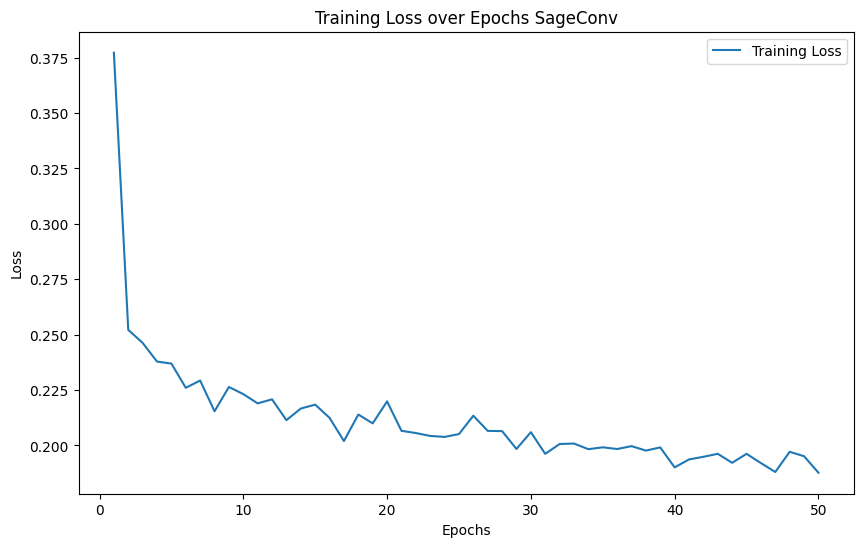

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2674
           1       0.43      0.93      0.59       198

    accuracy                           0.91      2872
   macro avg       0.71      0.92      0.77      2872
weighted avg       0.96      0.91      0.92      2872



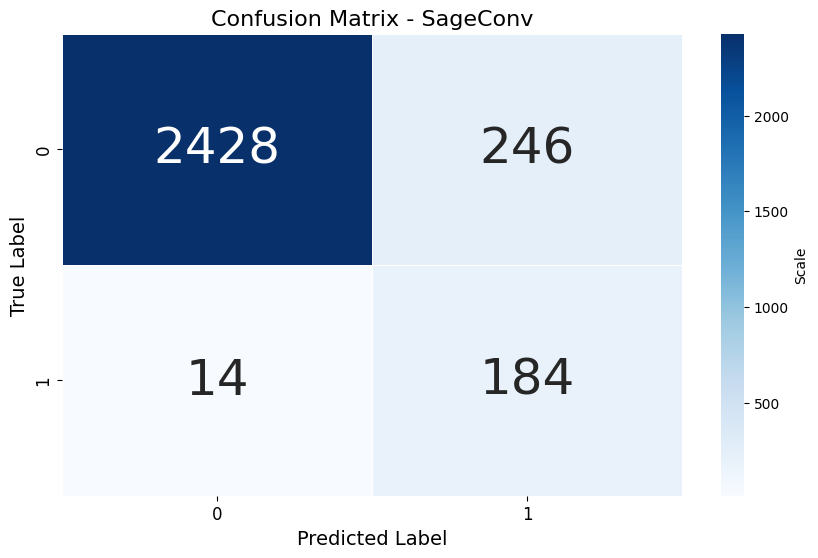

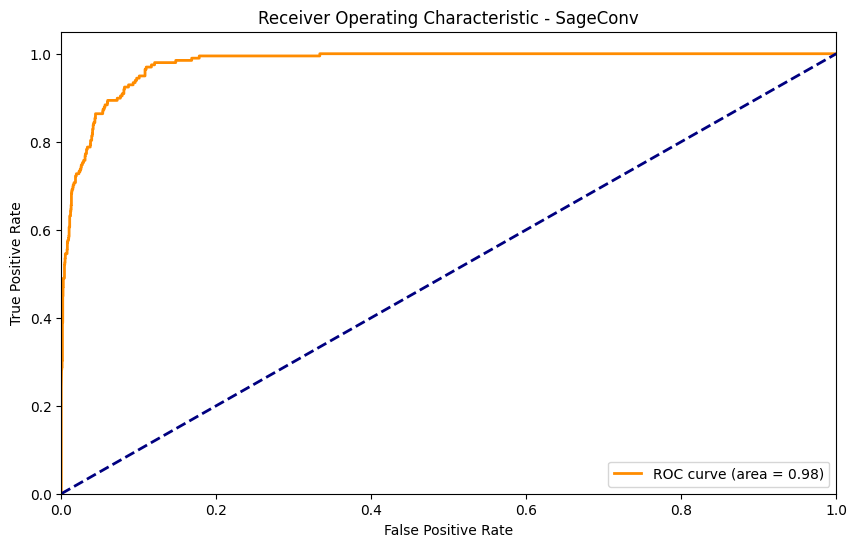

Inside train model with class weights
Epoch 1, Loss: 0.6328025641648666
Epoch 2, Loss: 0.49699662042700726
Epoch 3, Loss: 0.3898197619811348
Epoch 4, Loss: 0.3685709121434585
Epoch 5, Loss: 0.3635231139867202
Epoch 6, Loss: 0.3581435712783233
Epoch 7, Loss: 0.3579468642887862
Epoch 8, Loss: 0.3538225850333338
Epoch 9, Loss: 0.3460371883019157
Epoch 10, Loss: 0.351646363735199
Epoch 11, Loss: 0.342843988991302
Epoch 12, Loss: 0.34224046572394995
Epoch 13, Loss: 0.33760933448439057
Epoch 14, Loss: 0.34397166675847507
Epoch 15, Loss: 0.33570036648408225
Epoch 16, Loss: 0.3358637998285501
Epoch 17, Loss: 0.3358407798020736
Epoch 18, Loss: 0.3294028733735499
Epoch 19, Loss: 0.3324250530289567
Epoch 20, Loss: 0.32963167811217514
Epoch 21, Loss: 0.3276852106918459
Epoch 22, Loss: 0.32669624038364575
Epoch 23, Loss: 0.32443657711796137
Epoch 24, Loss: 0.32581260605998663
Epoch 25, Loss: 0.3253435084353323
Epoch 26, Loss: 0.32442971902049106
Epoch 27, Loss: 0.320355584440024
Epoch 28, Loss: 0.3

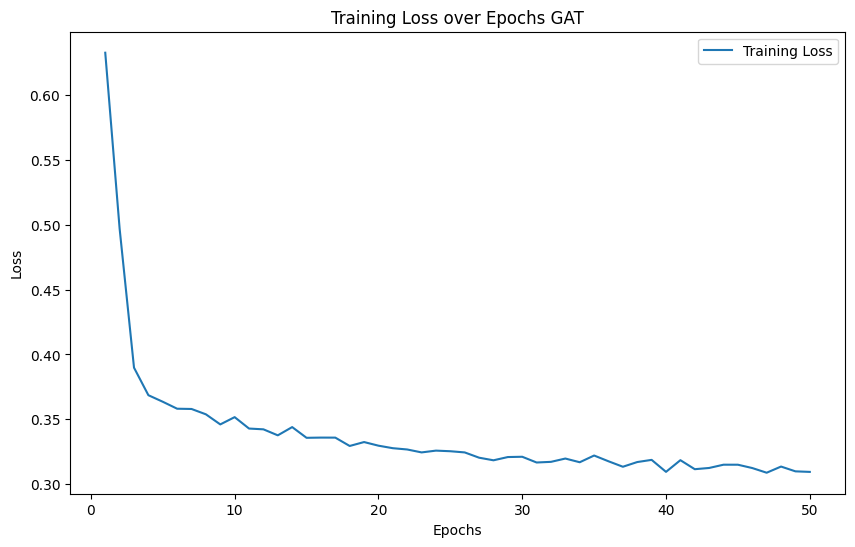

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2674
           1       0.38      0.84      0.52       198

    accuracy                           0.89      2872
   macro avg       0.68      0.87      0.73      2872
weighted avg       0.95      0.89      0.91      2872



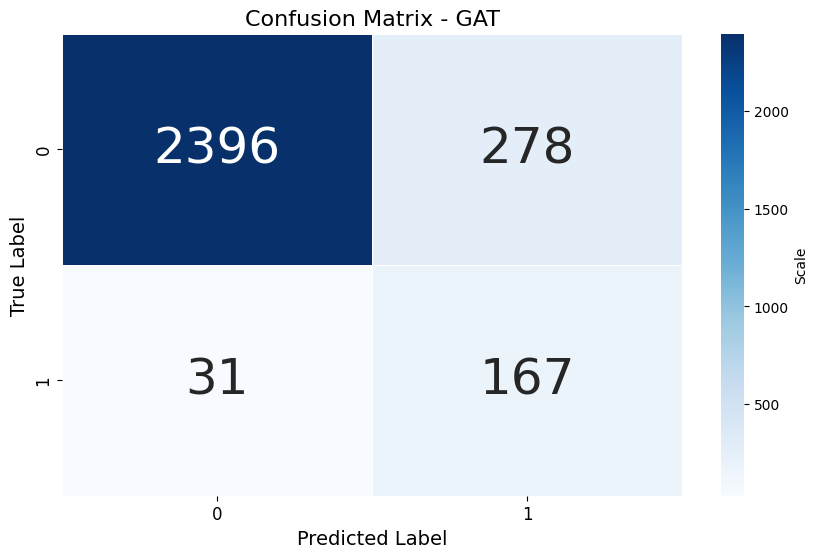

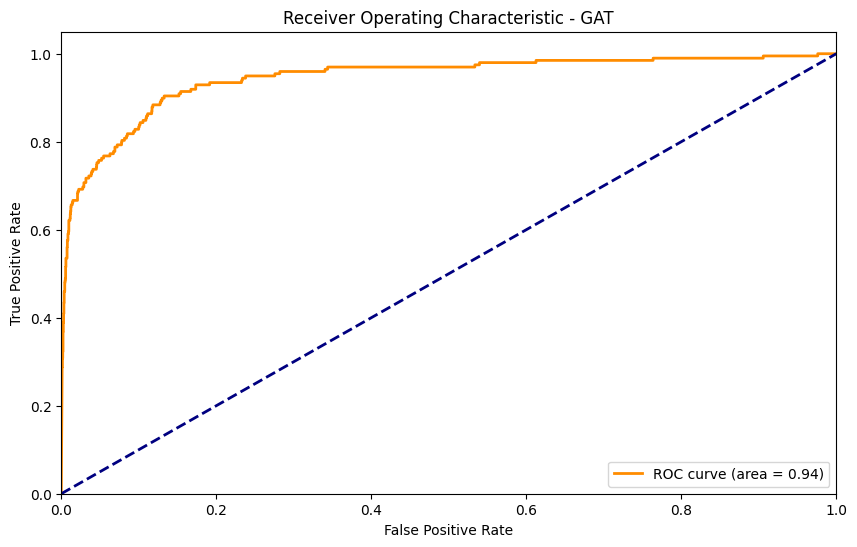

Inside train model with class weights
Epoch 1, Loss: 0.3703842422236567
Epoch 2, Loss: 0.25759292685467267
Epoch 3, Loss: 0.23930887068095413
Epoch 4, Loss: 0.22920354747253915
Epoch 5, Loss: 0.23206479701658952
Epoch 6, Loss: 0.2310661589321883
Epoch 7, Loss: 0.21943483955186346
Epoch 8, Loss: 0.22087635601992192
Epoch 9, Loss: 0.21429855392678923
Epoch 10, Loss: 0.2154937441582265
Epoch 11, Loss: 0.21734924986958504
Epoch 12, Loss: 0.21444217990274014
Epoch 13, Loss: 0.20666629594305289
Epoch 14, Loss: 0.20753993968600812
Epoch 15, Loss: 0.20843334236870642
Epoch 16, Loss: 0.20662180787843207
Epoch 17, Loss: 0.20441597862088162
Epoch 18, Loss: 0.1998188076135905
Epoch 19, Loss: 0.20719529380616936
Epoch 20, Loss: 0.20040146844542545
Epoch 21, Loss: 0.20160219332446222
Epoch 22, Loss: 0.19837022653740385
Epoch 23, Loss: 0.19881733620296355
Epoch 24, Loss: 0.20064715700952904
Epoch 25, Loss: 0.19985195346500562
Epoch 26, Loss: 0.1923886471144531
Epoch 27, Loss: 0.19932336603169856
Epoc

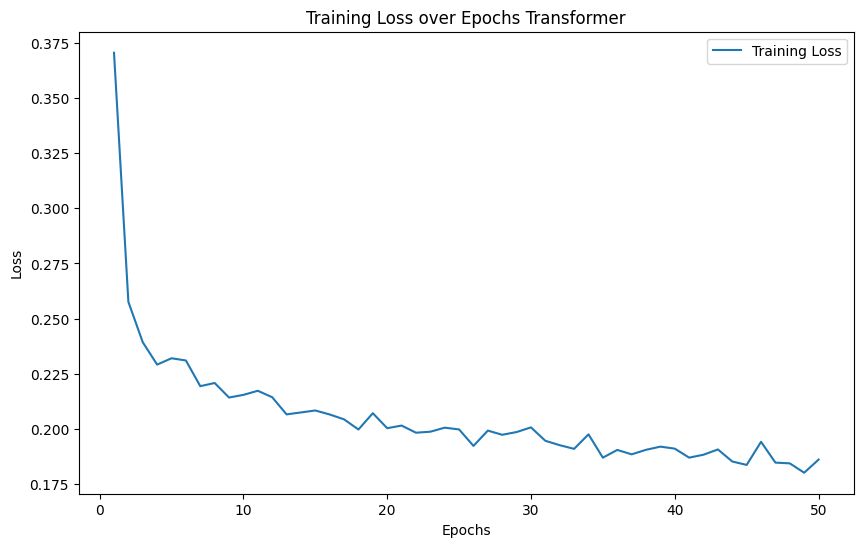

              precision    recall  f1-score   support

           0       1.00      0.90      0.94      2674
           1       0.40      0.95      0.56       198

    accuracy                           0.90      2872
   macro avg       0.70      0.92      0.75      2872
weighted avg       0.95      0.90      0.92      2872



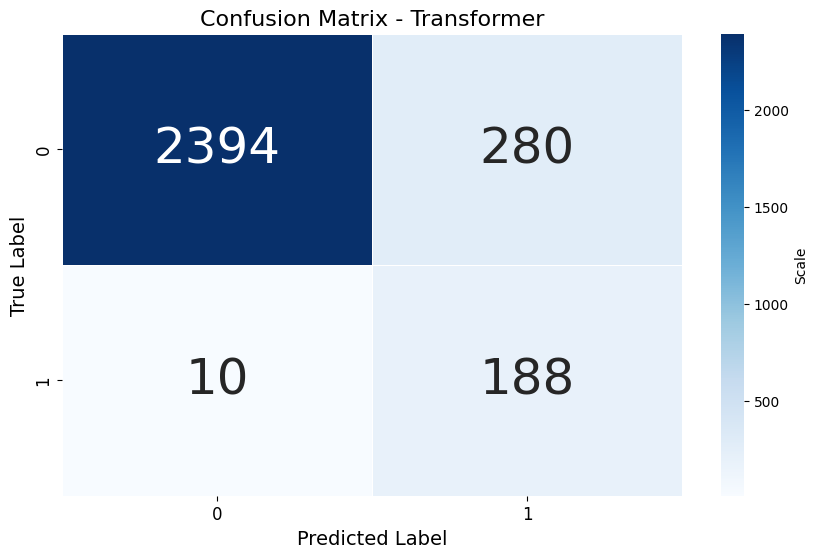

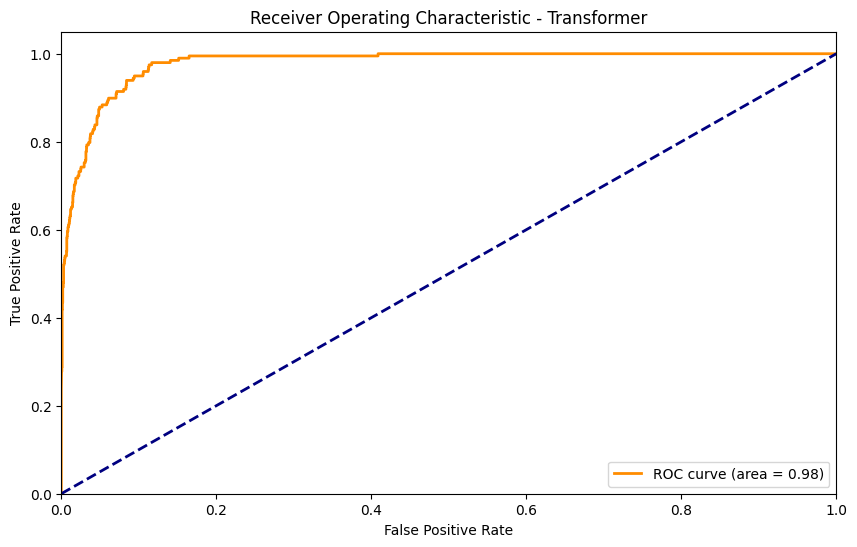

Inside train model with class weights
Epoch 1, Loss: 0.6115090756312661
Epoch 2, Loss: 0.48962294925814087
Epoch 3, Loss: 0.4411401690348335
Epoch 4, Loss: 0.41331934151442157
Epoch 5, Loss: 0.39190039880897687
Epoch 6, Loss: 0.3720977079609166
Epoch 7, Loss: 0.3544218057523603
Epoch 8, Loss: 0.34857643978751224
Epoch 9, Loss: 0.3342336477792781
Epoch 10, Loss: 0.33903791723044024
Epoch 11, Loss: 0.3444520348440046
Epoch 12, Loss: 0.3410385840612909
Epoch 13, Loss: 0.33021704787793366
Epoch 14, Loss: 0.3380806070307027
Epoch 15, Loss: 0.32833597387956537
Epoch 16, Loss: 0.32688454052676325
Epoch 17, Loss: 0.3288992031112961
Epoch 18, Loss: 0.3270450817502063
Epoch 19, Loss: 0.3241556724128516
Epoch 20, Loss: 0.32523123012936633
Epoch 21, Loss: 0.3240590578188067
Epoch 22, Loss: 0.326233035520367
Epoch 23, Loss: 0.31932575352813886
Epoch 24, Loss: 0.3193416945312334
Epoch 25, Loss: 0.31986318399076874
Epoch 26, Loss: 0.31746605459762656
Epoch 27, Loss: 0.3165223831715791
Epoch 28, Loss:

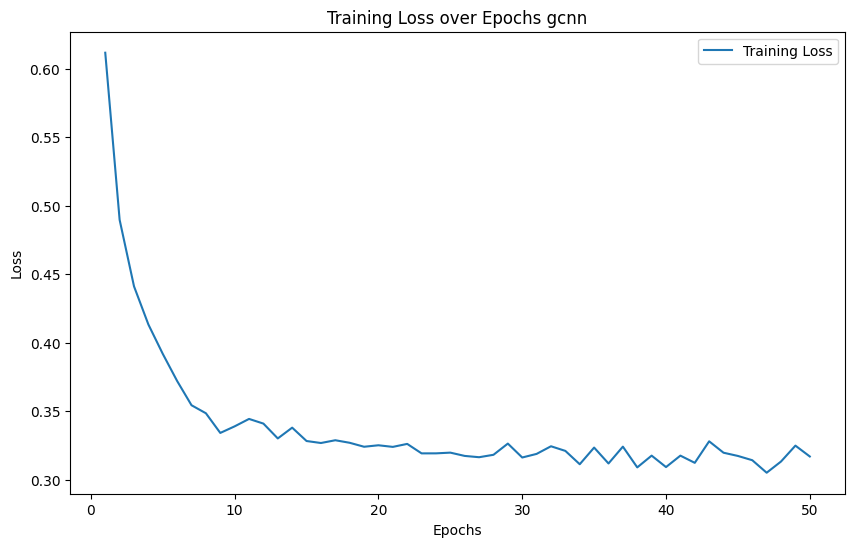

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2674
           1       0.32      0.94      0.48       198

    accuracy                           0.86      2872
   macro avg       0.66      0.90      0.70      2872
weighted avg       0.95      0.86      0.89      2872



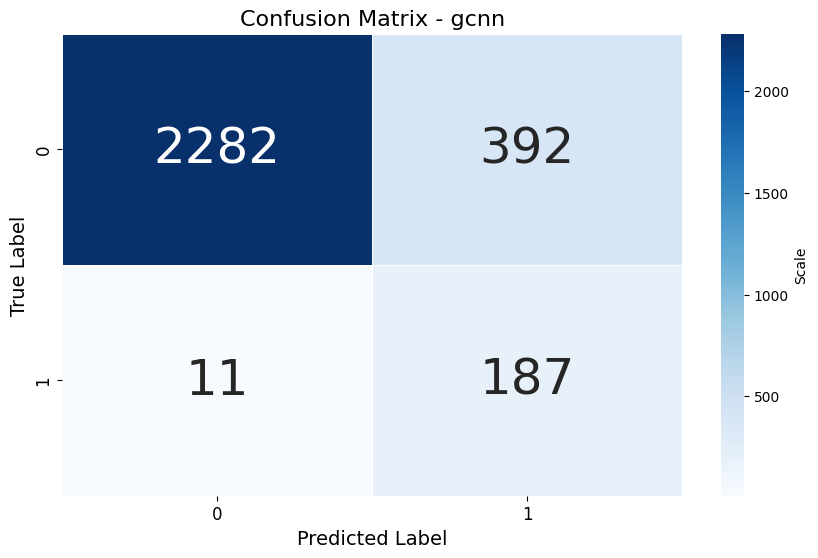

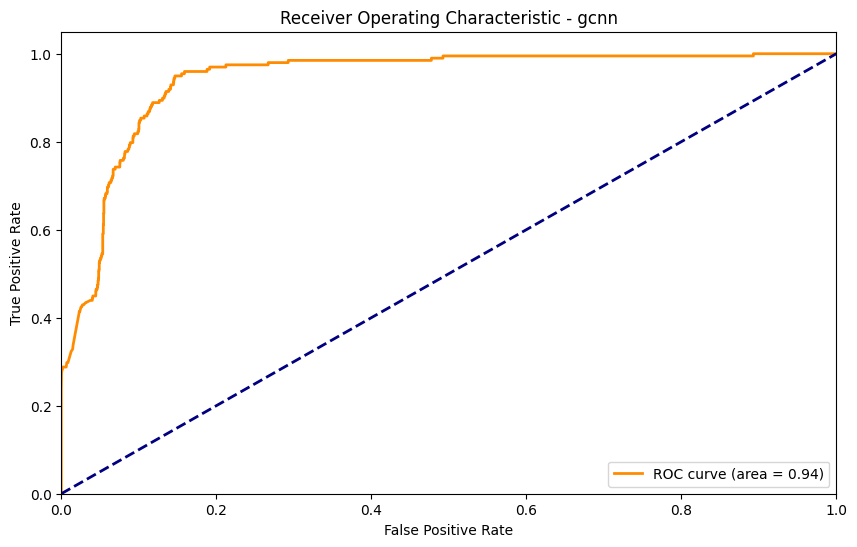

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}}
stage3_data_cleaning/v2\type1_label_merged_final_decoded_clean3.xlsx
type1_label_


100%|██████████████████████████████████████████████████████████████████████████████| 2079/2079 [02:51<00:00, 12.13it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1455
test_data: 624
train_data:1455
test_data:624
Inside train model with class weights
Epoch 1, Loss: 0.22665745951235294
Epoch 2, Loss: 0.079234320062982
Epoch 3, Loss: 0.07397894107777139
Epoch 4, Loss: 0.07213111436399429
Epoch 5, Loss: 0.061013593662368214
Epoch 6, Loss: 0.05680804821136205
Epoch 7, Loss: 0.06088080054715923
Epoch 8, Loss: 0.05397170991636813
Epoch 9, Loss: 0.04995306716907932
Epoch 10, Loss: 0.051144771460119795
Epoch 11, Loss: 0.04797692360032512
Epoch 12, Loss: 0.047124809018619686
Epoch 13, Loss: 0.04539468214320748
Epoch 14, Loss: 0.04502179821872193
Epoch 15, Loss: 0.04305571912909332
Epoch 16, Loss: 0.04340326975342696
Epoch 17, Loss: 0.046415986007322434
Epoch 18, Loss: 0.04498830255444931
Epoch 19, Loss: 0.040368658237402204
Epoch 20, Loss: 0.038090701741368874
Epoch 21, Loss: 0.04200171559806103
Epoch 22, Loss: 0.04210927028654386
Epoch 23, Loss: 0.037838225931172136
Epoch 24, Loss: 0.0386127248791087
Epoch 25, Loss: 0.039648778159576265
Epoc

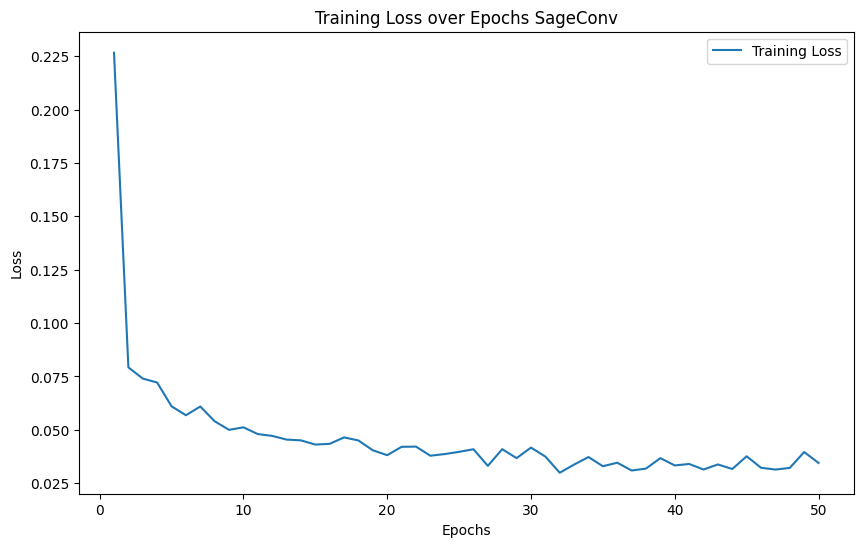

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1285
           1       0.98      1.00      0.99       485

    accuracy                           0.99      1770
   macro avg       0.99      0.99      0.99      1770
weighted avg       0.99      0.99      0.99      1770



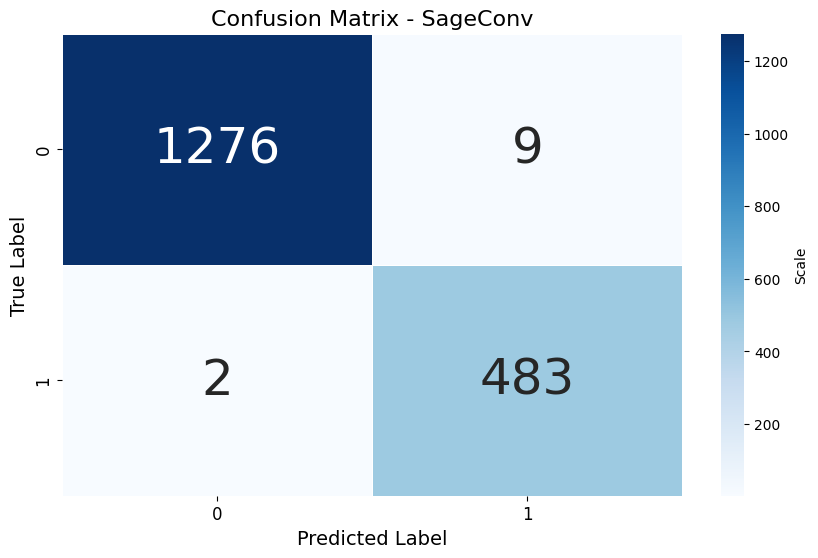

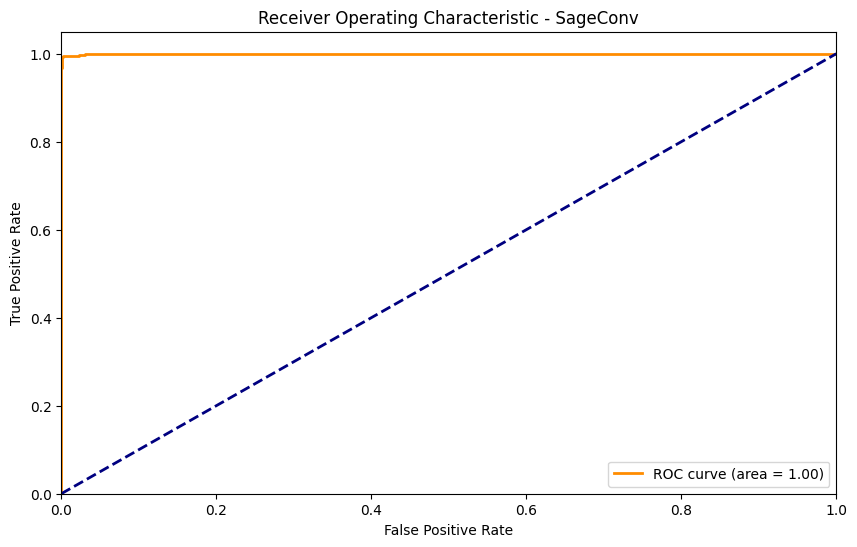

Inside train model with class weights
Epoch 1, Loss: 0.5191524877496387
Epoch 2, Loss: 0.3159668371081352
Epoch 3, Loss: 0.29743633289699967
Epoch 4, Loss: 0.2776944096321645
Epoch 5, Loss: 0.2774836881005246
Epoch 6, Loss: 0.2693796938528185
Epoch 7, Loss: 0.2673167783928954
Epoch 8, Loss: 0.2646251048730767
Epoch 9, Loss: 0.26092234901759936
Epoch 10, Loss: 0.25606931276295497
Epoch 11, Loss: 0.25228271989718726
Epoch 12, Loss: 0.249816062171822
Epoch 13, Loss: 0.24899219883524853
Epoch 14, Loss: 0.24451814235552496
Epoch 15, Loss: 0.23973543990565382
Epoch 16, Loss: 0.24296384823063147
Epoch 17, Loss: 0.23722326625948367
Epoch 18, Loss: 0.23724962916711104
Epoch 19, Loss: 0.237976081021454
Epoch 20, Loss: 0.23467432270231453
Epoch 21, Loss: 0.23518715280553568
Epoch 22, Loss: 0.23236117058474084
Epoch 23, Loss: 0.23408251190962998
Epoch 24, Loss: 0.233185064047575
Epoch 25, Loss: 0.2314988352034403
Epoch 26, Loss: 0.23094234599367433
Epoch 27, Loss: 0.22710414230823517
Epoch 28, Los

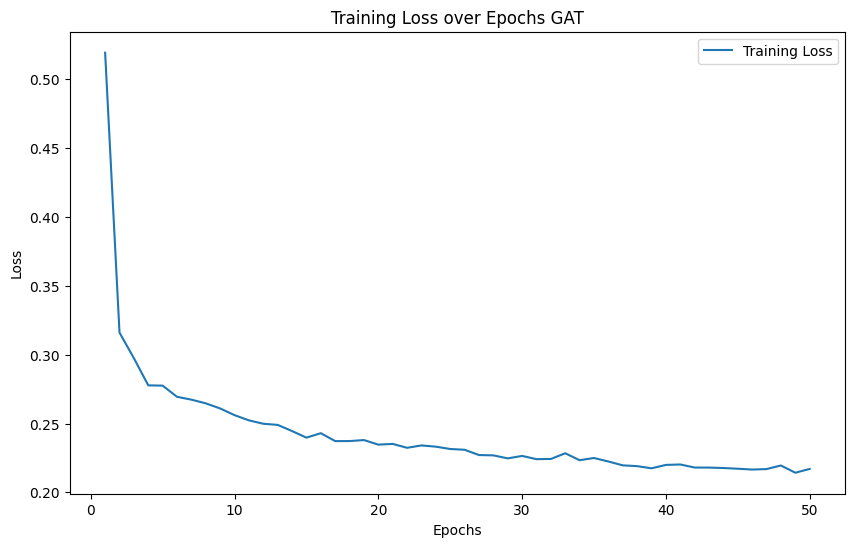

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1285
           1       0.72      0.93      0.81       485

    accuracy                           0.88      1770
   macro avg       0.84      0.90      0.86      1770
weighted avg       0.90      0.88      0.89      1770



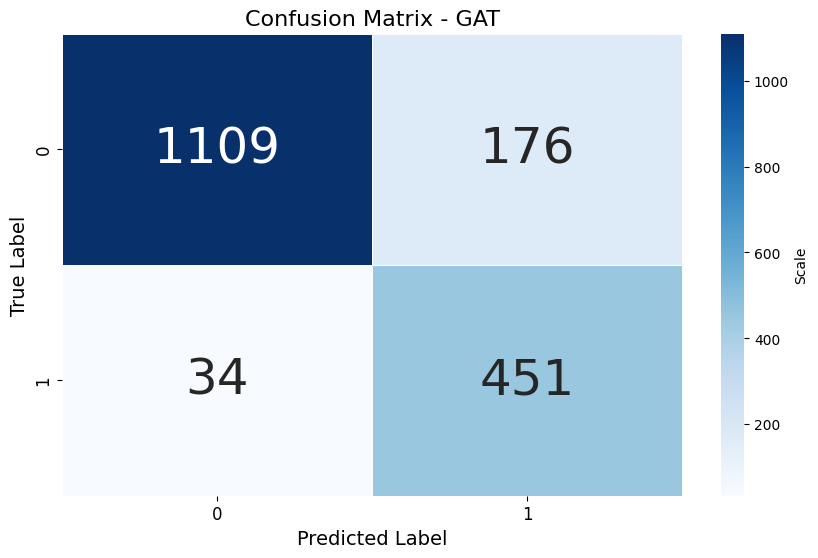

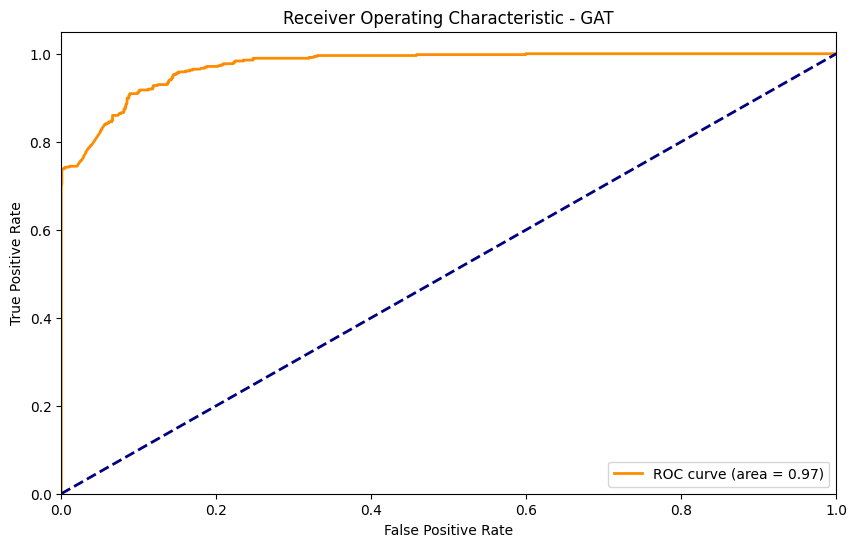

Inside train model with class weights
Epoch 1, Loss: 0.22085784116516943
Epoch 2, Loss: 0.08959621466372324
Epoch 3, Loss: 0.07224941942030969
Epoch 4, Loss: 0.07420502056408187
Epoch 5, Loss: 0.06349645725086979
Epoch 6, Loss: 0.06361207955152444
Epoch 7, Loss: 0.05866321941594715
Epoch 8, Loss: 0.05700872641097268
Epoch 9, Loss: 0.05043120608341111
Epoch 10, Loss: 0.04500848255322679
Epoch 11, Loss: 0.05132160943163478
Epoch 12, Loss: 0.04603641864884159
Epoch 13, Loss: 0.0422004785226739
Epoch 14, Loss: 0.04182126871107713
Epoch 15, Loss: 0.04056108389657153
Epoch 16, Loss: 0.03839906032764069
Epoch 17, Loss: 0.036716937573383686
Epoch 18, Loss: 0.039264060435411724
Epoch 19, Loss: 0.03531570534181336
Epoch 20, Loss: 0.03513038004546062
Epoch 21, Loss: 0.037967096619388976
Epoch 22, Loss: 0.03556904126890004
Epoch 23, Loss: 0.03431328175002304
Epoch 24, Loss: 0.03597128023292222
Epoch 25, Loss: 0.03214488446752986
Epoch 26, Loss: 0.030291131808948907
Epoch 27, Loss: 0.03228018565973

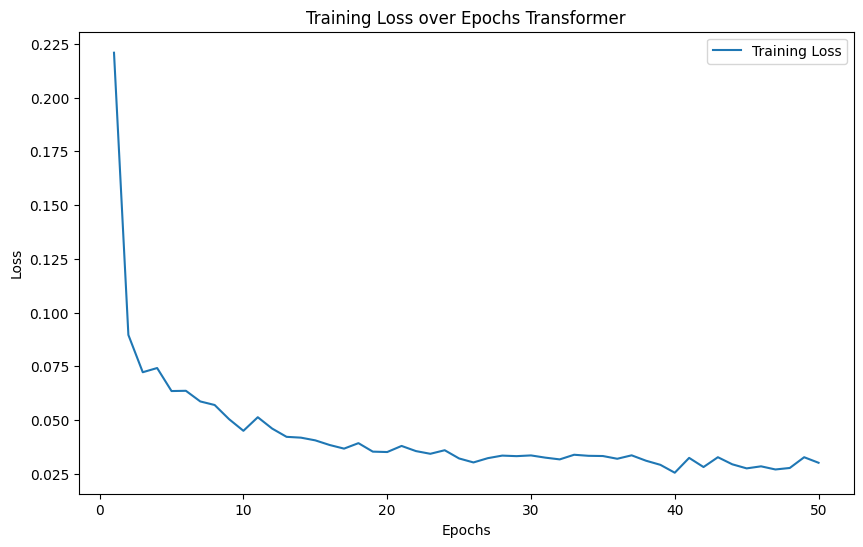

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1285
           1       0.98      1.00      0.99       485

    accuracy                           0.99      1770
   macro avg       0.99      0.99      0.99      1770
weighted avg       0.99      0.99      0.99      1770



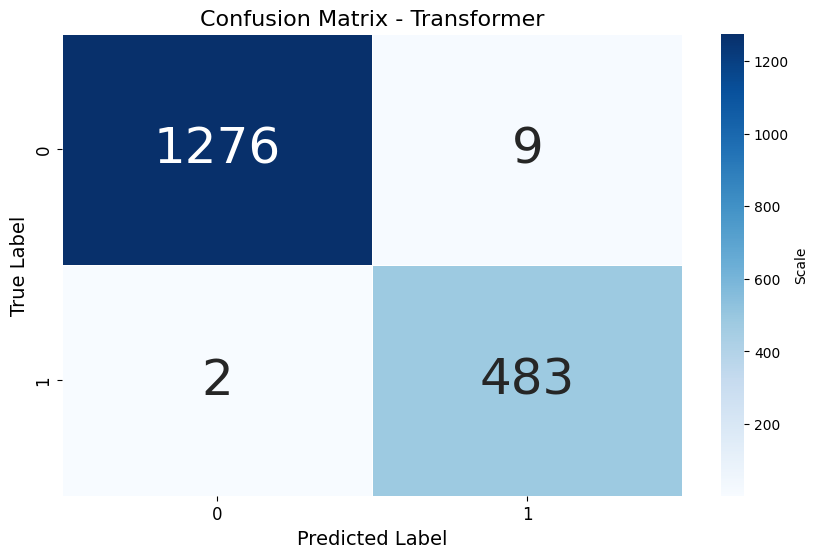

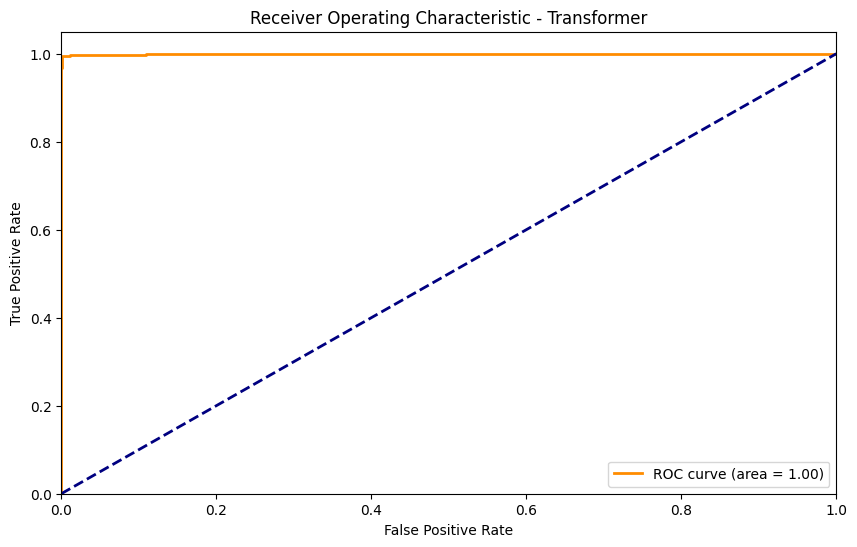

Inside train model with class weights
Epoch 1, Loss: 0.5235039514044056
Epoch 2, Loss: 0.31879314618266147
Epoch 3, Loss: 0.30447274900001026
Epoch 4, Loss: 0.29947083929310675
Epoch 5, Loss: 0.29350701913885446
Epoch 6, Loss: 0.2883494301982548
Epoch 7, Loss: 0.2816739639510279
Epoch 8, Loss: 0.2784804737438326
Epoch 9, Loss: 0.27183718784995703
Epoch 10, Loss: 0.2706353103984957
Epoch 11, Loss: 0.26736033869826276
Epoch 12, Loss: 0.26310895318570343
Epoch 13, Loss: 0.2582290697356929
Epoch 14, Loss: 0.2572612321895102
Epoch 15, Loss: 0.25510366908881976
Epoch 16, Loss: 0.2491420599753442
Epoch 17, Loss: 0.252802696402954
Epoch 18, Loss: 0.2520726327986821
Epoch 19, Loss: 0.2524159148983333
Epoch 20, Loss: 0.25324431790605834
Epoch 21, Loss: 0.2518741190433502
Epoch 22, Loss: 0.25313036338142725
Epoch 23, Loss: 0.24063970116169556
Epoch 24, Loss: 0.24487816412811694
Epoch 25, Loss: 0.24229190773938014
Epoch 26, Loss: 0.24859295169944348
Epoch 27, Loss: 0.24534509250003358
Epoch 28, Lo

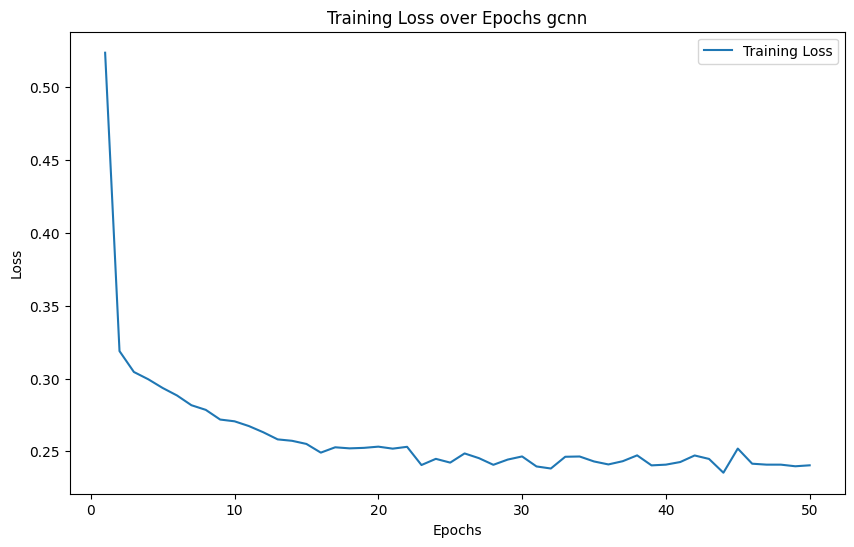

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1285
           1       0.80      0.90      0.85       485

    accuracy                           0.91      1770
   macro avg       0.88      0.91      0.89      1770
weighted avg       0.92      0.91      0.91      1770



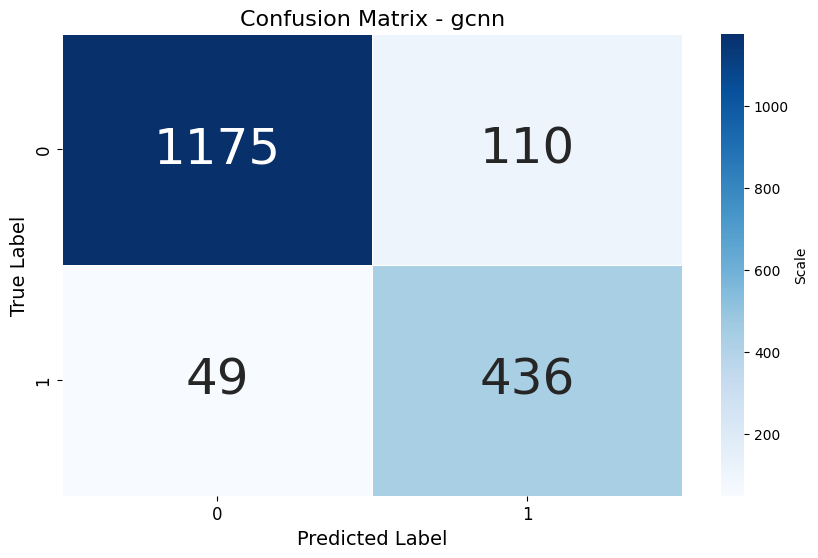

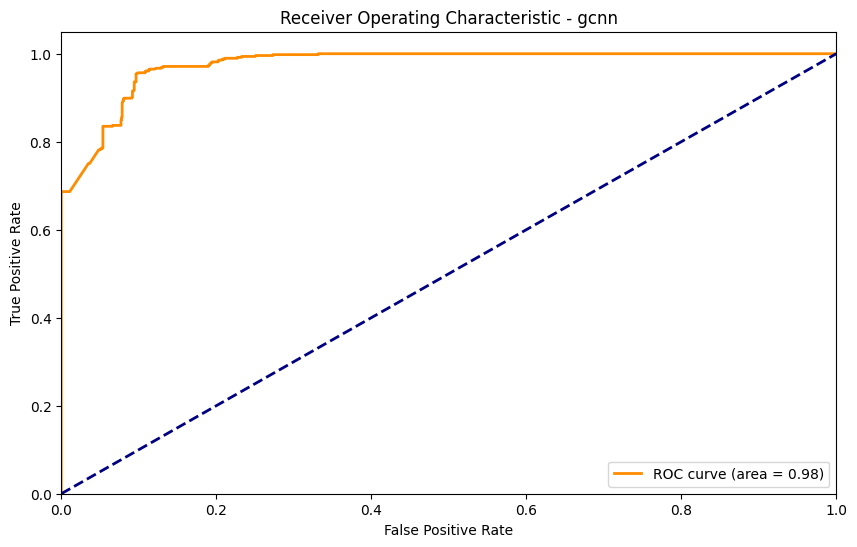

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}}
stage3_data_cleaning/v2\type2_label_merged_final_decoded_clean3.xlsx
type2_label_


100%|██████████████████████████████████████████████████████████████████████████████| 1342/1342 [02:08<00:00, 10.48it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 939
test_data: 403
train_data:939
test_data:403
Inside train model with class weights
Epoch 1, Loss: 0.3866024737556775
Epoch 2, Loss: 0.37907786344488464
Epoch 3, Loss: 0.2951427424947421
Epoch 4, Loss: 0.2712128534913063
Epoch 5, Loss: 0.2672333603103956
Epoch 6, Loss: 0.24345735510190328
Epoch 7, Loss: 0.2740421627958616
Epoch 8, Loss: 0.2260387641688188
Epoch 9, Loss: 0.2726178469757239
Epoch 10, Loss: 0.23124004503091175
Epoch 11, Loss: 0.18149212064842382
Epoch 12, Loss: 0.1840864842136701
Epoch 13, Loss: 0.1988618160287539
Epoch 14, Loss: 0.2336158834397793
Epoch 15, Loss: 0.1732042656590541
Epoch 16, Loss: 0.139907235900561
Epoch 17, Loss: 0.19943779595196248
Epoch 18, Loss: 0.15209103599190713
Epoch 19, Loss: 0.24245056336124737
Epoch 20, Loss: 0.19897107345362505
Epoch 21, Loss: 0.16639774963259696
Epoch 22, Loss: 0.1961893778294325
Epoch 23, Loss: 0.15155589928229649
Epoch 24, Loss: 0.21754048143823942
Epoch 25, Loss: 0.1693807518730561
Epoch 26, Loss: 0.15101436

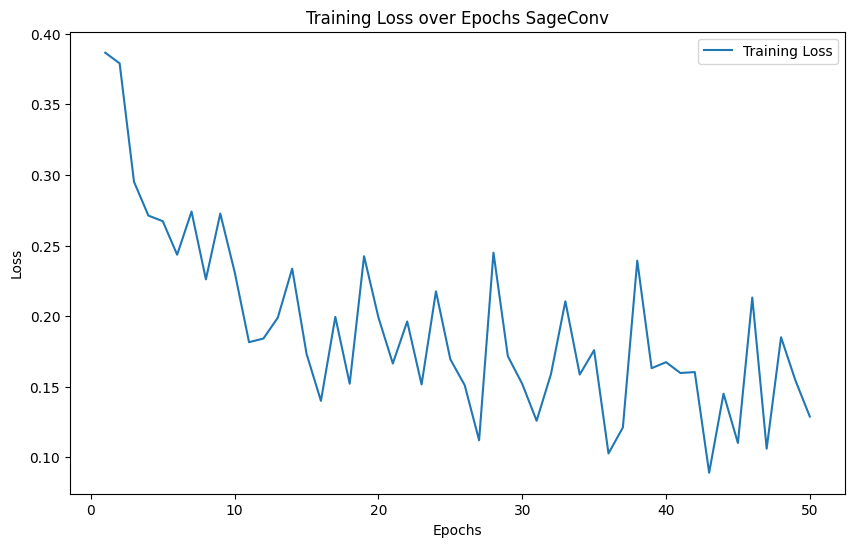

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2098
           1       0.02      0.50      0.04         2

    accuracy                           0.98      2100
   macro avg       0.51      0.74      0.52      2100
weighted avg       1.00      0.98      0.99      2100



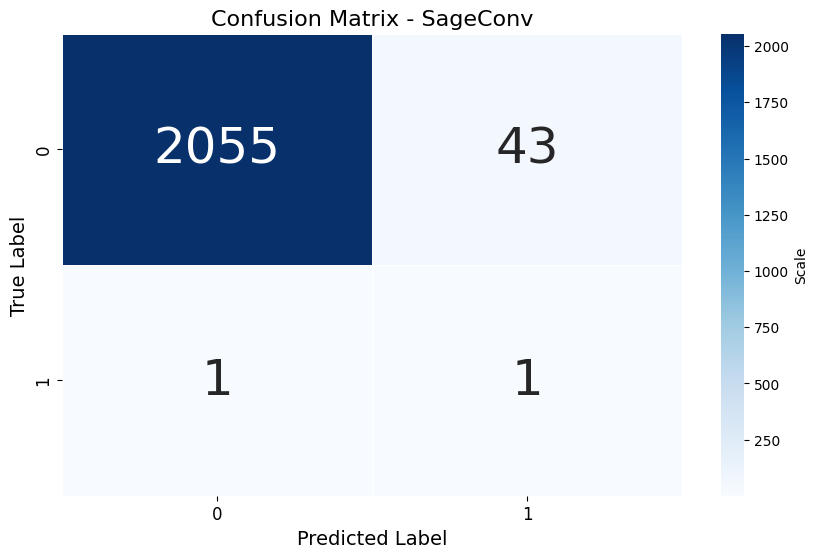

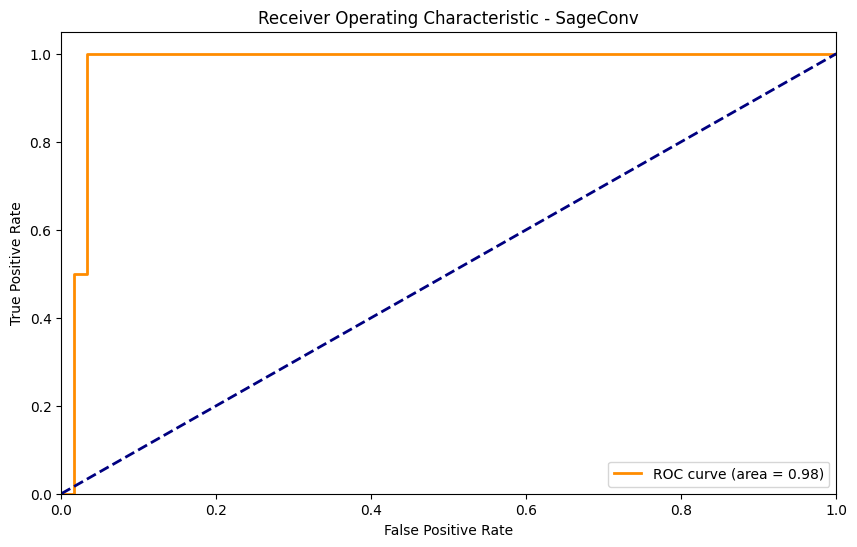

Inside train model with class weights
Epoch 1, Loss: 0.551368843515714
Epoch 2, Loss: 0.41085879107316337
Epoch 3, Loss: 0.3606601511438688
Epoch 4, Loss: 0.3496649647752444
Epoch 5, Loss: 0.35085849116245904
Epoch 6, Loss: 0.33797834639747937
Epoch 7, Loss: 0.33409905756513275
Epoch 8, Loss: 0.35275234207510947
Epoch 9, Loss: 0.31783929045001663
Epoch 10, Loss: 0.2961274698376656
Epoch 11, Loss: 0.2817372828722
Epoch 12, Loss: 0.27211362347006796
Epoch 13, Loss: 0.2820589798192183
Epoch 14, Loss: 0.28521063973506294
Epoch 15, Loss: 0.2946413720647494
Epoch 16, Loss: 0.2867668243745963
Epoch 17, Loss: 0.23135146200656892
Epoch 18, Loss: 0.23918273001909257
Epoch 19, Loss: 0.25473476176460585
Epoch 20, Loss: 0.24275903900464377
Epoch 21, Loss: 0.2769993029534817
Epoch 22, Loss: 0.24176978866259258
Epoch 23, Loss: 0.255991576363643
Epoch 24, Loss: 0.25886053616801896
Epoch 25, Loss: 0.1855019432802995
Epoch 26, Loss: 0.29028164558112624
Epoch 27, Loss: 0.2695274330675602
Epoch 28, Loss: 

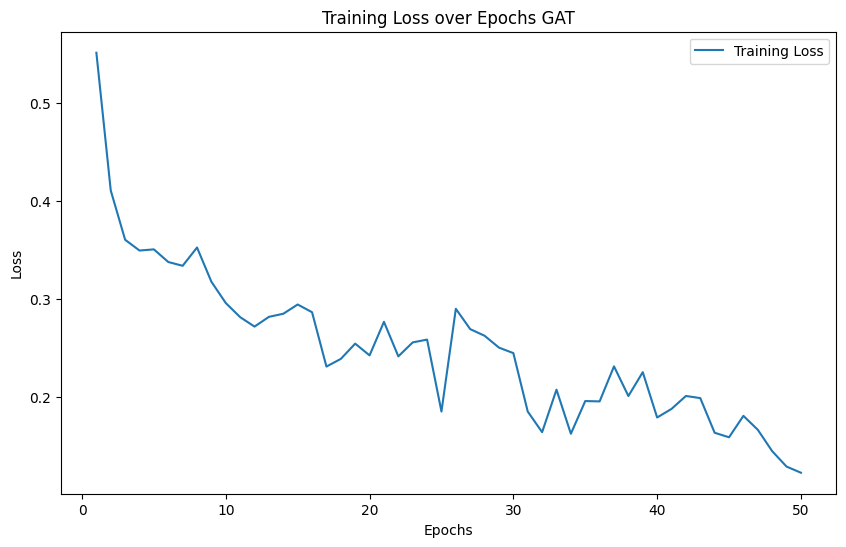

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2098
           1       0.00      0.00      0.00         2

    accuracy                           0.98      2100
   macro avg       0.50      0.49      0.49      2100
weighted avg       1.00      0.98      0.99      2100



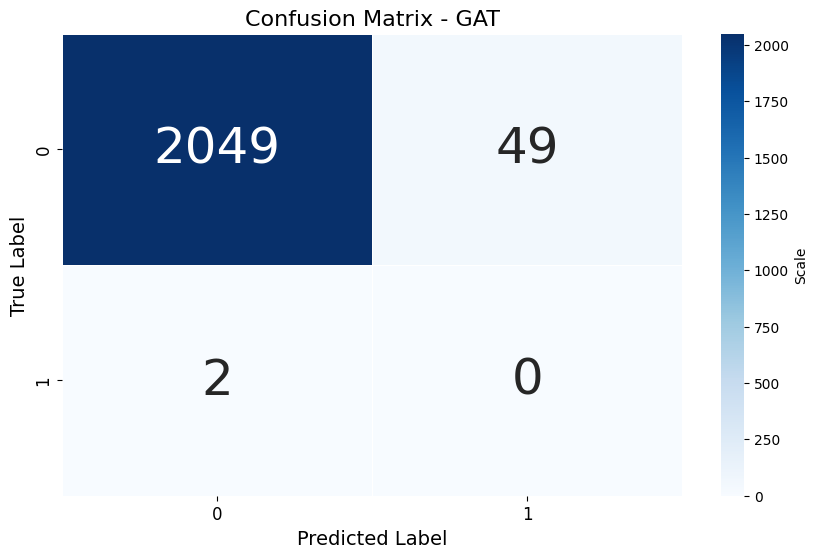

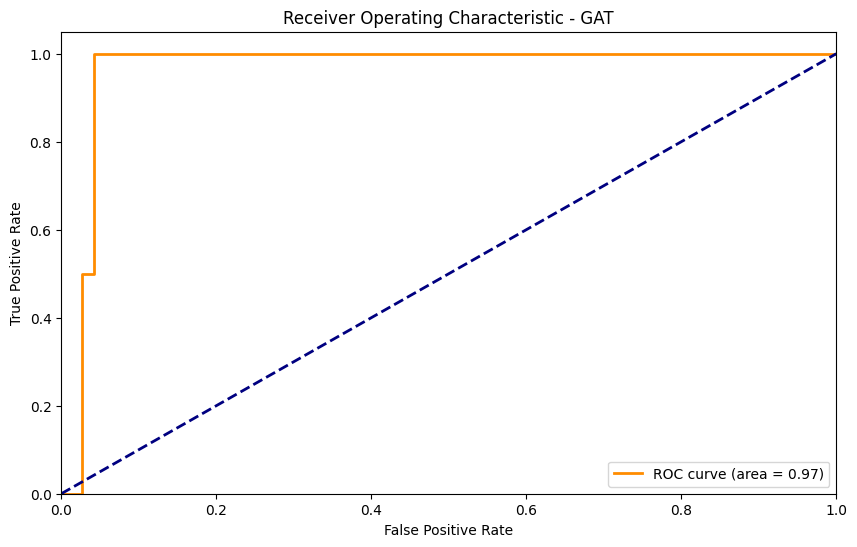

Inside train model with class weights
Epoch 1, Loss: 0.4216338161379099
Epoch 2, Loss: 0.35997260436415673
Epoch 3, Loss: 0.27590548545122145
Epoch 4, Loss: 0.26409606710076333
Epoch 5, Loss: 0.25916140029827756
Epoch 6, Loss: 0.2418250896036625
Epoch 7, Loss: 0.2797826074063778
Epoch 8, Loss: 0.27157116731007896
Epoch 9, Loss: 0.22320949559410413
Epoch 10, Loss: 0.2362232781946659
Epoch 11, Loss: 0.21007236689329148
Epoch 12, Loss: 0.2173275652031104
Epoch 13, Loss: 0.22946712200840313
Epoch 14, Loss: 0.2225840530047814
Epoch 15, Loss: 0.17438182930151622
Epoch 16, Loss: 0.23197255693376065
Epoch 17, Loss: 0.21729534789919852
Epoch 18, Loss: 0.21039540929098924
Epoch 19, Loss: 0.203717178106308
Epoch 20, Loss: 0.16968227339287598
Epoch 21, Loss: 0.20235877533753713
Epoch 22, Loss: 0.1924186062067747
Epoch 23, Loss: 0.1342306384195884
Epoch 24, Loss: 0.16474918487171333
Epoch 25, Loss: 0.21053682367006937
Epoch 26, Loss: 0.1672370841105779
Epoch 27, Loss: 0.2027182389050722
Epoch 28, L

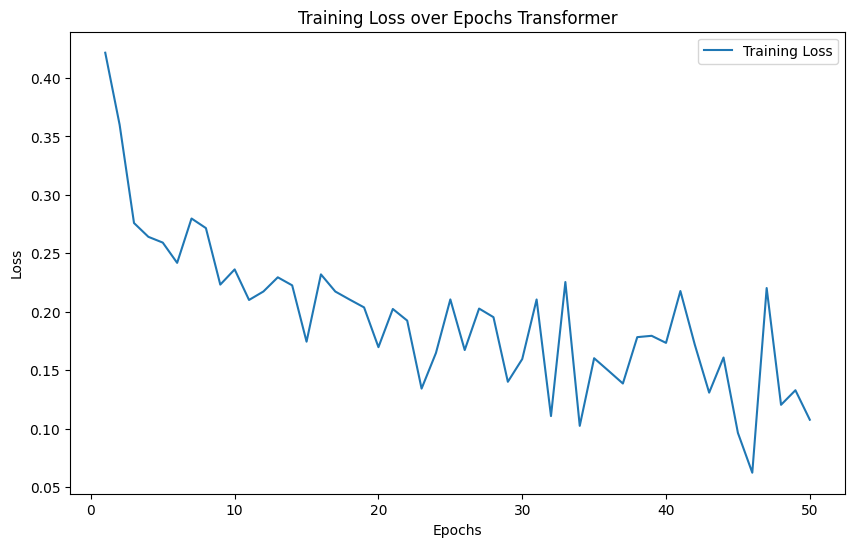

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2098
           1       0.01      0.50      0.03         2

    accuracy                           0.97      2100
   macro avg       0.51      0.73      0.51      2100
weighted avg       1.00      0.97      0.98      2100



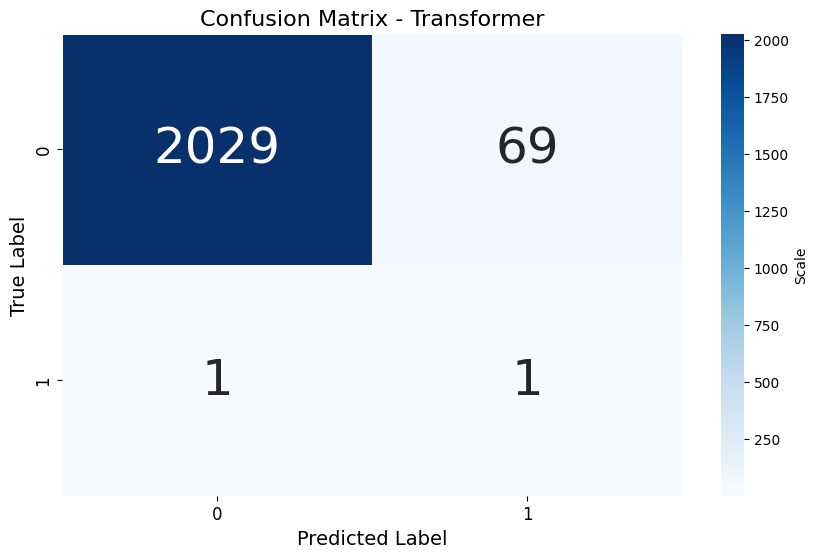

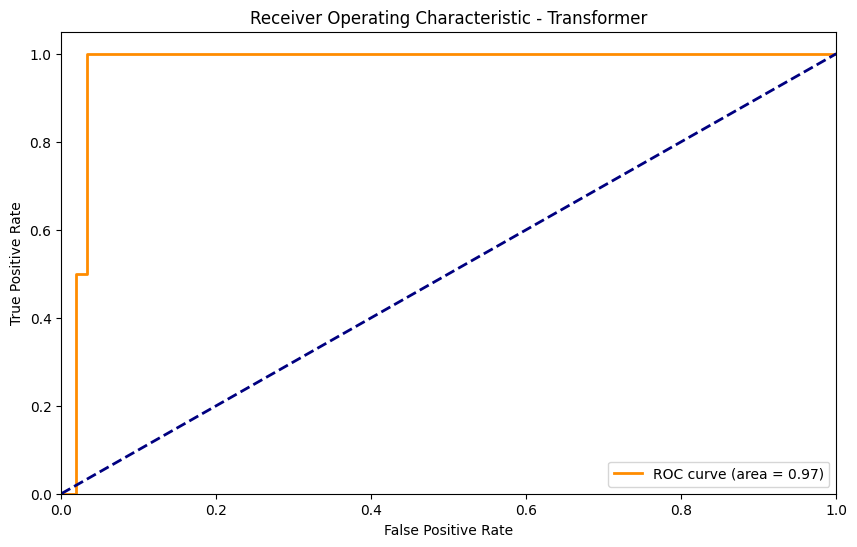

Inside train model with class weights
Epoch 1, Loss: 0.5592807779709498
Epoch 2, Loss: 0.37748382464051244
Epoch 3, Loss: 0.3825667776167393
Epoch 4, Loss: 0.35967064450184505
Epoch 5, Loss: 0.3483396366238594
Epoch 6, Loss: 0.36263030792276063
Epoch 7, Loss: 0.3305671023825804
Epoch 8, Loss: 0.3259251815577348
Epoch 9, Loss: 0.3190749185780684
Epoch 10, Loss: 0.3209433538218339
Epoch 11, Loss: 0.31705623418092727
Epoch 12, Loss: 0.2935463793575764
Epoch 13, Loss: 0.29957502310474715
Epoch 14, Loss: 0.277189036210378
Epoch 15, Loss: 0.2770864047110081
Epoch 16, Loss: 0.28143389721711476
Epoch 17, Loss: 0.2524790773789088
Epoch 18, Loss: 0.26373863567908606
Epoch 19, Loss: 0.2587653920054436
Epoch 20, Loss: 0.26785919020573296
Epoch 21, Loss: 0.2597101909418901
Epoch 22, Loss: 0.25262303253014884
Epoch 23, Loss: 0.22534921020269394
Epoch 24, Loss: 0.25288389523824056
Epoch 25, Loss: 0.24097429141402243
Epoch 26, Loss: 0.24201143023868402
Epoch 27, Loss: 0.22157492662469547
Epoch 28, Los

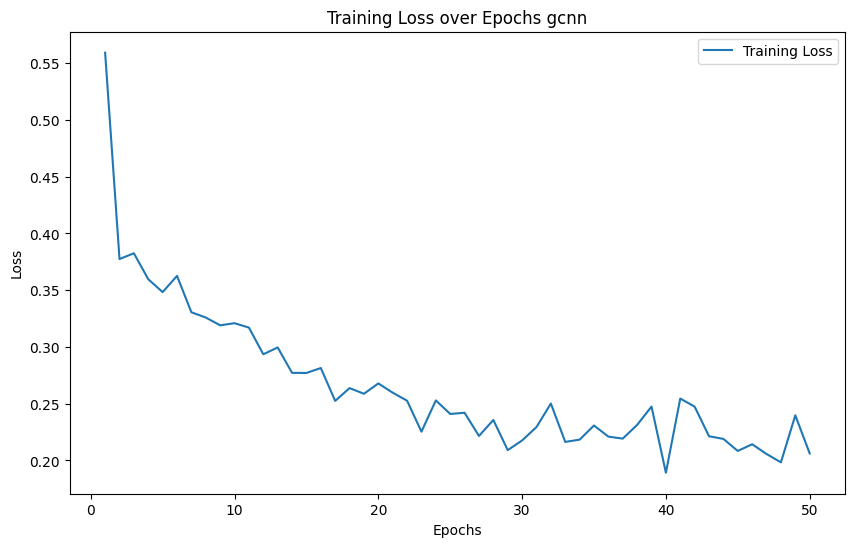

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2098
           1       0.00      0.00      0.00         2

    accuracy                           0.97      2100
   macro avg       0.50      0.49      0.49      2100
weighted avg       1.00      0.97      0.98      2100



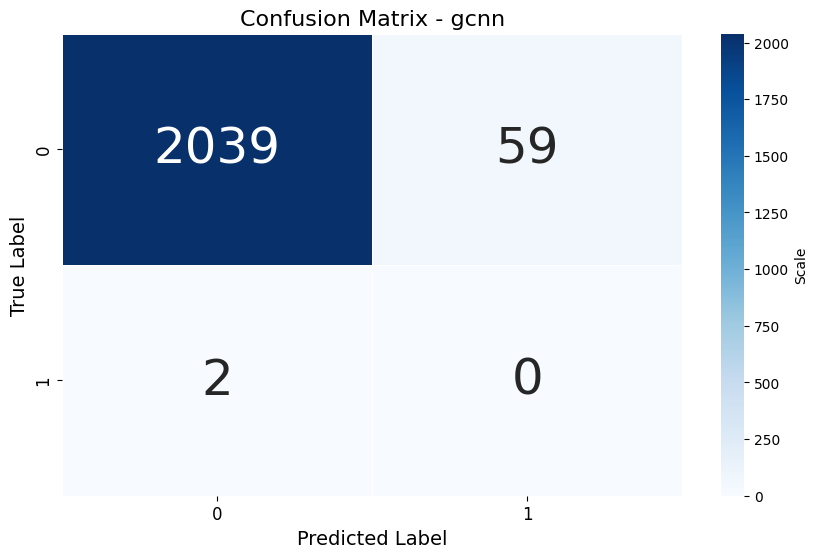

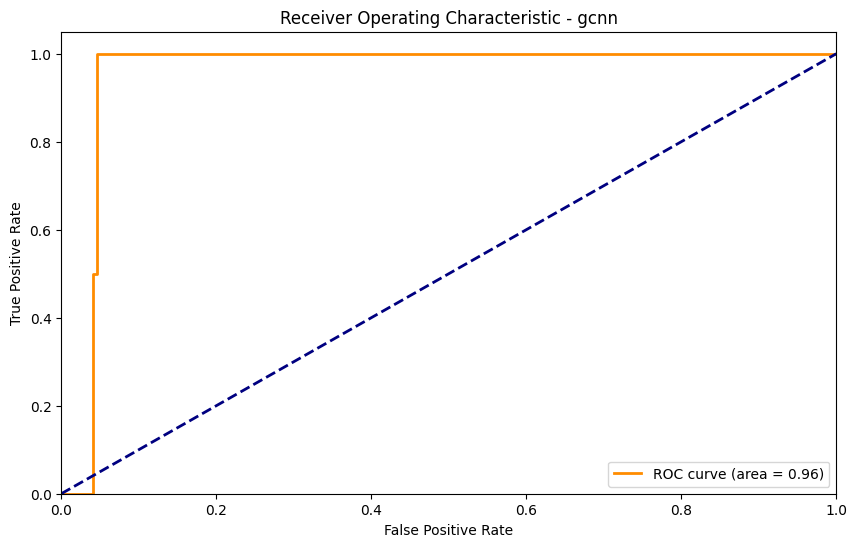

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}}
stage3_data_cleaning/v2\type3_label_merged_final_decoded_clean3.xlsx
type3_label_


100%|██████████████████████████████████████████████████████████████████████████████| 1975/1975 [02:54<00:00, 11.32it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1382
test_data: 593
train_data:1382
test_data:593
Inside train model with class weights
Epoch 1, Loss: 0.2958266183056615
Epoch 2, Loss: 0.13373651744967158
Epoch 3, Loss: 0.12157176553525707
Epoch 4, Loss: 0.11374301590364087
Epoch 5, Loss: 0.1117021343247457
Epoch 6, Loss: 0.09279621595686133
Epoch 7, Loss: 0.09636347165161913
Epoch 8, Loss: 0.09361965090713718
Epoch 9, Loss: 0.08797746240584688
Epoch 10, Loss: 0.0887683801014315
Epoch 11, Loss: 0.07789336534386332
Epoch 12, Loss: 0.08013687998225744
Epoch 13, Loss: 0.0755696337331425
Epoch 14, Loss: 0.07758718623187054
Epoch 15, Loss: 0.07296971024268052
Epoch 16, Loss: 0.07966608770022338
Epoch 17, Loss: 0.0745504053563557
Epoch 18, Loss: 0.07482193562794816
Epoch 19, Loss: 0.06963721412995999
Epoch 20, Loss: 0.07047141626985236
Epoch 21, Loss: 0.06833884911611676
Epoch 22, Loss: 0.07043321517465467
Epoch 23, Loss: 0.0652115294625136
Epoch 24, Loss: 0.06222905800677836
Epoch 25, Loss: 0.06313040359369056
Epoch 26, Loss:

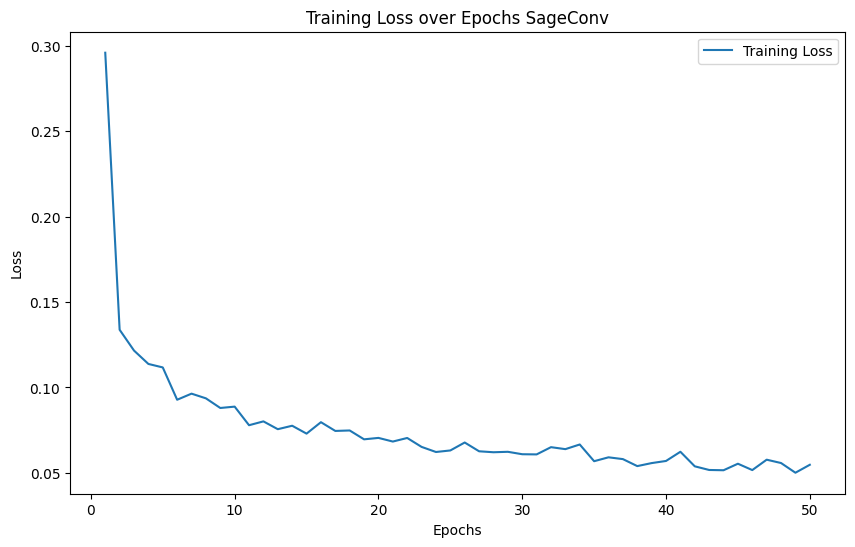

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1901
           1       0.96      0.98      0.97       451

    accuracy                           0.99      2352
   macro avg       0.98      0.99      0.98      2352
weighted avg       0.99      0.99      0.99      2352



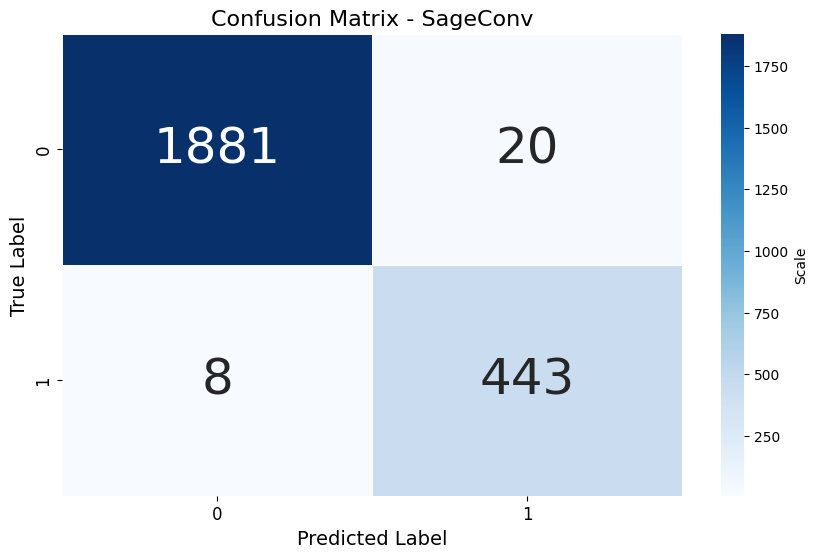

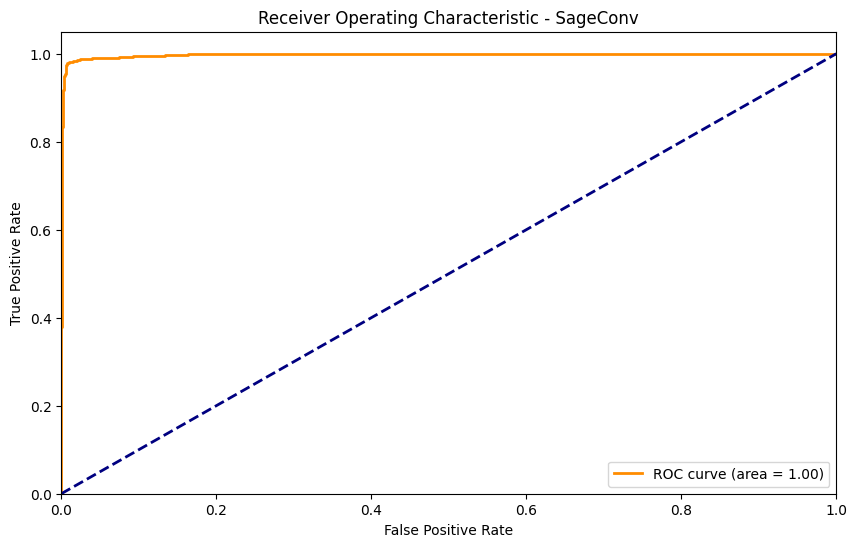

Inside train model with class weights
Epoch 1, Loss: 0.6127413802526214
Epoch 2, Loss: 0.5083748894658956
Epoch 3, Loss: 0.48512736504728143
Epoch 4, Loss: 0.47075688161633233
Epoch 5, Loss: 0.45513351261615753
Epoch 6, Loss: 0.4374707422473214
Epoch 7, Loss: 0.41520244492725894
Epoch 8, Loss: 0.4042421118779616
Epoch 9, Loss: 0.39512838355519553
Epoch 10, Loss: 0.3840037232095545
Epoch 11, Loss: 0.3785326247188178
Epoch 12, Loss: 0.36930524151433597
Epoch 13, Loss: 0.3620944544672966
Epoch 14, Loss: 0.3616830093616789
Epoch 15, Loss: 0.35732031105594203
Epoch 16, Loss: 0.3540657785805789
Epoch 17, Loss: 0.3501190190965479
Epoch 18, Loss: 0.3506834821944887
Epoch 19, Loss: 0.3479962386190891
Epoch 20, Loss: 0.3493992913175713
Epoch 21, Loss: 0.3443049226294864
Epoch 22, Loss: 0.34140643443573604
Epoch 23, Loss: 0.3422118936750022
Epoch 24, Loss: 0.3399414775723761
Epoch 25, Loss: 0.3389744524928657
Epoch 26, Loss: 0.3390038358894261
Epoch 27, Loss: 0.33863435448570683
Epoch 28, Loss: 0

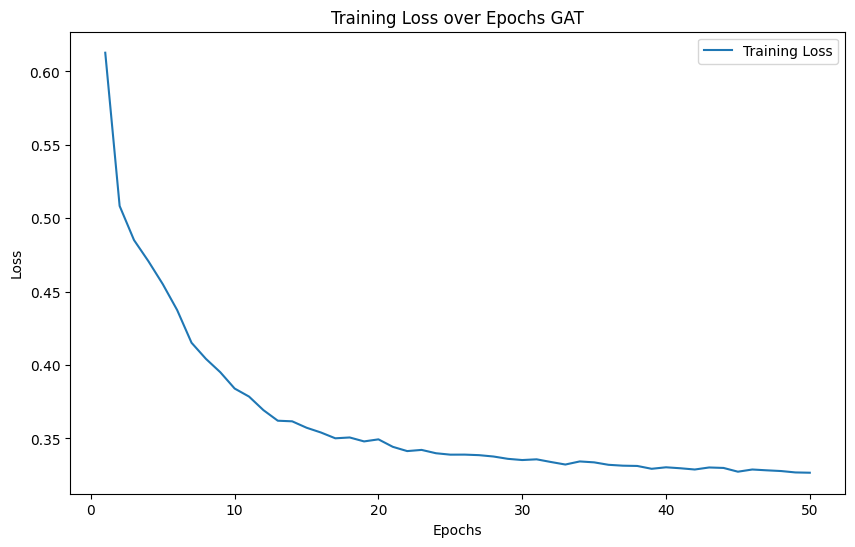

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1901
           1       0.48      0.94      0.63       451

    accuracy                           0.79      2352
   macro avg       0.73      0.85      0.74      2352
weighted avg       0.88      0.79      0.81      2352



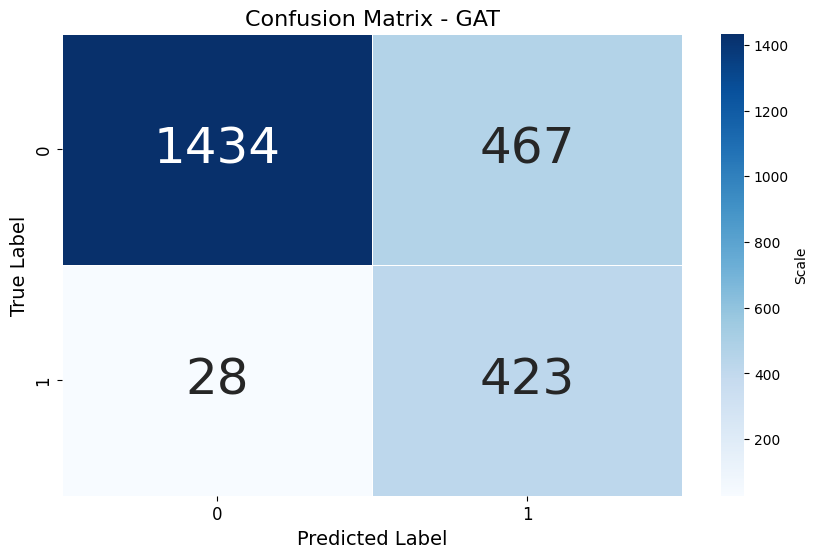

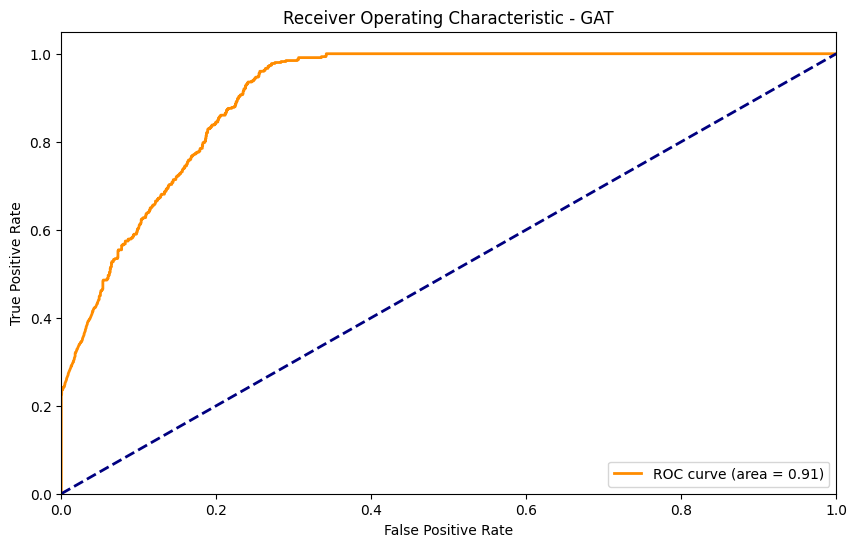

Inside train model with class weights
Epoch 1, Loss: 0.3034580177204175
Epoch 2, Loss: 0.15103574537418105
Epoch 3, Loss: 0.13071284942667594
Epoch 4, Loss: 0.12040694345804778
Epoch 5, Loss: 0.10209529813040387
Epoch 6, Loss: 0.09507612079720605
Epoch 7, Loss: 0.09657951308922334
Epoch 8, Loss: 0.09217570781369101
Epoch 9, Loss: 0.0842068006538532
Epoch 10, Loss: 0.07728856200860305
Epoch 11, Loss: 0.07313678358596834
Epoch 12, Loss: 0.07016609757292
Epoch 13, Loss: 0.06457469912923196
Epoch 14, Loss: 0.07105807346207174
Epoch 15, Loss: 0.06332967239855365
Epoch 16, Loss: 0.06514664802869613
Epoch 17, Loss: 0.06241968701678244
Epoch 18, Loss: 0.06724704827435991
Epoch 19, Loss: 0.05913041811436415
Epoch 20, Loss: 0.06387381048195741
Epoch 21, Loss: 0.05660425088453022
Epoch 22, Loss: 0.05431089224293828
Epoch 23, Loss: 0.05937649804929441
Epoch 24, Loss: 0.053974389998157596
Epoch 25, Loss: 0.05525624409148639
Epoch 26, Loss: 0.05632192529314621
Epoch 27, Loss: 0.05194364458491856
Epo

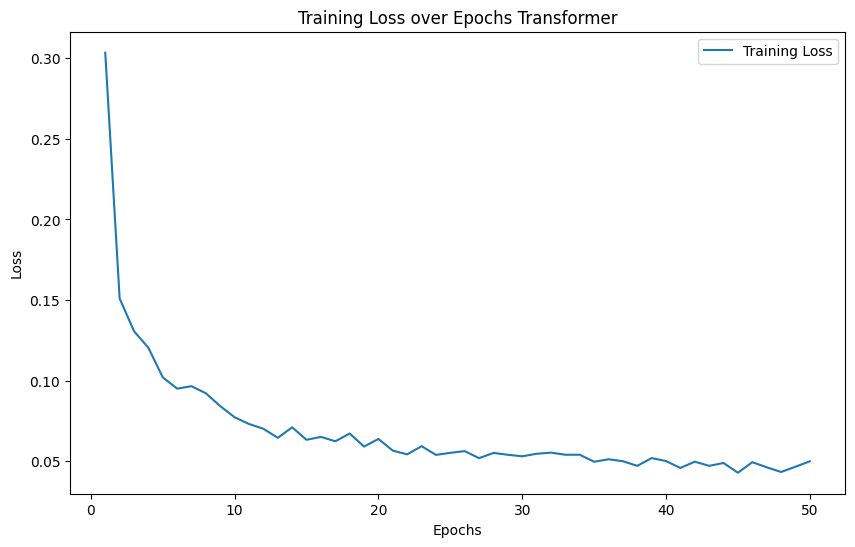

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1901
           1       0.95      0.98      0.96       451

    accuracy                           0.99      2352
   macro avg       0.97      0.98      0.98      2352
weighted avg       0.99      0.99      0.99      2352



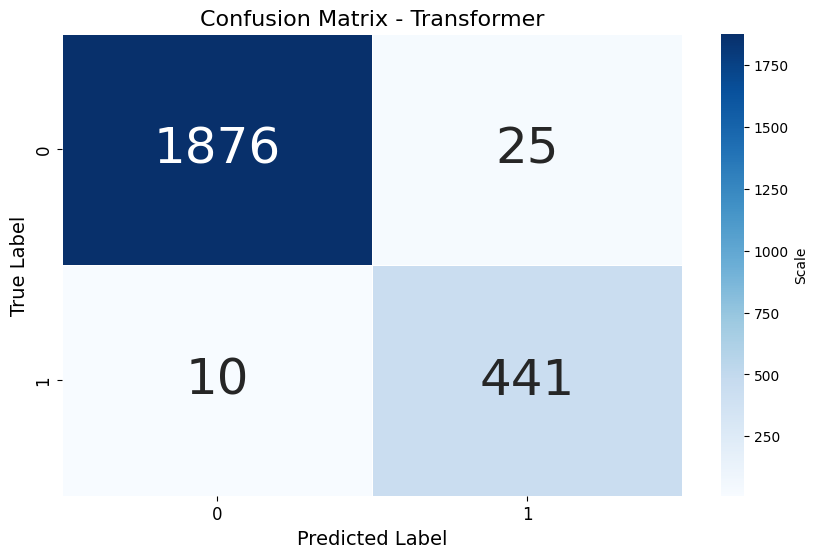

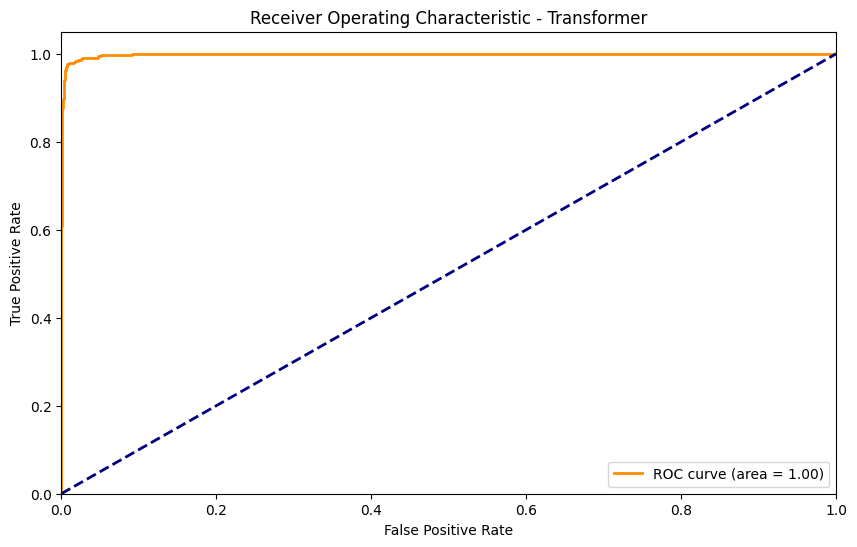

Inside train model with class weights
Epoch 1, Loss: 0.5980621495030143
Epoch 2, Loss: 0.4922848059372468
Epoch 3, Loss: 0.47996791113506665
Epoch 4, Loss: 0.46598064628514374
Epoch 5, Loss: 0.4527486576275392
Epoch 6, Loss: 0.44297225366939197
Epoch 7, Loss: 0.4296232597394423
Epoch 8, Loss: 0.4230498204177076
Epoch 9, Loss: 0.42395217513496225
Epoch 10, Loss: 0.41586039689454163
Epoch 11, Loss: 0.41503327068957413
Epoch 12, Loss: 0.4136836074969985
Epoch 13, Loss: 0.4071249040690335
Epoch 14, Loss: 0.40331496027382935
Epoch 15, Loss: 0.40599262104793027
Epoch 16, Loss: 0.4036839143796401
Epoch 17, Loss: 0.39635760472579434
Epoch 18, Loss: 0.4048199247230183
Epoch 19, Loss: 0.39651557261293585
Epoch 20, Loss: 0.4000432565808296
Epoch 21, Loss: 0.39867349646308203
Epoch 22, Loss: 0.4038258479400115
Epoch 23, Loss: 0.3996590274301442
Epoch 24, Loss: 0.40049508959054947
Epoch 25, Loss: 0.3961856812238693
Epoch 26, Loss: 0.39653222466057
Epoch 27, Loss: 0.39133773947303946
Epoch 28, Loss:

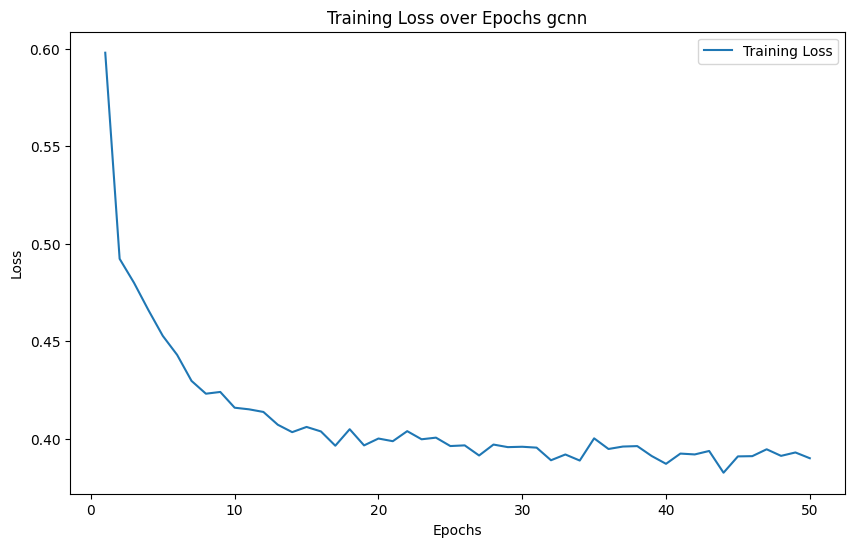

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1901
           1       0.60      0.87      0.71       451

    accuracy                           0.86      2352
   macro avg       0.78      0.86      0.81      2352
weighted avg       0.89      0.86      0.87      2352



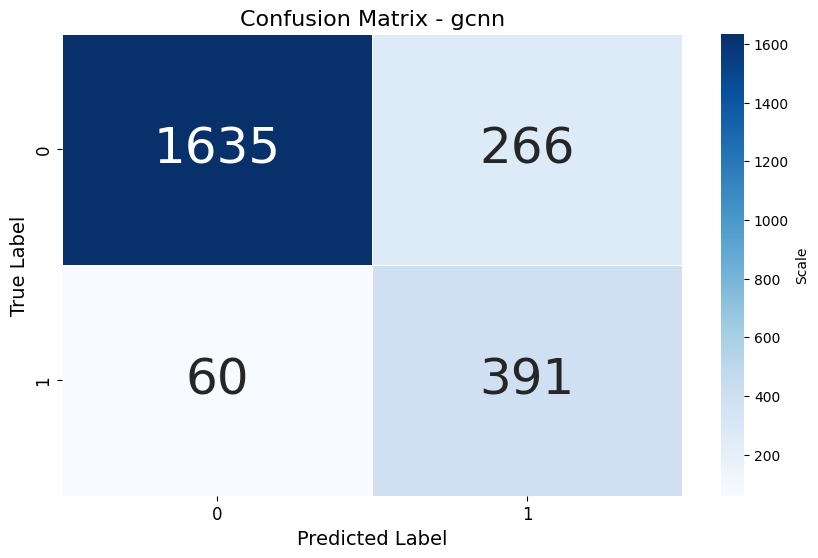

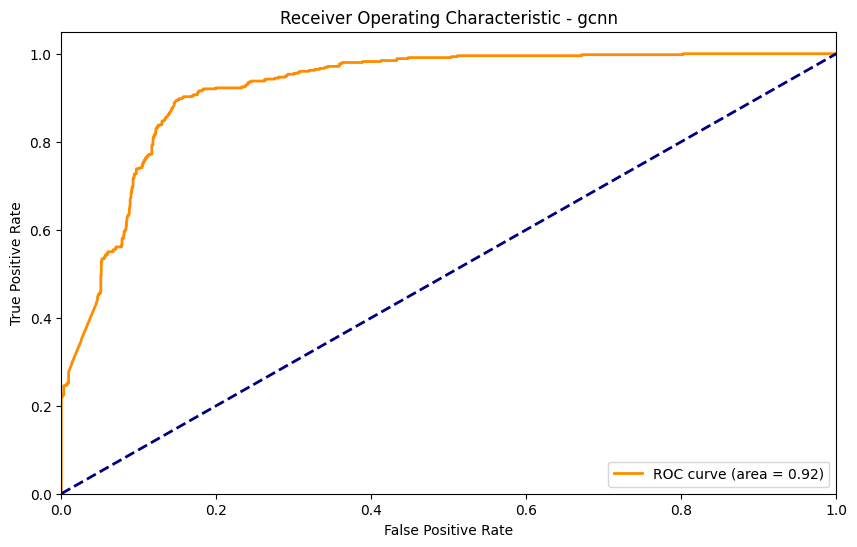

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}}
stage3_data_cleaning/v2\type4_label_merged_final_decoded_clean3.xlsx
type4_label_


100%|██████████████████████████████████████████████████████████████████████████████| 1334/1334 [02:11<00:00, 10.11it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 933
test_data: 401
train_data:933
test_data:401
Inside train model with class weights
Epoch 1, Loss: 0.35364140941140554
Epoch 2, Loss: 0.31720710718072953
Epoch 3, Loss: 0.2147541447232167
Epoch 4, Loss: 0.18538735397160053
Epoch 5, Loss: 0.20600792728364467
Epoch 6, Loss: 0.19254748225212098
Epoch 7, Loss: 0.23224325217306613
Epoch 8, Loss: 0.16986555121839048
Epoch 9, Loss: 0.18901683650910855
Epoch 10, Loss: 0.17571387703840932
Epoch 11, Loss: 0.1761261966700355
Epoch 12, Loss: 0.16636902298778294
Epoch 13, Loss: 0.20336242094635965
Epoch 14, Loss: 0.1383927671859662
Epoch 15, Loss: 0.1341807887579004
Epoch 16, Loss: 0.17772336937487127
Epoch 17, Loss: 0.14604262486100197
Epoch 18, Loss: 0.16968143153935672
Epoch 19, Loss: 0.2580167480433981
Epoch 20, Loss: 0.16523712171862523
Epoch 21, Loss: 0.1659429743885994
Epoch 22, Loss: 0.1414055754741033
Epoch 23, Loss: 0.12838698712488014
Epoch 24, Loss: 0.1733850993216038
Epoch 25, Loss: 0.1764356356735031
Epoch 26, Loss: 0.16

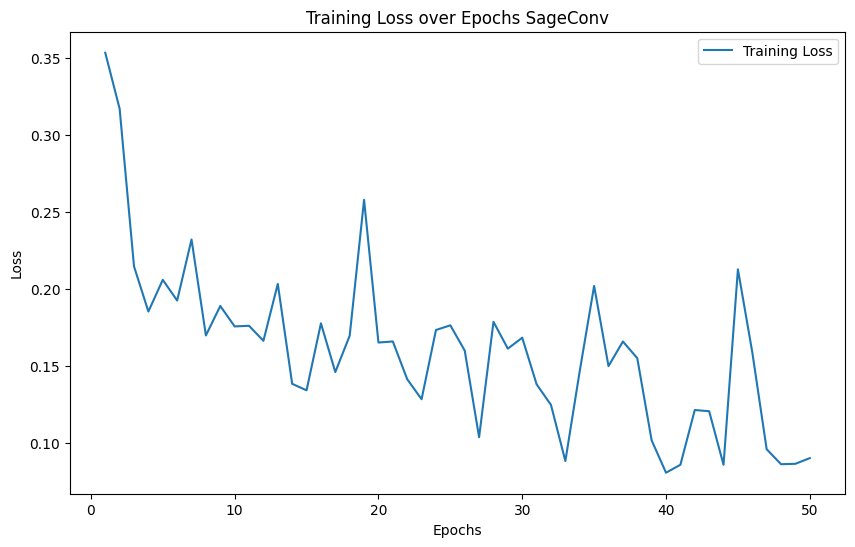

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2342
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2342
   macro avg       0.50      0.50      0.50      2342
weighted avg       1.00      1.00      1.00      2342



C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

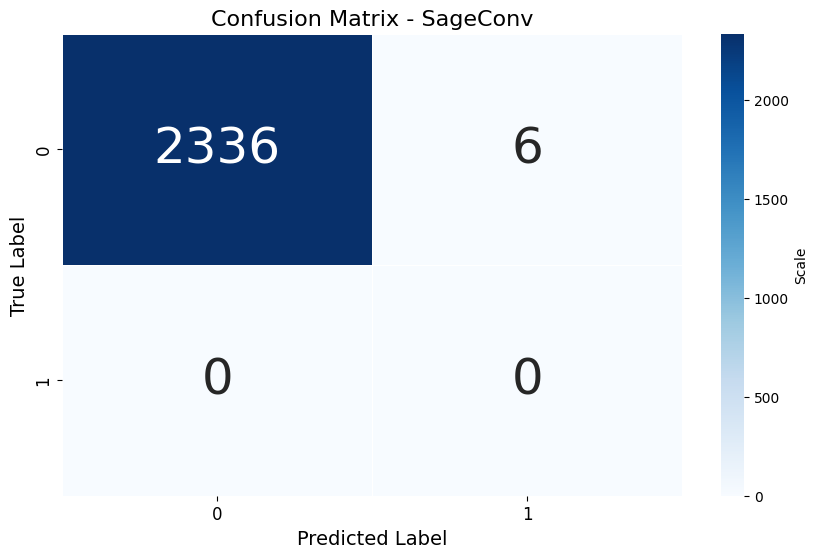

C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


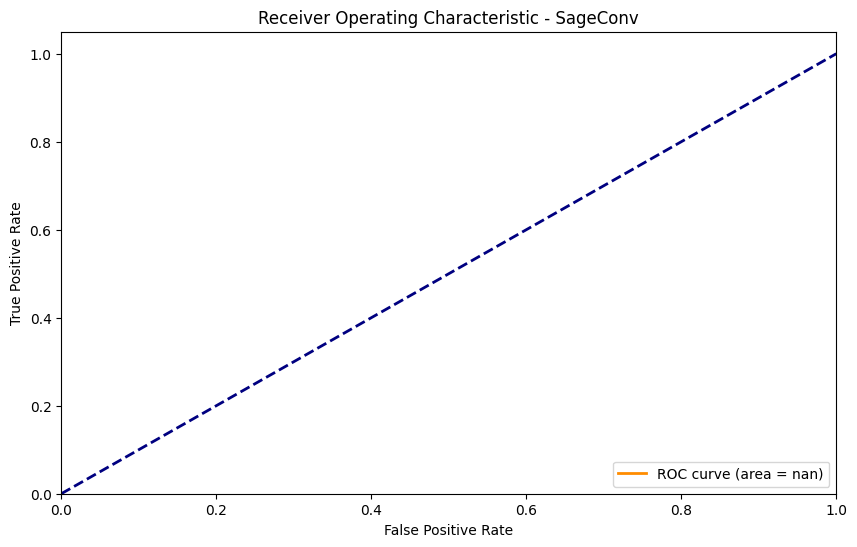

Inside train model with class weights
Epoch 1, Loss: 0.5122495671113332
Epoch 2, Loss: 0.30395662573476634
Epoch 3, Loss: 0.28401301950216296
Epoch 4, Loss: 0.27115911357104777
Epoch 5, Loss: 0.2739698556562265
Epoch 6, Loss: 0.25555925915638605
Epoch 7, Loss: 0.25411470209558806
Epoch 8, Loss: 0.2438353999207417
Epoch 9, Loss: 0.22505114376544952
Epoch 10, Loss: 0.2410377054164807
Epoch 11, Loss: 0.2529316281278928
Epoch 12, Loss: 0.23486598966022332
Epoch 13, Loss: 0.22955155620972315
Epoch 14, Loss: 0.21948013752698897
Epoch 15, Loss: 0.2438768812765678
Epoch 16, Loss: 0.21728718342880407
Epoch 17, Loss: 0.23407508147259554
Epoch 18, Loss: 0.2178089855859677
Epoch 19, Loss: 0.1987263442327579
Epoch 20, Loss: 0.20468504192928474
Epoch 21, Loss: 0.1843571479121844
Epoch 22, Loss: 0.1838940645257632
Epoch 23, Loss: 0.1806391963114341
Epoch 24, Loss: 0.15574223436415197
Epoch 25, Loss: 0.17423958281675975
Epoch 26, Loss: 0.15968728040655453
Epoch 27, Loss: 0.16842326236267885
Epoch 28, 

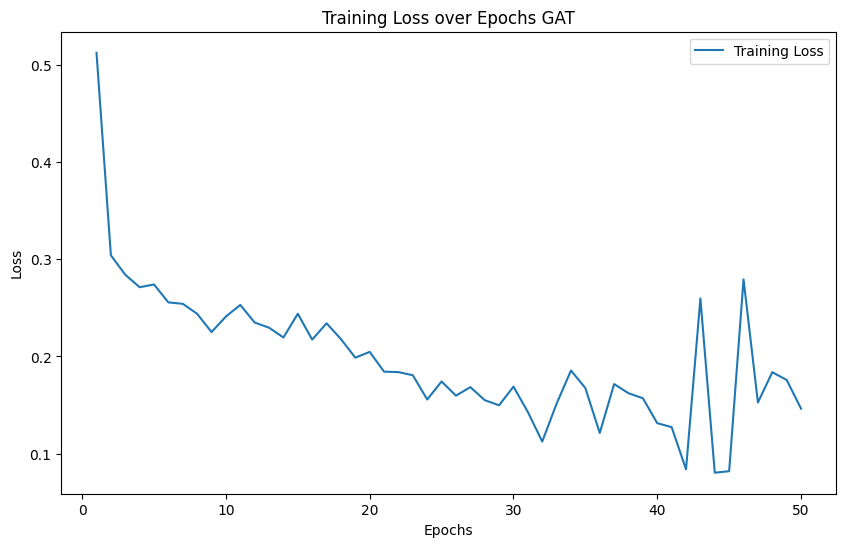

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2342
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2342
   macro avg       0.50      0.50      0.50      2342
weighted avg       1.00      1.00      1.00      2342



C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

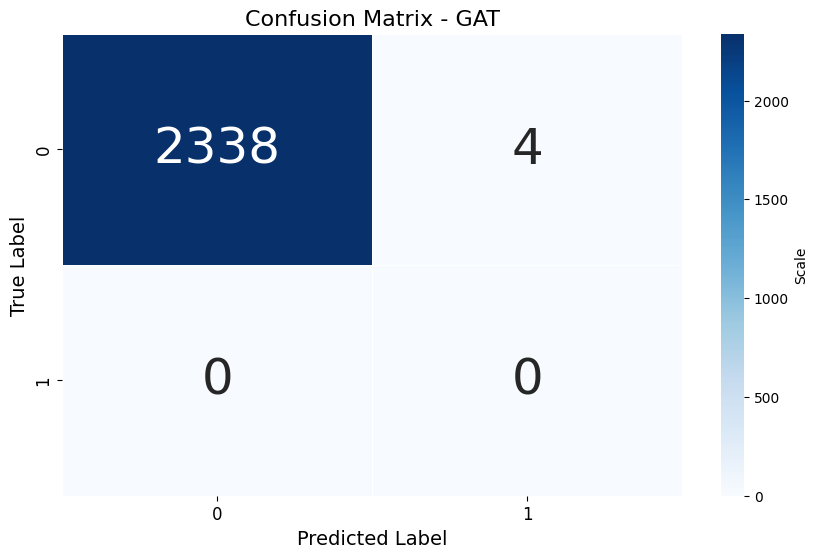

C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


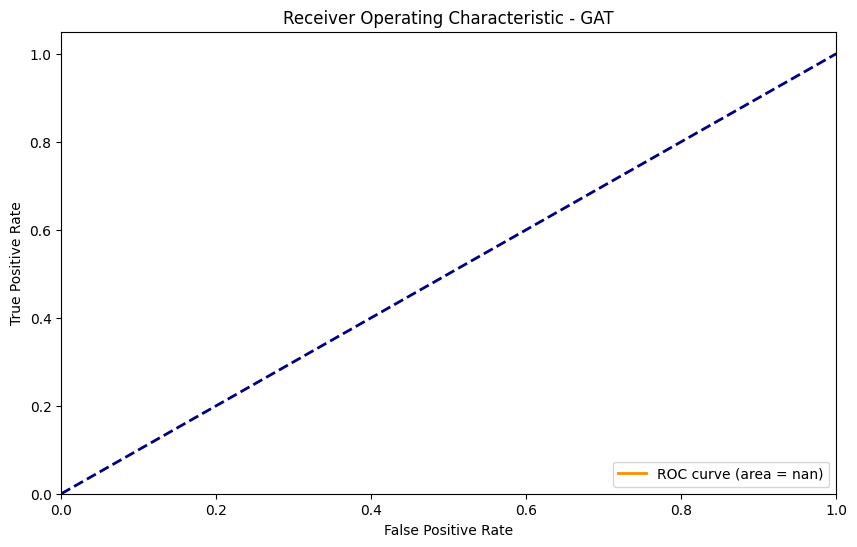

Inside train model with class weights
Epoch 1, Loss: 0.40394938504323363
Epoch 2, Loss: 0.23049276458720366
Epoch 3, Loss: 0.25107773716251053
Epoch 4, Loss: 0.22891448798278968
Epoch 5, Loss: 0.17316155961404245
Epoch 6, Loss: 0.2828834811846415
Epoch 7, Loss: 0.20462130804856618
Epoch 8, Loss: 0.18590721438328425
Epoch 9, Loss: 0.23384648623565832
Epoch 10, Loss: 0.1931294322013855
Epoch 11, Loss: 0.19134594375888506
Epoch 12, Loss: 0.18389675927658874
Epoch 13, Loss: 0.14399301931262015
Epoch 14, Loss: 0.1760849992434184
Epoch 15, Loss: 0.18682722486555575
Epoch 16, Loss: 0.21230663818617662
Epoch 17, Loss: 0.14139044620096683
Epoch 18, Loss: 0.1608094798400998
Epoch 19, Loss: 0.15607249004145463
Epoch 20, Loss: 0.12650761182109516
Epoch 21, Loss: 0.1681046074256301
Epoch 22, Loss: 0.17107214344044527
Epoch 23, Loss: 0.16397175608823697
Epoch 24, Loss: 0.12662966996431352
Epoch 25, Loss: 0.11963581951955954
Epoch 26, Loss: 0.15529005539913973
Epoch 27, Loss: 0.09876422453671693
Epoc

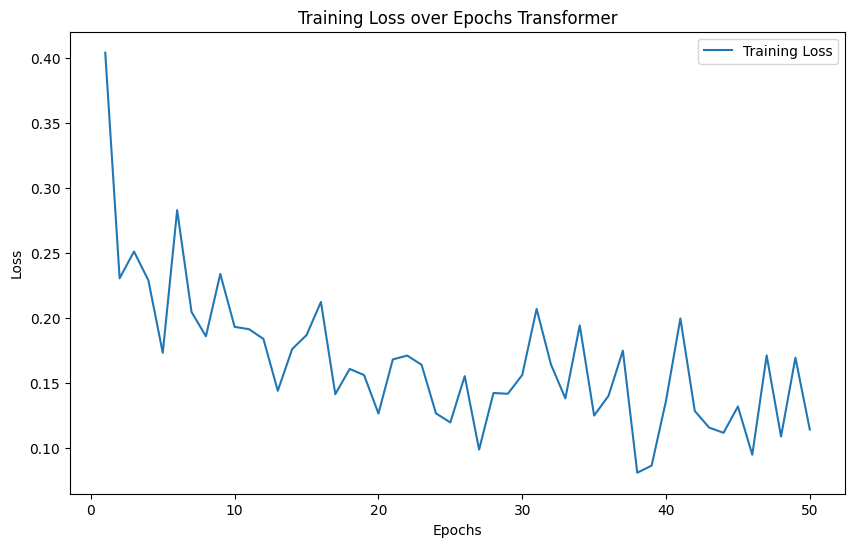

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2342
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2342
   macro avg       0.50      0.50      0.50      2342
weighted avg       1.00      1.00      1.00      2342



C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

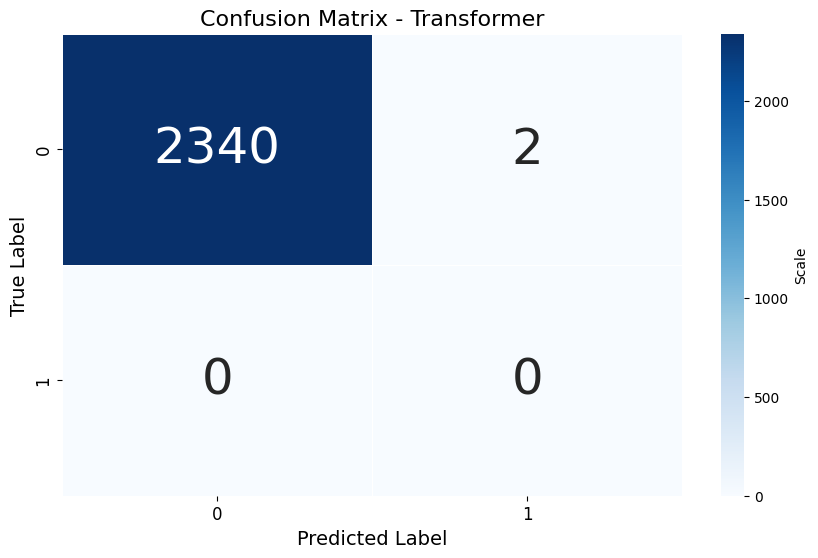

C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


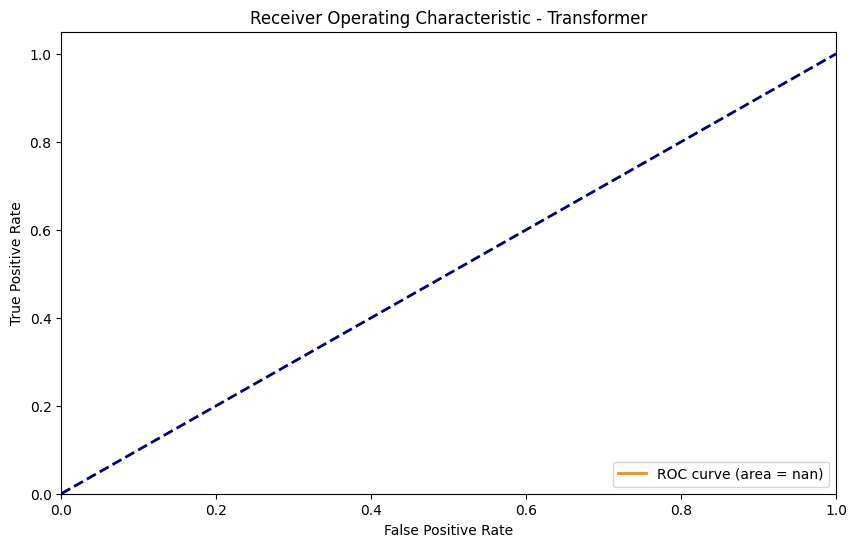

Inside train model with class weights
Epoch 1, Loss: 0.5582666640480359
Epoch 2, Loss: 0.3221537691851457
Epoch 3, Loss: 0.29218622768918673
Epoch 4, Loss: 0.27420341422160466
Epoch 5, Loss: 0.27673677653074263
Epoch 6, Loss: 0.26790954830745856
Epoch 7, Loss: 0.27183368131518365
Epoch 8, Loss: 0.25282206311821936
Epoch 9, Loss: 0.2515220925211906
Epoch 10, Loss: 0.24162395981450877
Epoch 11, Loss: 0.2283141429225604
Epoch 12, Loss: 0.24849211598436038
Epoch 13, Loss: 0.22653961839775244
Epoch 14, Loss: 0.23142753454546133
Epoch 15, Loss: 0.21279791444540025
Epoch 16, Loss: 0.20362971673409144
Epoch 17, Loss: 0.2496853883067767
Epoch 18, Loss: 0.2238307323306799
Epoch 19, Loss: 0.22466984552641708
Epoch 20, Loss: 0.22042276710271835
Epoch 21, Loss: 0.18896589266757172
Epoch 22, Loss: 0.20587383943299453
Epoch 23, Loss: 0.2111757996181647
Epoch 24, Loss: 0.19371124940613907
Epoch 25, Loss: 0.17473678899308046
Epoch 26, Loss: 0.17426052453617255
Epoch 27, Loss: 0.15995684241255123
Epoch 

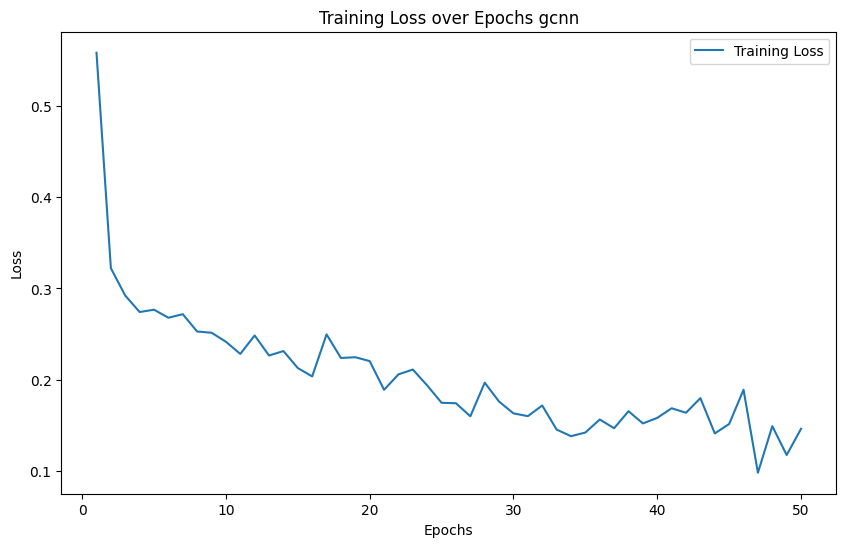

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2342
           1       0.00      0.00      0.00         0

    accuracy                           1.00      2342
   macro avg       0.50      0.50      0.50      2342
weighted avg       1.00      1.00      1.00      2342



C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-define

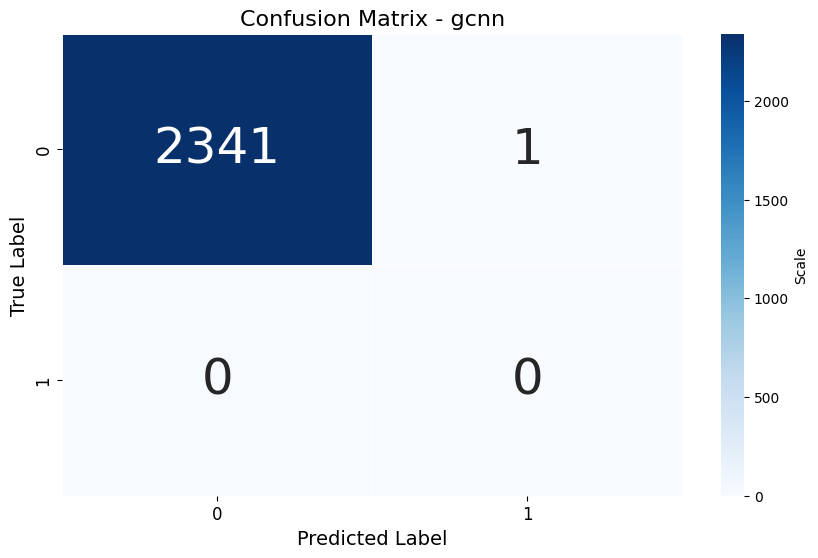

C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


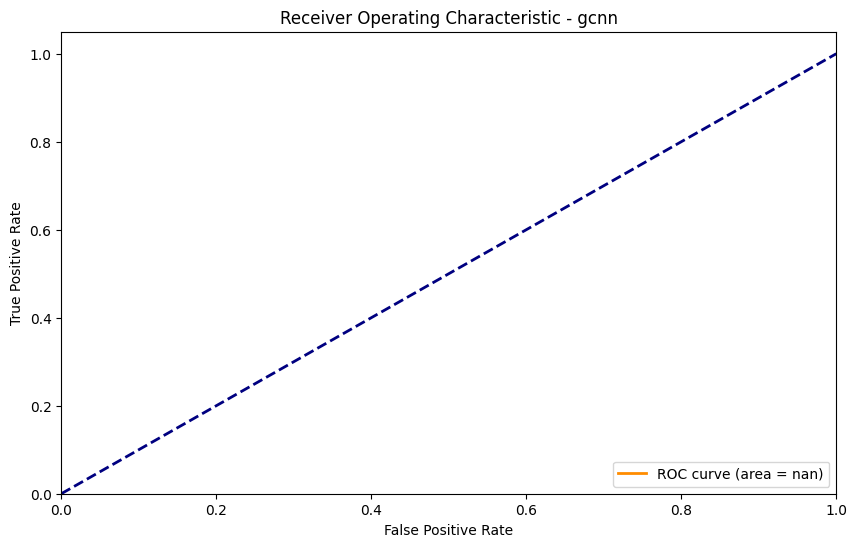

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}}
stage3_data_cleaning/v2\type5_label_merged_final_decoded_clean3.xlsx
type5_label_


100%|██████████████████████████████████████████████████████████████████████████████| 1807/1807 [02:56<00:00, 10.21it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1264
test_data: 543
train_data:1264
test_data:543
Inside train model with class weights
Epoch 1, Loss: 0.5181732520461082
Epoch 2, Loss: 0.42895119935274123
Epoch 3, Loss: 0.4161049723625183
Epoch 4, Loss: 0.40572878122329714
Epoch 5, Loss: 0.387822537869215
Epoch 6, Loss: 0.3664633024483919
Epoch 7, Loss: 0.35789222940802573
Epoch 8, Loss: 0.3738646537065506
Epoch 9, Loss: 0.35054390877485275
Epoch 10, Loss: 0.3392640631645918
Epoch 11, Loss: 0.3433428045362234
Epoch 12, Loss: 0.3432206757366657
Epoch 13, Loss: 0.34125427938997743
Epoch 14, Loss: 0.33608689345419407
Epoch 15, Loss: 0.3489778693765402
Epoch 16, Loss: 0.33051317632198335
Epoch 17, Loss: 0.3197826027870178
Epoch 18, Loss: 0.3326376583427191
Epoch 19, Loss: 0.3107353489845991
Epoch 20, Loss: 0.31894888654351233
Epoch 21, Loss: 0.31645177863538265
Epoch 22, Loss: 0.32060345374047755
Epoch 23, Loss: 0.3205438118427992
Epoch 24, Loss: 0.3120162893086672
Epoch 25, Loss: 0.3150016572326422
Epoch 26, Loss: 0.3108915

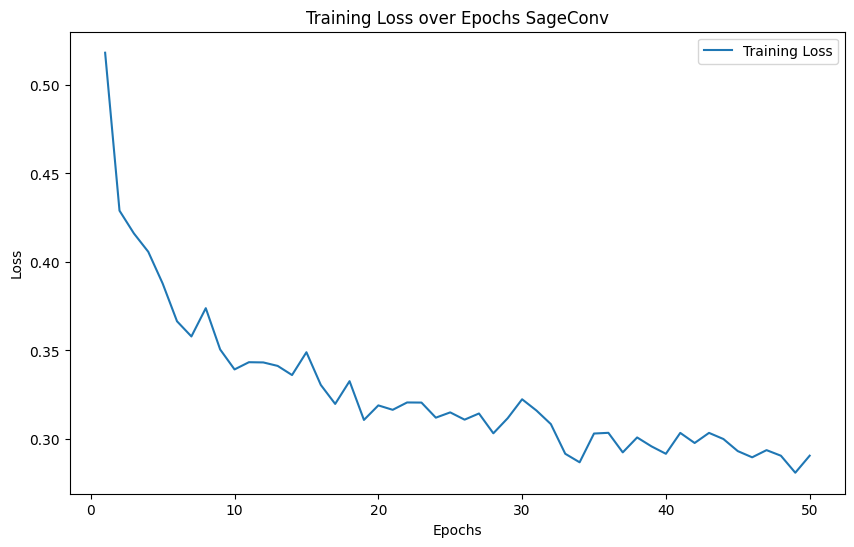

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      2966
           1       0.11      0.94      0.20        67

    accuracy                           0.84      3033
   macro avg       0.56      0.89      0.56      3033
weighted avg       0.98      0.84      0.89      3033



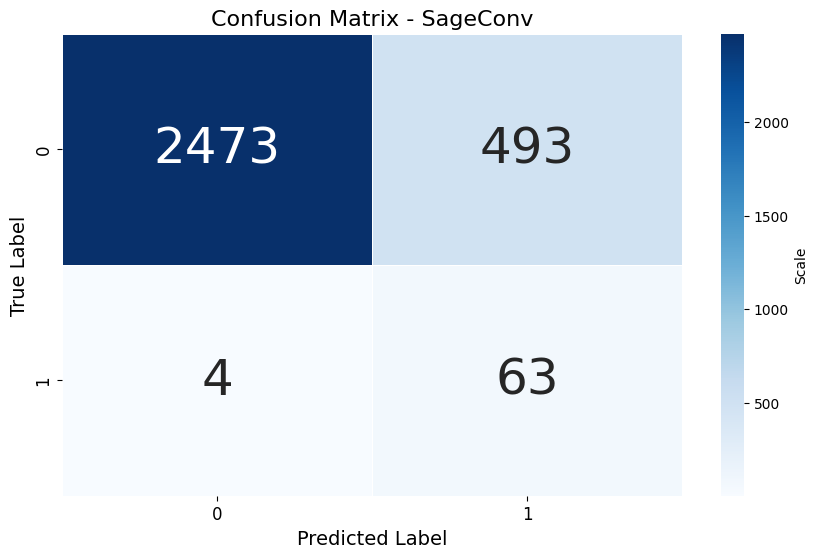

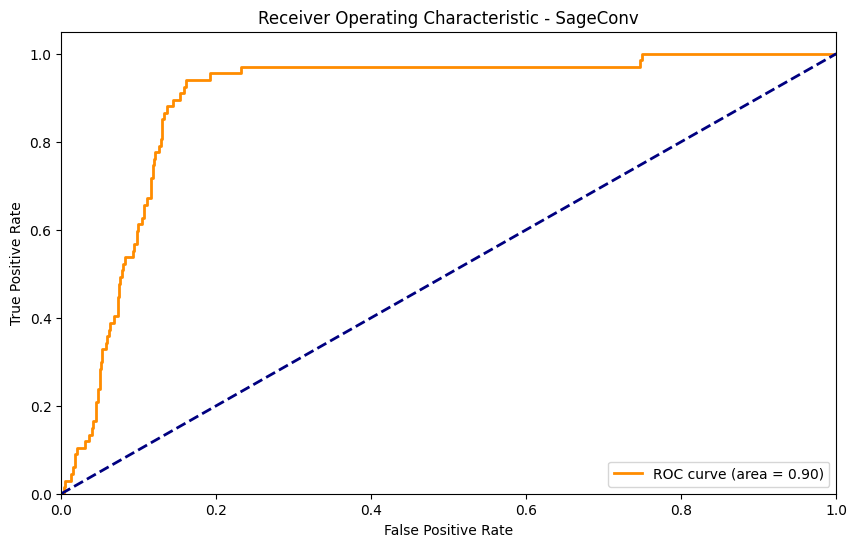

Inside train model with class weights
Epoch 1, Loss: 0.6943190634250641
Epoch 2, Loss: 0.6894020795822143
Epoch 3, Loss: 0.6812528356909752
Epoch 4, Loss: 0.6600636050105095
Epoch 5, Loss: 0.6299611240625381
Epoch 6, Loss: 0.5954471372067929
Epoch 7, Loss: 0.5789995059370995
Epoch 8, Loss: 0.5624463096261024
Epoch 9, Loss: 0.5572931915521622
Epoch 10, Loss: 0.5482563242316246
Epoch 11, Loss: 0.5468094766139984
Epoch 12, Loss: 0.5338073618710041
Epoch 13, Loss: 0.5352281957864762
Epoch 14, Loss: 0.5355917572975158
Epoch 15, Loss: 0.5154028616845607
Epoch 16, Loss: 0.5235380858182908
Epoch 17, Loss: 0.5293146148324013
Epoch 18, Loss: 0.5216923356056213
Epoch 19, Loss: 0.5102676771581173
Epoch 20, Loss: 0.5008176550269127
Epoch 21, Loss: 0.4953302629292011
Epoch 22, Loss: 0.5054049327969551
Epoch 23, Loss: 0.49631613567471505
Epoch 24, Loss: 0.4946789890527725
Epoch 25, Loss: 0.5196269750595093
Epoch 26, Loss: 0.518977838754654
Epoch 27, Loss: 0.4994482234120369
Epoch 28, Loss: 0.49001905

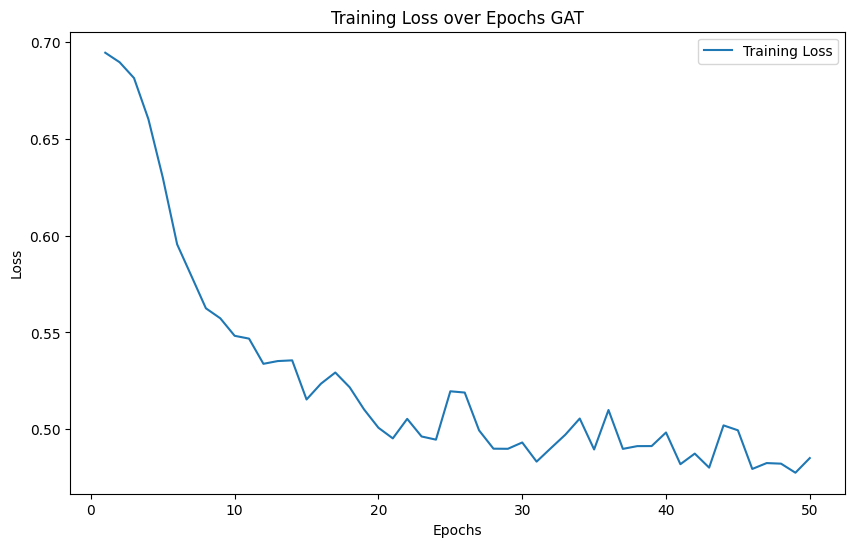

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2966
           1       0.08      0.61      0.15        67

    accuracy                           0.84      3033
   macro avg       0.54      0.73      0.53      3033
weighted avg       0.97      0.84      0.90      3033



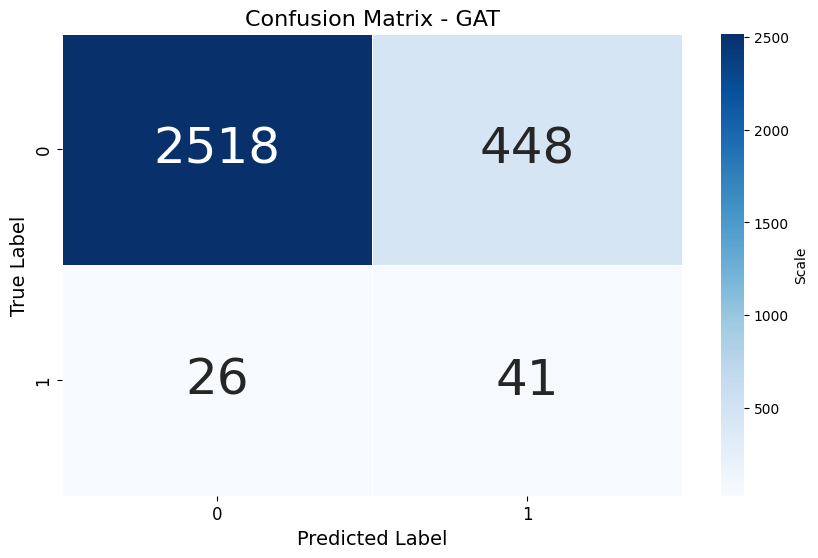

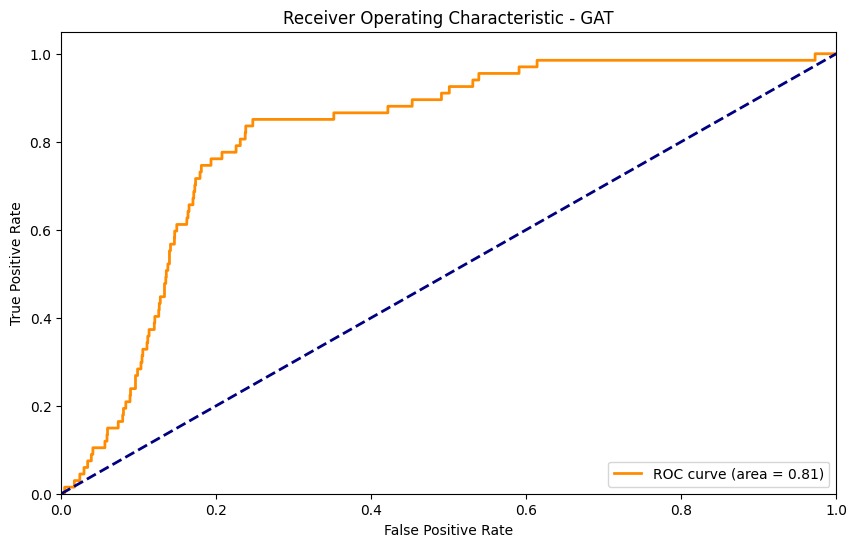

Inside train model with class weights
Epoch 1, Loss: 0.5110837176442147
Epoch 2, Loss: 0.4302243232727051
Epoch 3, Loss: 0.4274760399013758
Epoch 4, Loss: 0.4082003690302372
Epoch 5, Loss: 0.39416130930185317
Epoch 6, Loss: 0.38622895888984204
Epoch 7, Loss: 0.36634477488696576
Epoch 8, Loss: 0.35595232546329497
Epoch 9, Loss: 0.36239021047949793
Epoch 10, Loss: 0.3420845128595829
Epoch 11, Loss: 0.3290330972522497
Epoch 12, Loss: 0.32211422063410283
Epoch 13, Loss: 0.33664850927889345
Epoch 14, Loss: 0.3335932347923517
Epoch 15, Loss: 0.32342949472367766
Epoch 16, Loss: 0.3197591319680214
Epoch 17, Loss: 0.3104199431836605
Epoch 18, Loss: 0.3113850675523281
Epoch 19, Loss: 0.31488811895251273
Epoch 20, Loss: 0.3111185010522604
Epoch 21, Loss: 0.30416319854557516
Epoch 22, Loss: 0.30790093541145325
Epoch 23, Loss: 0.2959921233355999
Epoch 24, Loss: 0.30330172292888163
Epoch 25, Loss: 0.30502095595002177
Epoch 26, Loss: 0.3017784744501114
Epoch 27, Loss: 0.29584282338619233
Epoch 28, Lo

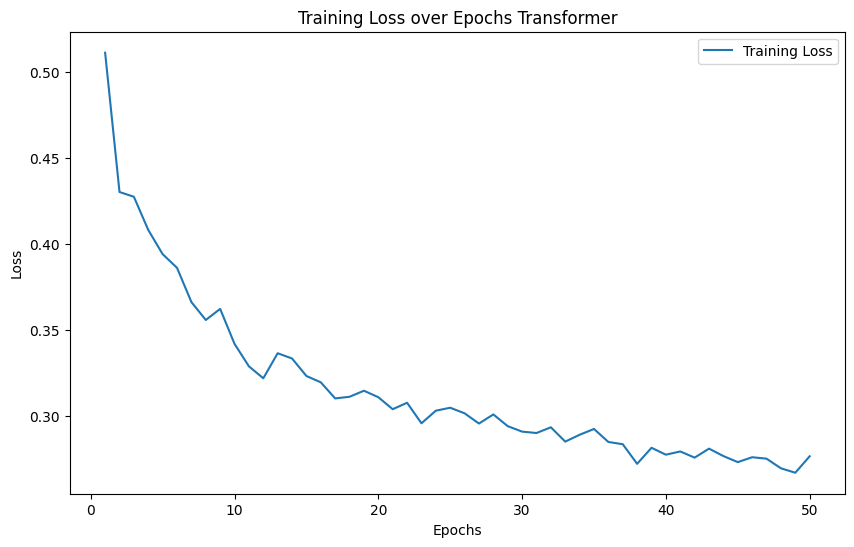

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2966
           1       0.12      0.96      0.21        67

    accuracy                           0.84      3033
   macro avg       0.56      0.90      0.56      3033
weighted avg       0.98      0.84      0.90      3033



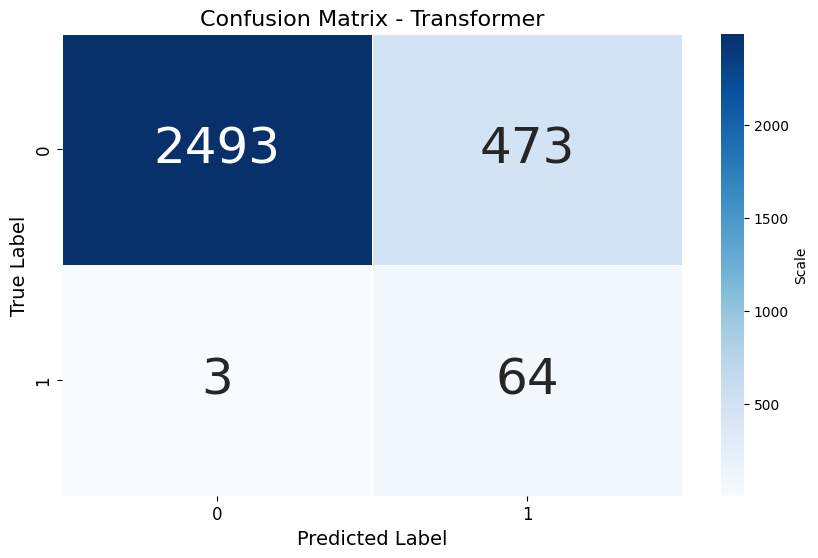

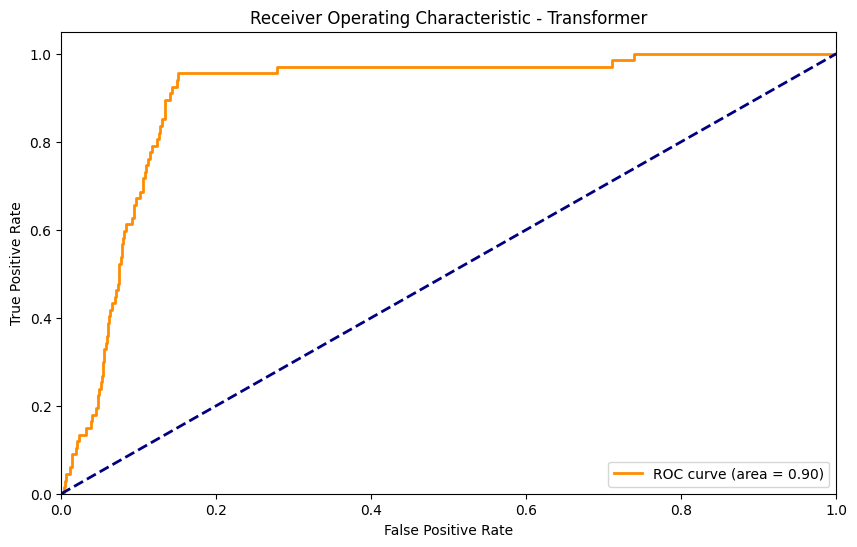

Inside train model with class weights
Epoch 1, Loss: 0.6825089260935784
Epoch 2, Loss: 0.6524689003825188
Epoch 3, Loss: 0.6085227519273758
Epoch 4, Loss: 0.5483600541949272
Epoch 5, Loss: 0.49617728888988494
Epoch 6, Loss: 0.473962514847517
Epoch 7, Loss: 0.4604767210781574
Epoch 8, Loss: 0.4438484229147434
Epoch 9, Loss: 0.4437859244644642
Epoch 10, Loss: 0.44049602225422857
Epoch 11, Loss: 0.4282536990940571
Epoch 12, Loss: 0.4268784590065479
Epoch 13, Loss: 0.43809979483485223
Epoch 14, Loss: 0.4331039473414421
Epoch 15, Loss: 0.42667847983539103
Epoch 16, Loss: 0.43670764826238156
Epoch 17, Loss: 0.43191509172320364
Epoch 18, Loss: 0.42927992306649687
Epoch 19, Loss: 0.4166429370641708
Epoch 20, Loss: 0.43050405085086824
Epoch 21, Loss: 0.42849321775138377
Epoch 22, Loss: 0.412452244758606
Epoch 23, Loss: 0.4229479178786278
Epoch 24, Loss: 0.4337305296212435
Epoch 25, Loss: 0.4111224438995123
Epoch 26, Loss: 0.407901456207037
Epoch 27, Loss: 0.42307199724018574
Epoch 28, Loss: 0.4

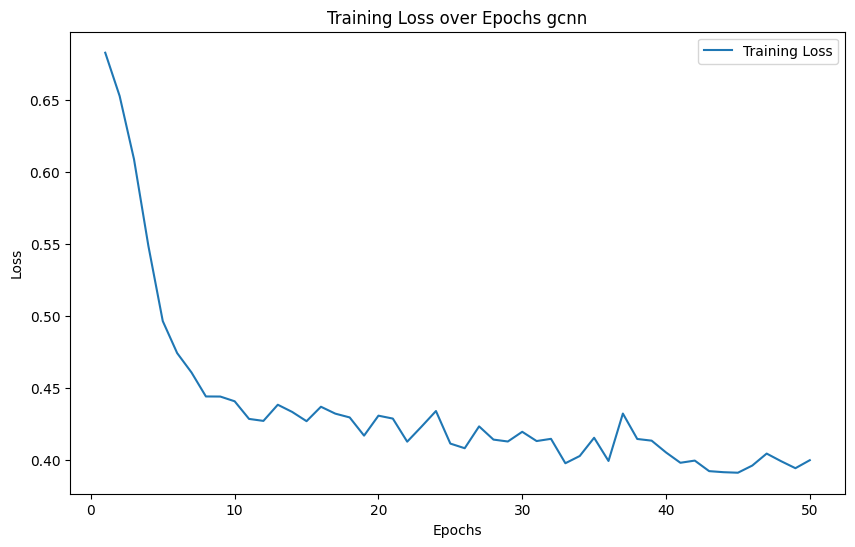

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      2966
           1       0.09      0.84      0.16        67

    accuracy                           0.80      3033
   macro avg       0.54      0.82      0.52      3033
weighted avg       0.98      0.80      0.87      3033



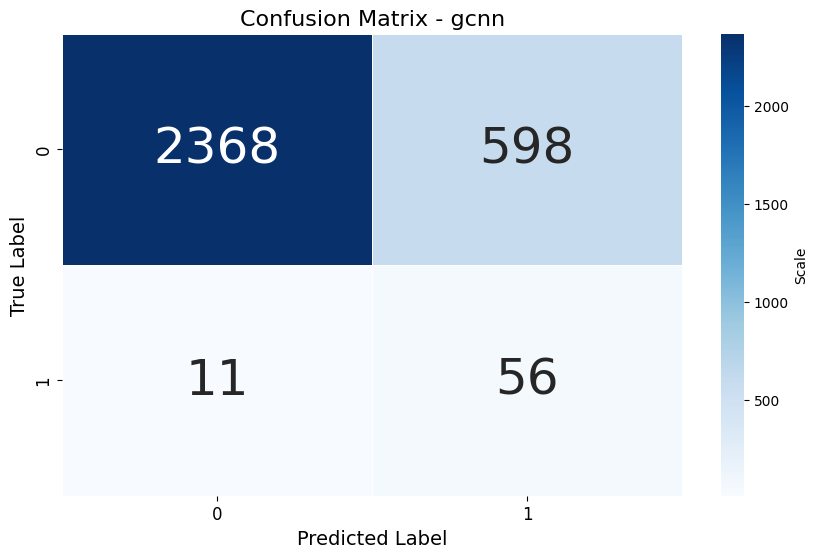

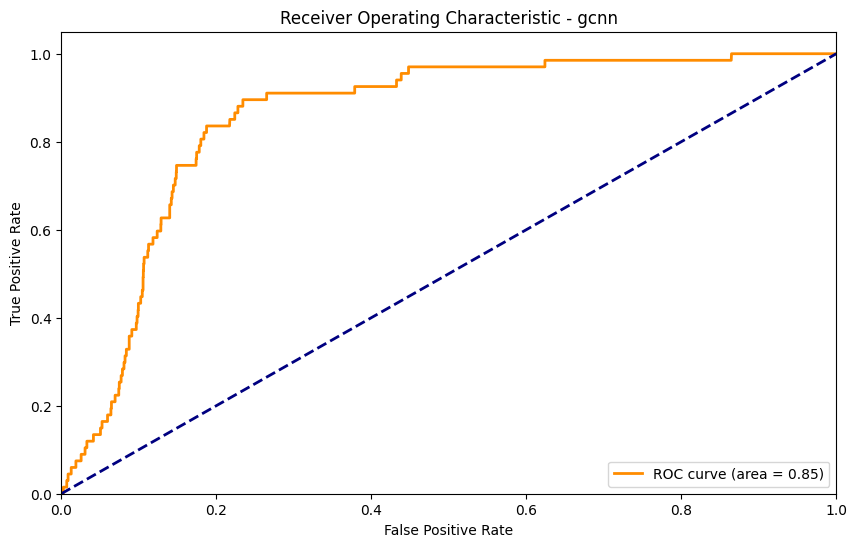

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}, 'type5_label_': {'GSageConv': 0.8361358391031981, 'GAT': 0.8437190900098912, 'GTransformer': 0.8430596768875701, 'GCNN': 0.7992087042532147}}
stage3_data_cleaning/v2\type6_label_merged_final_decoded_clean3.xlsx
type6_label_


100%|██████████████████████████████████████████████████████████████████████████████| 2414/2414 [03:54<00:00, 10.30it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1689
test_data: 725
train_data:1689
test_data:725
Inside train model with class weights
Epoch 1, Loss: 0.32272327733489703
Epoch 2, Loss: 0.21805332010647036
Epoch 3, Loss: 0.21142384353673682
Epoch 4, Loss: 0.20893890987027366
Epoch 5, Loss: 0.204929012172627
Epoch 6, Loss: 0.20140840099105295
Epoch 7, Loss: 0.1971069245405917
Epoch 8, Loss: 0.195466030599936
Epoch 9, Loss: 0.1943931020093414
Epoch 10, Loss: 0.19120680850069477
Epoch 11, Loss: 0.190311221862739
Epoch 12, Loss: 0.18457169282548833
Epoch 13, Loss: 0.18811651867515636
Epoch 14, Loss: 0.18955404522284022
Epoch 15, Loss: 0.18367199515396693
Epoch 16, Loss: 0.18206867955203326
Epoch 17, Loss: 0.18093673420964546
Epoch 18, Loss: 0.1825156404443507
Epoch 19, Loss: 0.18220959322632485
Epoch 20, Loss: 0.18145403814203334
Epoch 21, Loss: 0.17992502113558212
Epoch 22, Loss: 0.1790206494196406
Epoch 23, Loss: 0.17698365421789997
Epoch 24, Loss: 0.17744107263268166
Epoch 25, Loss: 0.1770876408466753
Epoch 26, Loss: 0.17

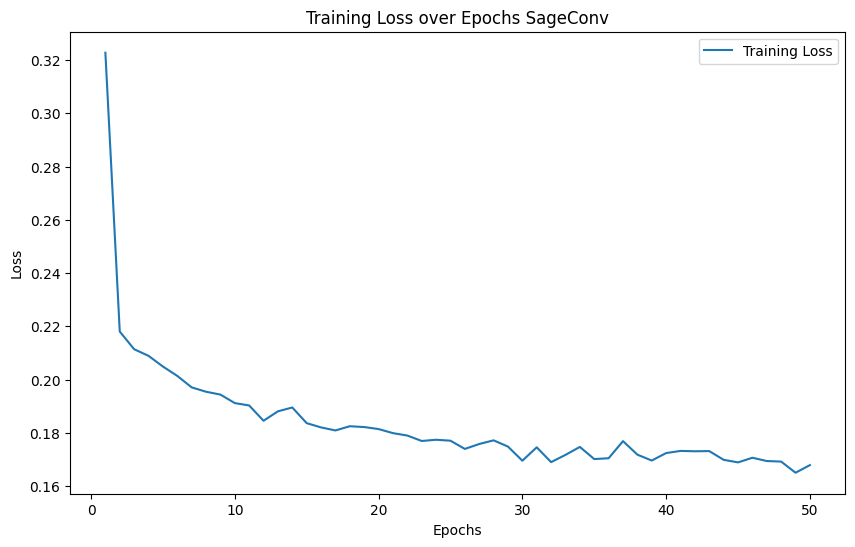

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3729
           1       0.58      0.98      0.73       396

    accuracy                           0.93      4125
   macro avg       0.79      0.95      0.84      4125
weighted avg       0.96      0.93      0.94      4125



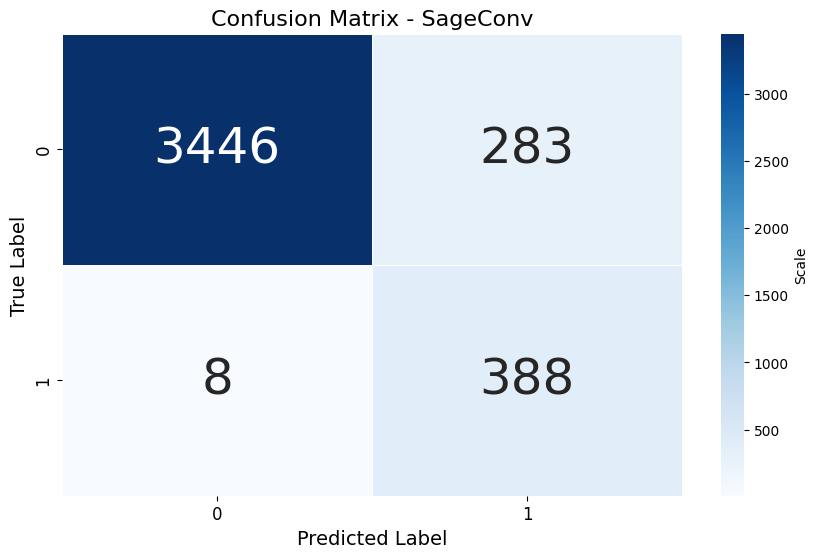

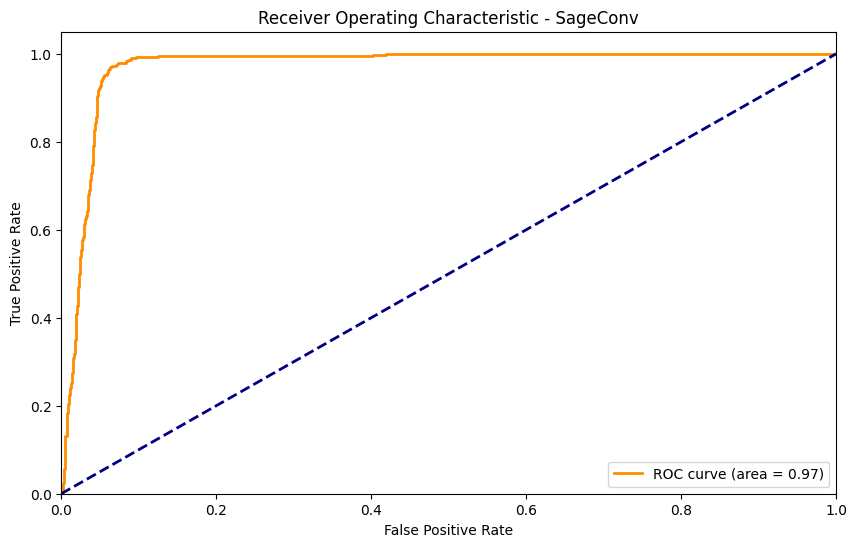

Inside train model with class weights
Epoch 1, Loss: 0.692292035750623
Epoch 2, Loss: 0.6836826385192152
Epoch 3, Loss: 0.6340847262796366
Epoch 4, Loss: 0.5668431779123703
Epoch 5, Loss: 0.5387614734892575
Epoch 6, Loss: 0.5269317407653017
Epoch 7, Loss: 0.5154953548368418
Epoch 8, Loss: 0.5106389258267745
Epoch 9, Loss: 0.5080393192903051
Epoch 10, Loss: 0.5007908855969051
Epoch 11, Loss: 0.499753142302891
Epoch 12, Loss: 0.49554221472650206
Epoch 13, Loss: 0.49362912830316796
Epoch 14, Loss: 0.48948740115705525
Epoch 15, Loss: 0.4882911499941124
Epoch 16, Loss: 0.48564806299389535
Epoch 17, Loss: 0.48258582769699815
Epoch 18, Loss: 0.4852971198423853
Epoch 19, Loss: 0.4788383740299153
Epoch 20, Loss: 0.4790700302933747
Epoch 21, Loss: 0.47696937423832014
Epoch 22, Loss: 0.4747264188415599
Epoch 23, Loss: 0.47511881421197133
Epoch 24, Loss: 0.4734074872619701
Epoch 25, Loss: 0.4728163188358523
Epoch 26, Loss: 0.4691773366253331
Epoch 27, Loss: 0.4700015277232764
Epoch 28, Loss: 0.468

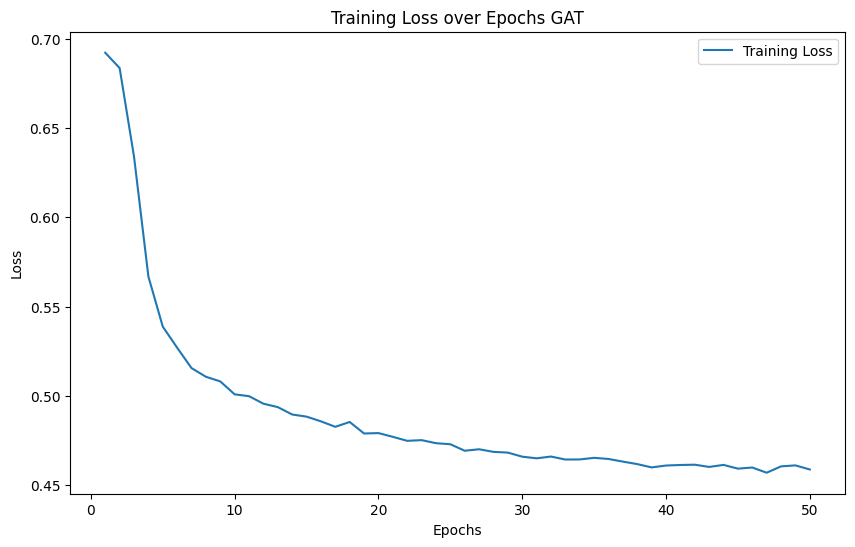

              precision    recall  f1-score   support

           0       0.99      0.67      0.80      3729
           1       0.23      0.92      0.37       396

    accuracy                           0.70      4125
   macro avg       0.61      0.80      0.58      4125
weighted avg       0.91      0.70      0.76      4125



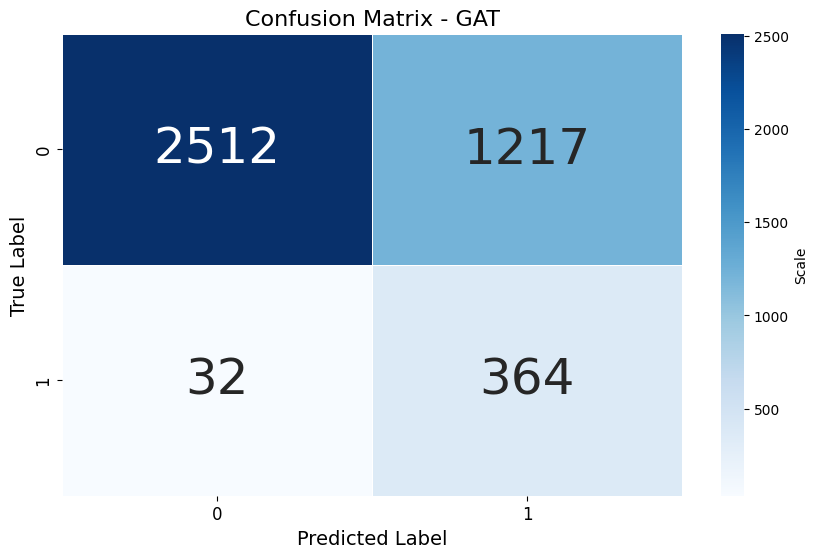

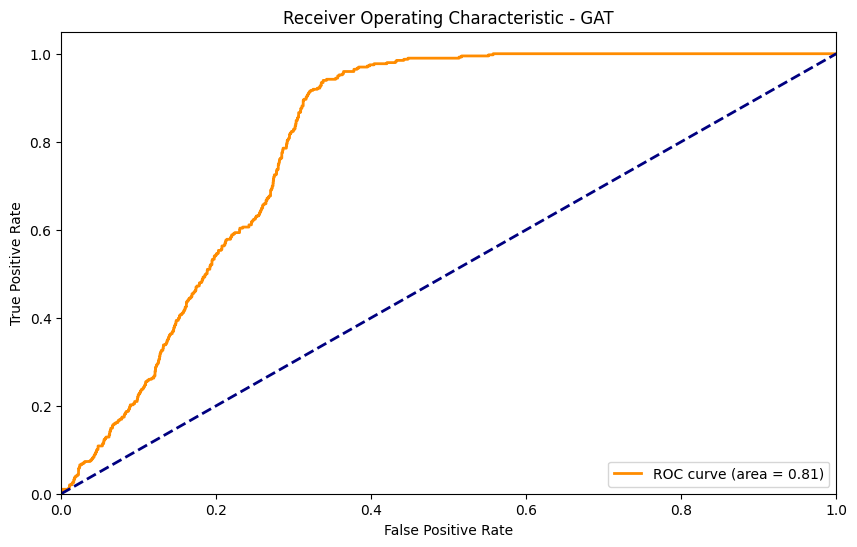

Inside train model with class weights
Epoch 1, Loss: 0.30935269256807724
Epoch 2, Loss: 0.22402310821245303
Epoch 3, Loss: 0.2167936923368922
Epoch 4, Loss: 0.2163372647087529
Epoch 5, Loss: 0.20697715681678844
Epoch 6, Loss: 0.20666187158170737
Epoch 7, Loss: 0.20218268950592796
Epoch 8, Loss: 0.20234812641481184
Epoch 9, Loss: 0.20089978527910304
Epoch 10, Loss: 0.19627365188778573
Epoch 11, Loss: 0.19927343459061855
Epoch 12, Loss: 0.19389016110942048
Epoch 13, Loss: 0.1883670265944499
Epoch 14, Loss: 0.18867101309434423
Epoch 15, Loss: 0.18632515294934218
Epoch 16, Loss: 0.18489815421261876
Epoch 17, Loss: 0.18659392786475848
Epoch 18, Loss: 0.18544039903384335
Epoch 19, Loss: 0.1803897980530307
Epoch 20, Loss: 0.17767379390743543
Epoch 21, Loss: 0.1767770934779689
Epoch 22, Loss: 0.18007788033980243
Epoch 23, Loss: 0.17260586765577207
Epoch 24, Loss: 0.1736159770275062
Epoch 25, Loss: 0.16660486513151312
Epoch 26, Loss: 0.17040081659577927
Epoch 27, Loss: 0.1706248126783461
Epoch 

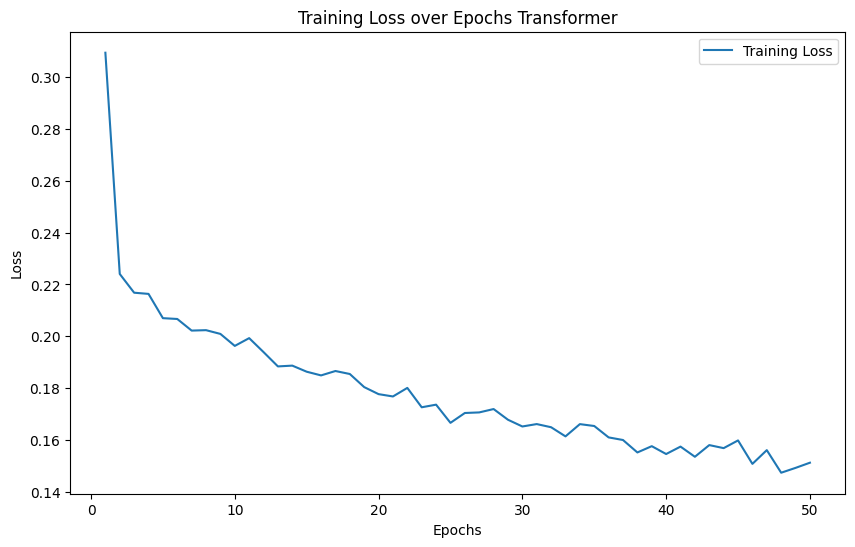

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3729
           1       0.64      0.98      0.77       396

    accuracy                           0.94      4125
   macro avg       0.82      0.96      0.87      4125
weighted avg       0.96      0.94      0.95      4125



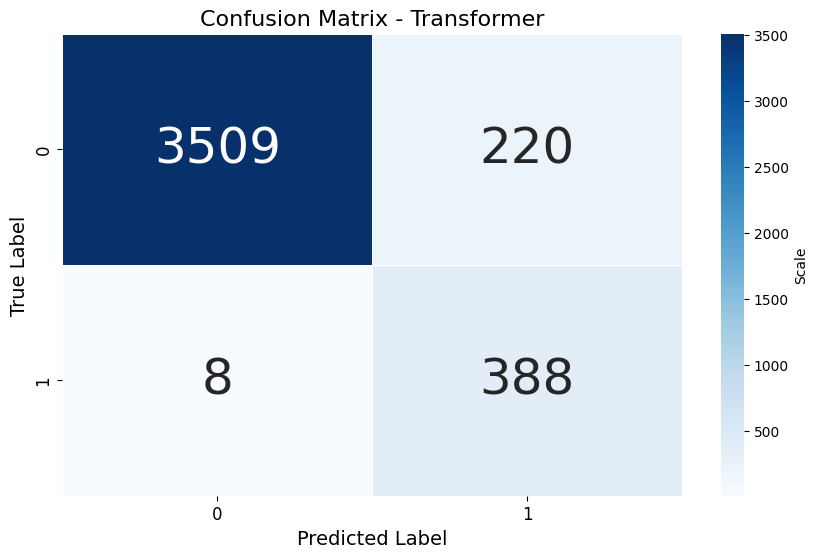

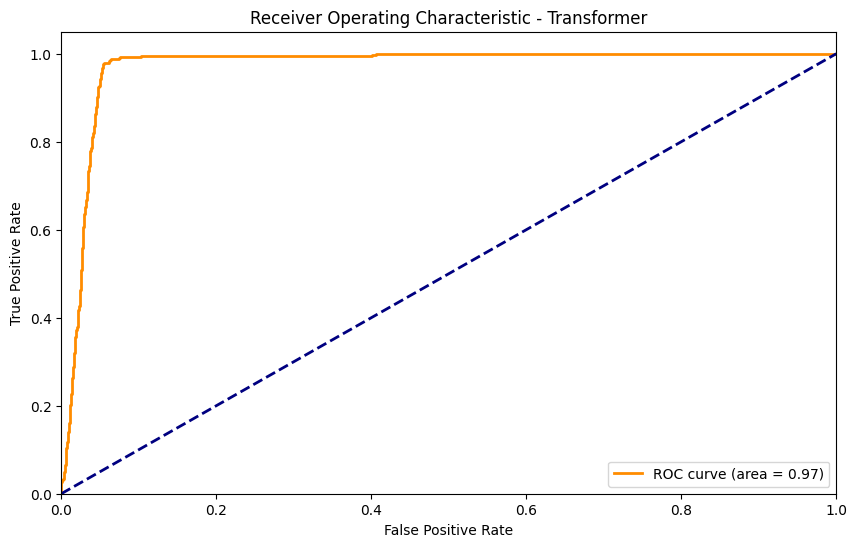

Inside train model with class weights
Epoch 1, Loss: 0.6664603026408069
Epoch 2, Loss: 0.6106005063596761
Epoch 3, Loss: 0.5285772968013331
Epoch 4, Loss: 0.4622949243716474
Epoch 5, Loss: 0.41719074462944605
Epoch 6, Loss: 0.4199632299396227
Epoch 7, Loss: 0.3994680198858369
Epoch 8, Loss: 0.40335206828027403
Epoch 9, Loss: 0.3945418005844332
Epoch 10, Loss: 0.39570419293529585
Epoch 11, Loss: 0.40382822673275787
Epoch 12, Loss: 0.3975467299515346
Epoch 13, Loss: 0.39547718302258905
Epoch 14, Loss: 0.3899122476577759
Epoch 15, Loss: 0.3926622080353071
Epoch 16, Loss: 0.38683834222127805
Epoch 17, Loss: 0.3854120272510457
Epoch 18, Loss: 0.3867164614065638
Epoch 19, Loss: 0.3827574627017075
Epoch 20, Loss: 0.3859866151832185
Epoch 21, Loss: 0.38625228967306746
Epoch 22, Loss: 0.3938345560487711
Epoch 23, Loss: 0.38405000095097525
Epoch 24, Loss: 0.38796418680334993
Epoch 25, Loss: 0.38119652248778435
Epoch 26, Loss: 0.38520362973213196
Epoch 27, Loss: 0.39042081416777846
Epoch 28, Loss

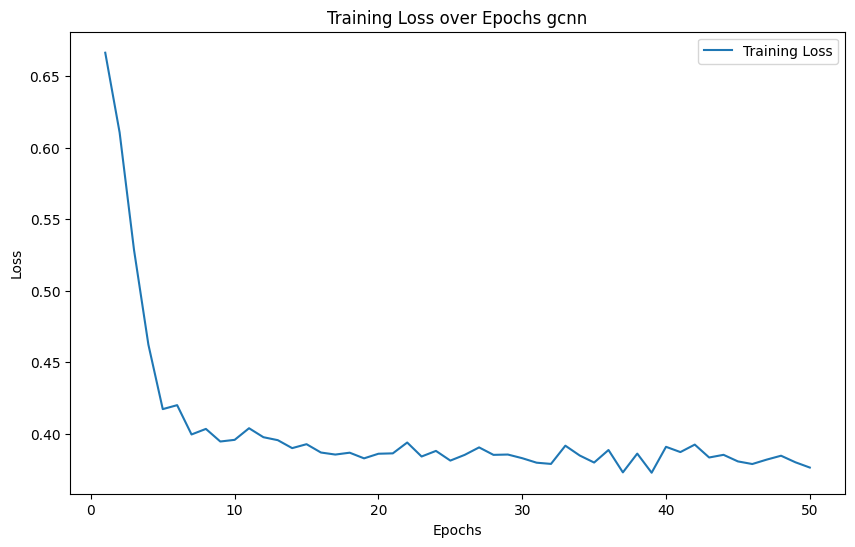

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3729
           1       0.39      0.93      0.55       396

    accuracy                           0.85      4125
   macro avg       0.69      0.89      0.73      4125
weighted avg       0.93      0.85      0.88      4125



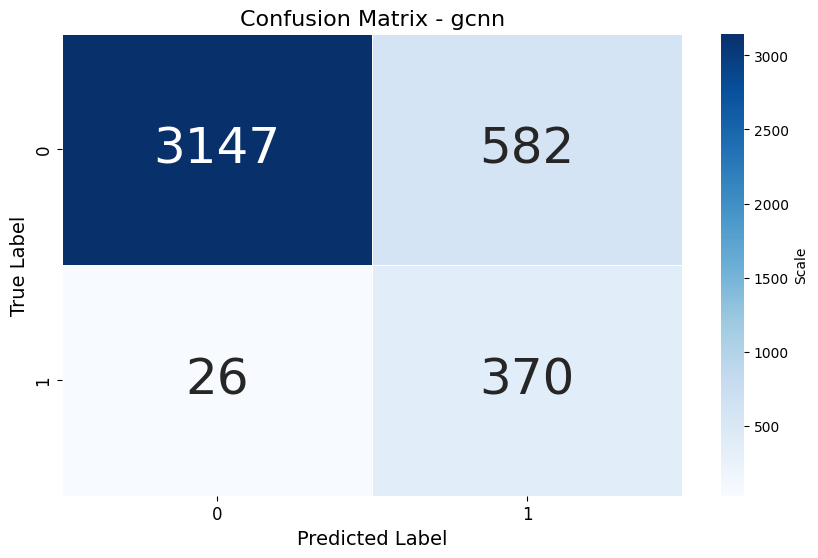

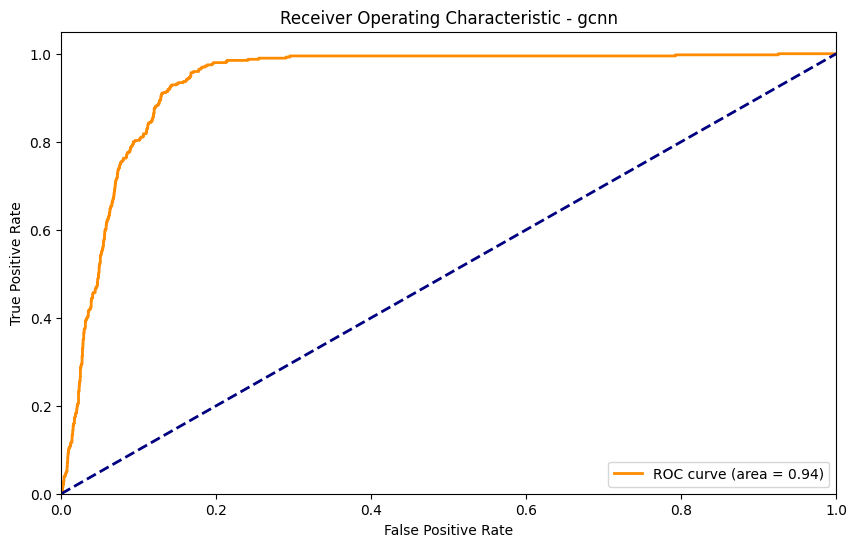

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}, 'type5_label_': {'GSageConv': 0.8361358391031981, 'GAT': 0.8437190900098912, 'GTransformer': 0.8430596768875701, 'GCNN': 0.7992087042532147}, 'type6_label_': {'GSageConv': 0.9294545454545454, 'GAT': 0.6972121212121212, 'GTransformer': 0.9447272727272727, 'GCNN': 0.8526060606060606}}
stage3_

100%|██████████████████████████████████████████████████████████████████████████████| 2342/2342 [03:33<00:00, 10.96it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1639
test_data: 703
train_data:1639
test_data:703
Inside train model with class weights
Epoch 1, Loss: 0.35416358881271803
Epoch 2, Loss: 0.2516662853841598
Epoch 3, Loss: 0.2415880638246353
Epoch 4, Loss: 0.23884140958006567
Epoch 5, Loss: 0.23231273631636912
Epoch 6, Loss: 0.22984826765381372
Epoch 7, Loss: 0.22385217937139365
Epoch 8, Loss: 0.22467868402600288
Epoch 9, Loss: 0.22280842180435473
Epoch 10, Loss: 0.21616644670183843
Epoch 11, Loss: 0.21887959339297736
Epoch 12, Loss: 0.21511917231747738
Epoch 13, Loss: 0.21852460818795058
Epoch 14, Loss: 0.21074213589040133
Epoch 15, Loss: 0.21302887754371533
Epoch 16, Loss: 0.2127457891519253
Epoch 17, Loss: 0.20714594094225994
Epoch 18, Loss: 0.20710351862586462
Epoch 19, Loss: 0.20714376093103334
Epoch 20, Loss: 0.21021417069893616
Epoch 21, Loss: 0.20366460557740468
Epoch 22, Loss: 0.20996234709253678
Epoch 23, Loss: 0.20771043188869953
Epoch 24, Loss: 0.20587544802289742
Epoch 25, Loss: 0.1973404369961757
Epoch 26, Los

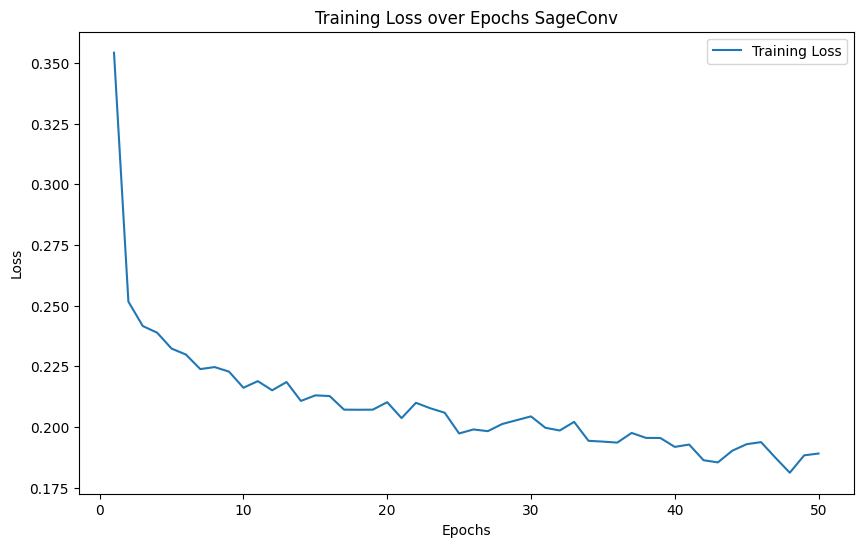

              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2628
           1       0.53      0.98      0.69       296

    accuracy                           0.91      2924
   macro avg       0.76      0.94      0.82      2924
weighted avg       0.95      0.91      0.92      2924



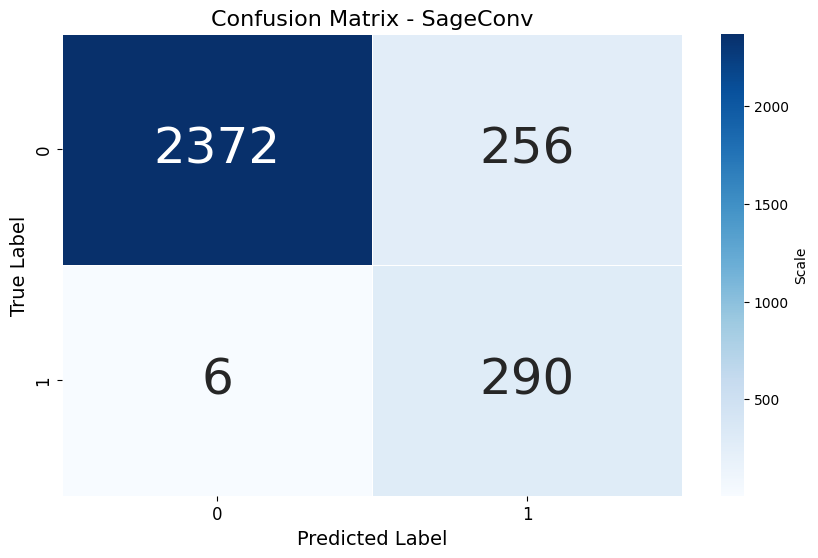

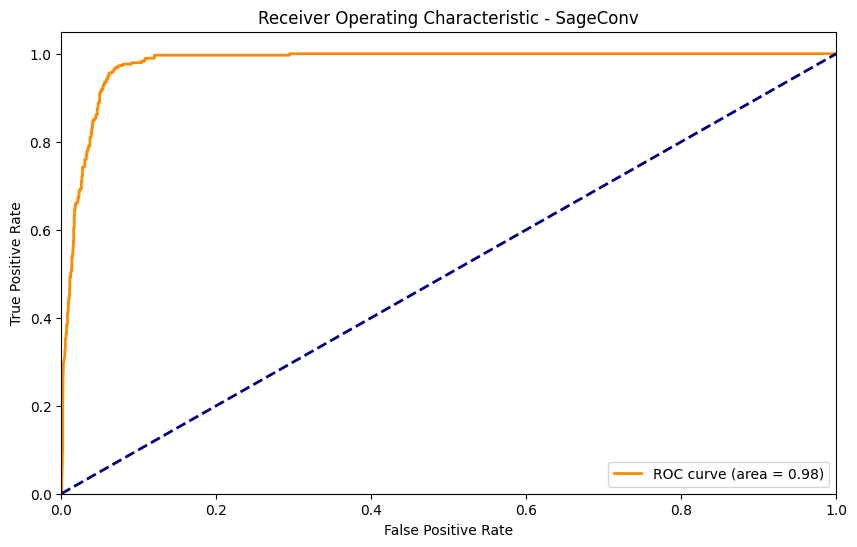

Inside train model with class weights
Epoch 1, Loss: 0.6089466649752396
Epoch 2, Loss: 0.5177201726115667
Epoch 3, Loss: 0.5074028177903249
Epoch 4, Loss: 0.4891978588241797
Epoch 5, Loss: 0.4809817041342075
Epoch 6, Loss: 0.46500249952077866
Epoch 7, Loss: 0.4600997085754688
Epoch 8, Loss: 0.4613421863088241
Epoch 9, Loss: 0.4587890918438251
Epoch 10, Loss: 0.44670995611410874
Epoch 11, Loss: 0.44564965481941515
Epoch 12, Loss: 0.44237055686803967
Epoch 13, Loss: 0.4445788957751714
Epoch 14, Loss: 0.438437856733799
Epoch 15, Loss: 0.4354566673819835
Epoch 16, Loss: 0.4402439267589496
Epoch 17, Loss: 0.4392477829868977
Epoch 18, Loss: 0.4342380274946873
Epoch 19, Loss: 0.43459803267167163
Epoch 20, Loss: 0.4293222478949107
Epoch 21, Loss: 0.4356970340013504
Epoch 22, Loss: 0.43052299263385624
Epoch 23, Loss: 0.4272120331342404
Epoch 24, Loss: 0.4279836920591501
Epoch 25, Loss: 0.42389405633394533
Epoch 26, Loss: 0.42350698090516603
Epoch 27, Loss: 0.42424972928487337
Epoch 28, Loss: 0.

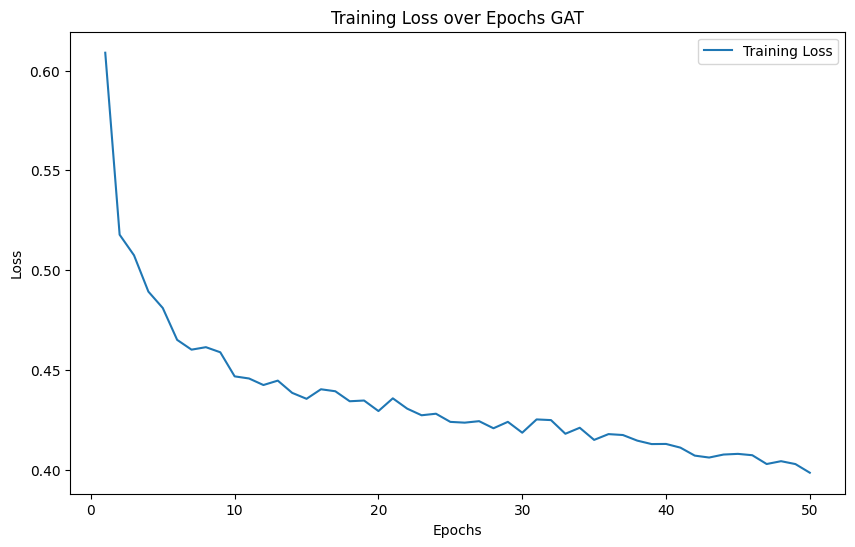

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      2628
           1       0.32      0.85      0.46       296

    accuracy                           0.80      2924
   macro avg       0.65      0.82      0.67      2924
weighted avg       0.91      0.80      0.84      2924



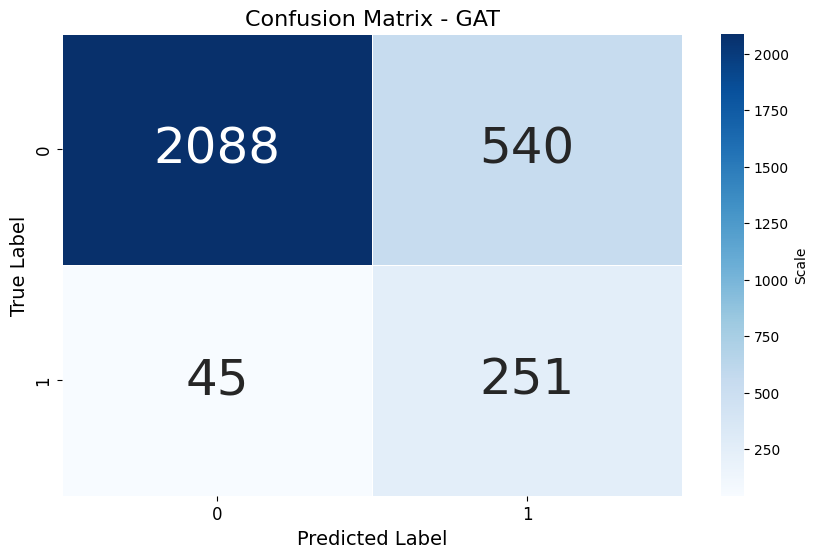

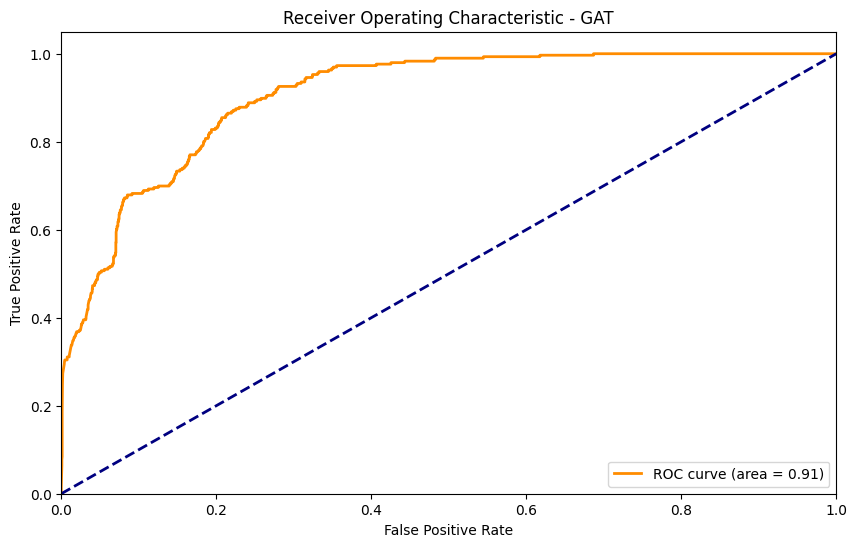

Inside train model with class weights
Epoch 1, Loss: 0.3459569983757459
Epoch 2, Loss: 0.2515851285022039
Epoch 3, Loss: 0.2466284050964392
Epoch 4, Loss: 0.24283724335523751
Epoch 5, Loss: 0.2301612923351618
Epoch 6, Loss: 0.22349681003162494
Epoch 7, Loss: 0.22334347951870698
Epoch 8, Loss: 0.2146026443403501
Epoch 9, Loss: 0.22440613204470047
Epoch 10, Loss: 0.21336448894670376
Epoch 11, Loss: 0.20793702195470148
Epoch 12, Loss: 0.20954568067995402
Epoch 13, Loss: 0.20033488494272417
Epoch 14, Loss: 0.20925018606850734
Epoch 15, Loss: 0.20927093722499335
Epoch 16, Loss: 0.20169090350659993
Epoch 17, Loss: 0.20217371846620852
Epoch 18, Loss: 0.20631812169001654
Epoch 19, Loss: 0.20039563497098592
Epoch 20, Loss: 0.1967775679838199
Epoch 21, Loss: 0.19887258456303522
Epoch 22, Loss: 0.19628160819411278
Epoch 23, Loss: 0.19055639809140792
Epoch 24, Loss: 0.19937694832109487
Epoch 25, Loss: 0.19829191296146467
Epoch 26, Loss: 0.1910421236489828
Epoch 27, Loss: 0.19491354275781375
Epoch 

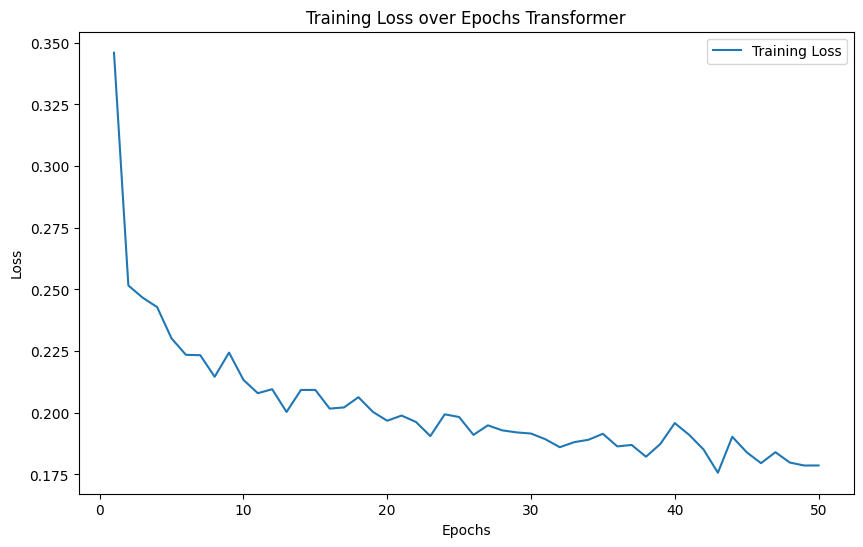

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2628
           1       0.55      0.98      0.70       296

    accuracy                           0.92      2924
   macro avg       0.77      0.94      0.83      2924
weighted avg       0.95      0.92      0.93      2924



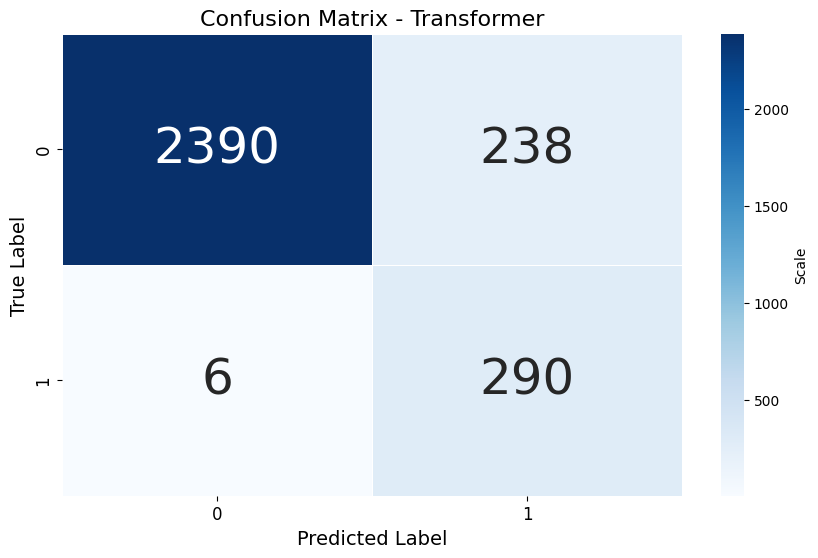

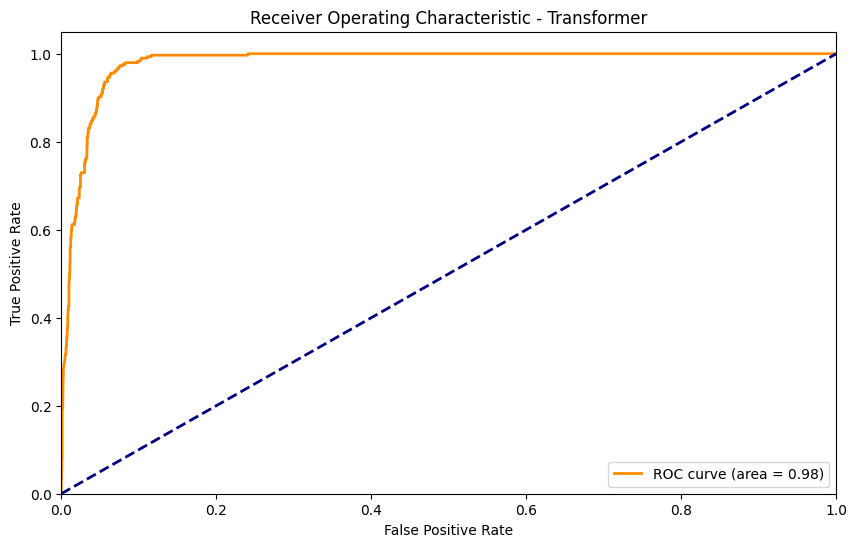

Inside train model with class weights
Epoch 1, Loss: 0.5981980206874701
Epoch 2, Loss: 0.511639847778357
Epoch 3, Loss: 0.4955309938925963
Epoch 4, Loss: 0.4853315204381943
Epoch 5, Loss: 0.4773548904519815
Epoch 6, Loss: 0.4722710269001814
Epoch 7, Loss: 0.4591673578207309
Epoch 8, Loss: 0.4534851031807753
Epoch 9, Loss: 0.4544871902236572
Epoch 10, Loss: 0.44498294649215847
Epoch 11, Loss: 0.4448116754110043
Epoch 12, Loss: 0.4425708009646489
Epoch 13, Loss: 0.44203322323469013
Epoch 14, Loss: 0.4334229225149521
Epoch 15, Loss: 0.4270052703527304
Epoch 16, Loss: 0.4303013567741101
Epoch 17, Loss: 0.43968456983566284
Epoch 18, Loss: 0.4325329472239201
Epoch 19, Loss: 0.43111503238861376
Epoch 20, Loss: 0.4279694568652373
Epoch 21, Loss: 0.4298104993425883
Epoch 22, Loss: 0.42324302861323726
Epoch 23, Loss: 0.42995602179032105
Epoch 24, Loss: 0.4215505180450586
Epoch 25, Loss: 0.42611974076582837
Epoch 26, Loss: 0.4230130028266173
Epoch 27, Loss: 0.42322014501461613
Epoch 28, Loss: 0.4

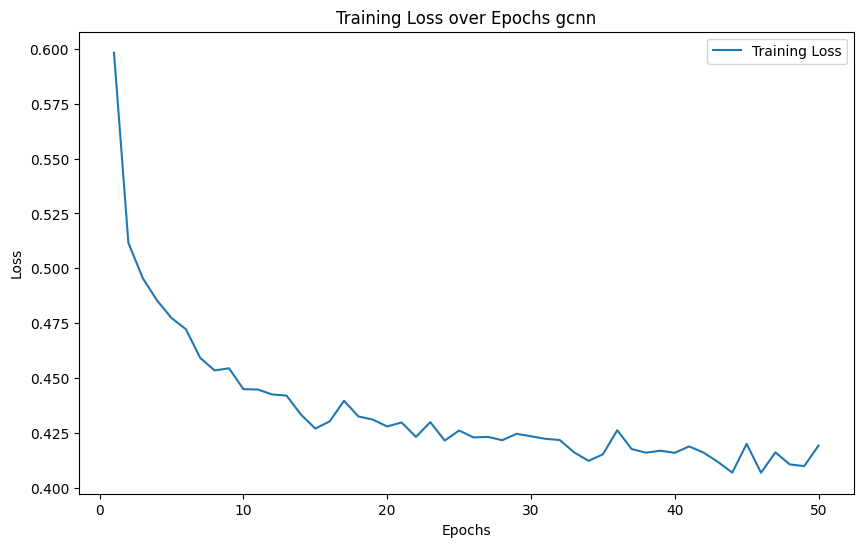

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2628
           1       0.41      0.82      0.55       296

    accuracy                           0.86      2924
   macro avg       0.69      0.85      0.73      2924
weighted avg       0.92      0.86      0.88      2924



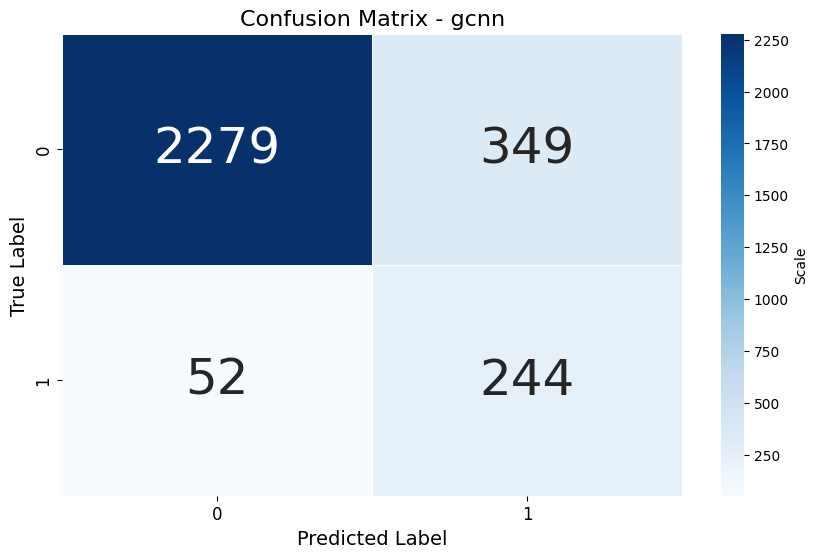

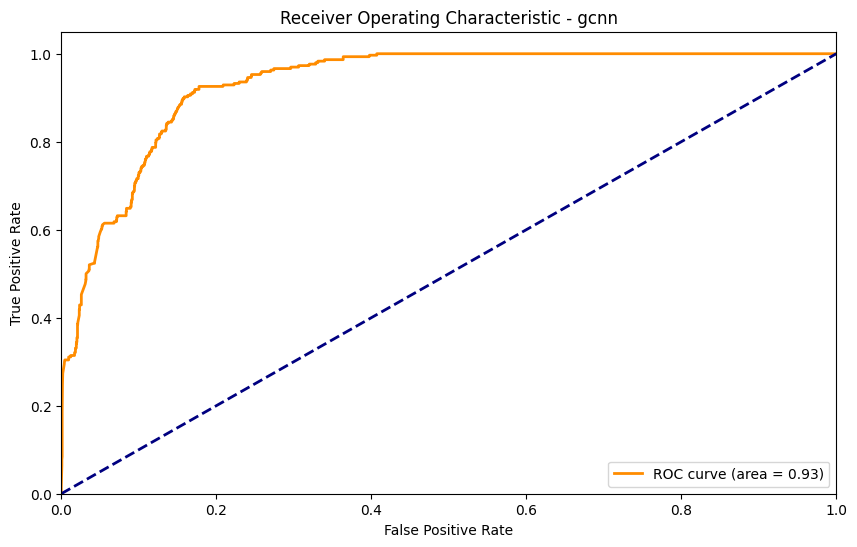

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}, 'type5_label_': {'GSageConv': 0.8361358391031981, 'GAT': 0.8437190900098912, 'GTransformer': 0.8430596768875701, 'GCNN': 0.7992087042532147}, 'type6_label_': {'GSageConv': 0.9294545454545454, 'GAT': 0.6972121212121212, 'GTransformer': 0.9447272727272727, 'GCNN': 0.8526060606060606}, 'type7_

100%|██████████████████████████████████████████████████████████████████████████████| 2658/2658 [03:57<00:00, 11.17it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1860
test_data: 798
train_data:1860
test_data:798
Inside train model with class weights
Epoch 1, Loss: 0.29553440440509277
Epoch 2, Loss: 0.19757160632792165
Epoch 3, Loss: 0.1792202410051378
Epoch 4, Loss: 0.17755294389138787
Epoch 5, Loss: 0.1728447848709963
Epoch 6, Loss: 0.16731028107263274
Epoch 7, Loss: 0.16492926443027237
Epoch 8, Loss: 0.16409990002038116
Epoch 9, Loss: 0.16547685962612346
Epoch 10, Loss: 0.1621874320810124
Epoch 11, Loss: 0.16270754903049792
Epoch 12, Loss: 0.16150052567659798
Epoch 13, Loss: 0.15906667090573554
Epoch 14, Loss: 0.15696423071420798
Epoch 15, Loss: 0.15966936491303524
Epoch 16, Loss: 0.1587488204240799
Epoch 17, Loss: 0.1517709624969353
Epoch 18, Loss: 0.1568186500314939
Epoch 19, Loss: 0.15016536237829822
Epoch 20, Loss: 0.1501469364610769
Epoch 21, Loss: 0.14952469124632367
Epoch 22, Loss: 0.14178226181006026
Epoch 23, Loss: 0.14208384533807383
Epoch 24, Loss: 0.1416394857026763
Epoch 25, Loss: 0.14537779027122563
Epoch 26, Loss: 0

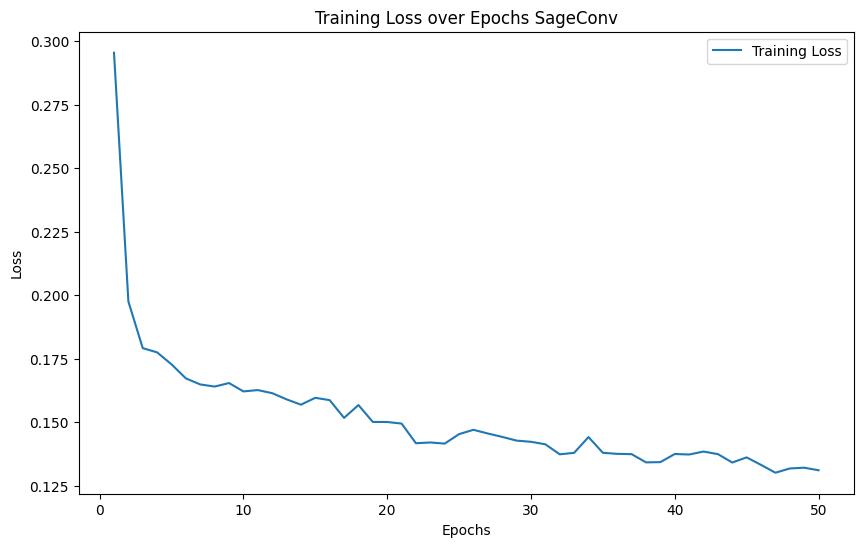

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3048
           1       0.67      0.96      0.79       443

    accuracy                           0.93      3491
   macro avg       0.83      0.95      0.88      3491
weighted avg       0.95      0.93      0.94      3491



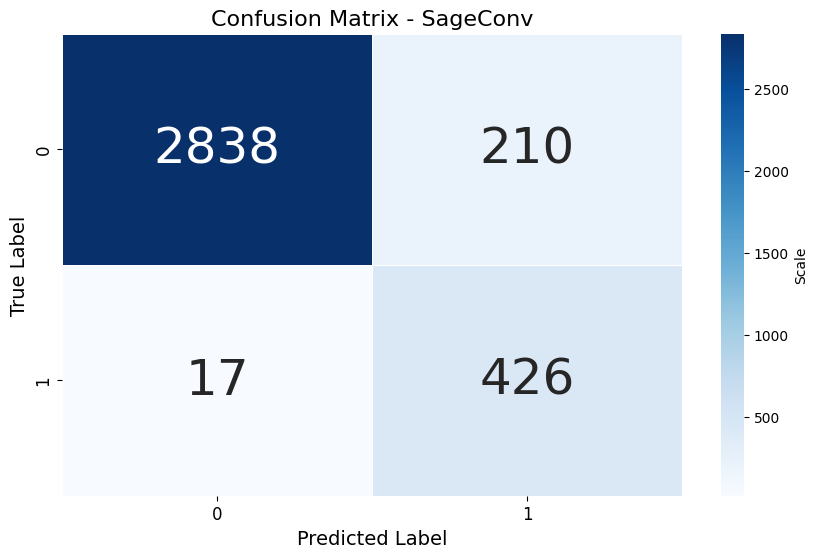

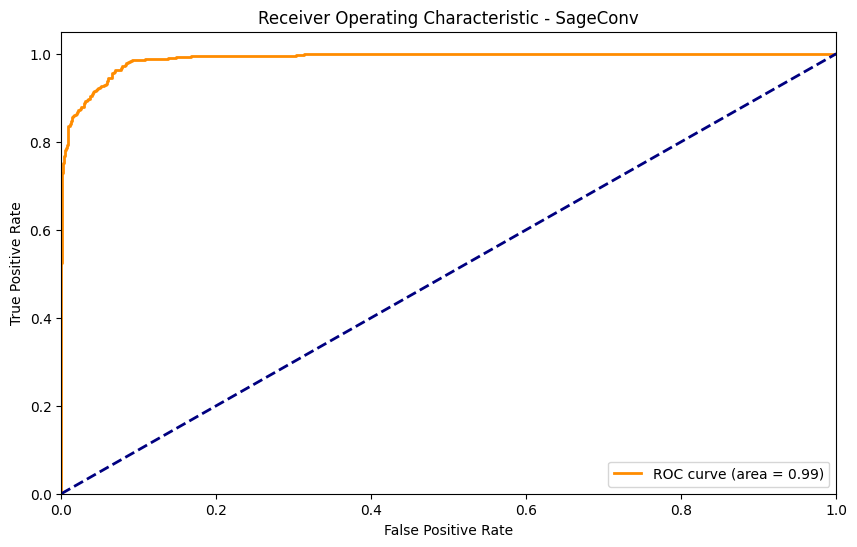

Inside train model with class weights
Epoch 1, Loss: 0.5956898033618927
Epoch 2, Loss: 0.4515945502256943
Epoch 3, Loss: 0.42868688702583313
Epoch 4, Loss: 0.38924987563642405
Epoch 5, Loss: 0.3297703730857978
Epoch 6, Loss: 0.30305679445549594
Epoch 7, Loss: 0.2894868375891346
Epoch 8, Loss: 0.2766111707788403
Epoch 9, Loss: 0.27672371040966554
Epoch 10, Loss: 0.2709291740241697
Epoch 11, Loss: 0.2684998877220235
Epoch 12, Loss: 0.2646320916838565
Epoch 13, Loss: 0.2633540033031318
Epoch 14, Loss: 0.262500766980446
Epoch 15, Loss: 0.2567473261033074
Epoch 16, Loss: 0.2568873395606623
Epoch 17, Loss: 0.2557927992636875
Epoch 18, Loss: 0.2530056865791143
Epoch 19, Loss: 0.2548217347870439
Epoch 20, Loss: 0.253675980209294
Epoch 21, Loss: 0.2513582277095924
Epoch 22, Loss: 0.24889834540880332
Epoch 23, Loss: 0.22349862211336524
Epoch 24, Loss: 0.22598042579020483
Epoch 25, Loss: 0.21916427172846714
Epoch 26, Loss: 0.21291783022678504
Epoch 27, Loss: 0.21777538791046305
Epoch 28, Loss: 0.

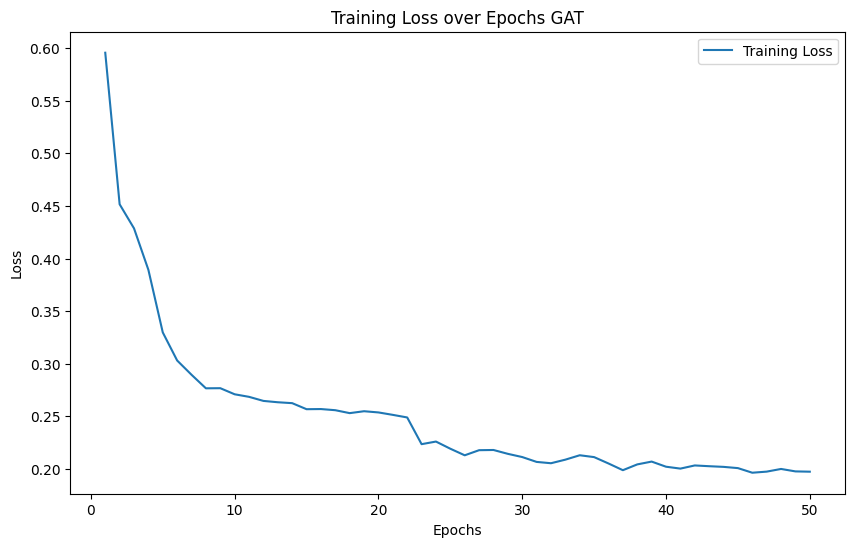

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      3048
           1       0.73      0.87      0.79       443

    accuracy                           0.94      3491
   macro avg       0.85      0.91      0.88      3491
weighted avg       0.95      0.94      0.94      3491



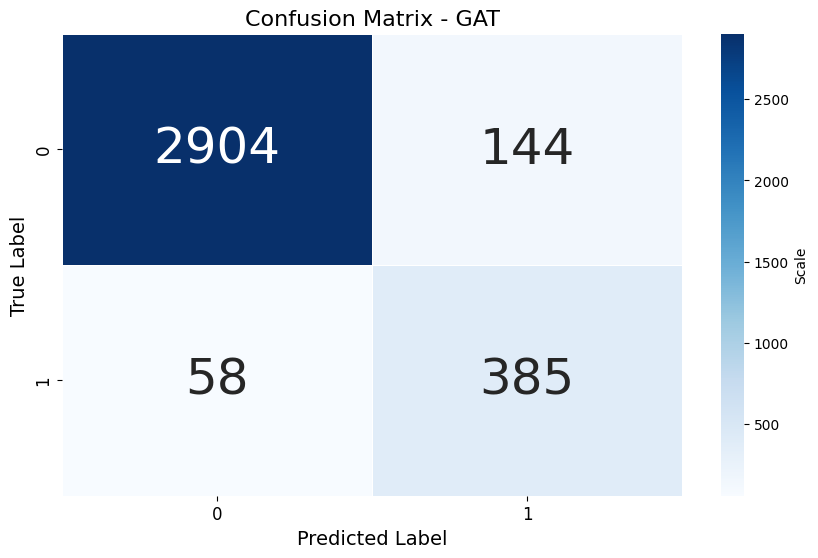

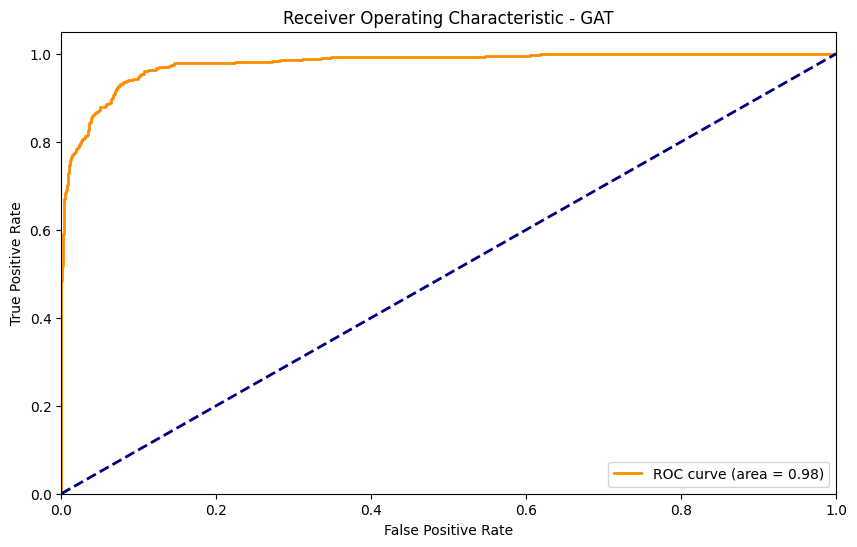

Inside train model with class weights
Epoch 1, Loss: 0.3042861095676988
Epoch 2, Loss: 0.1909644226148977
Epoch 3, Loss: 0.18199107013011384
Epoch 4, Loss: 0.17412930386046233
Epoch 5, Loss: 0.16881889685735865
Epoch 6, Loss: 0.16371023553912922
Epoch 7, Loss: 0.16037015654778075
Epoch 8, Loss: 0.1553171629370269
Epoch 9, Loss: 0.15362803776890543
Epoch 10, Loss: 0.15377271768905348
Epoch 11, Loss: 0.15505081011077104
Epoch 12, Loss: 0.15443852872161543
Epoch 13, Loss: 0.14669394720408876
Epoch 14, Loss: 0.14372240941403275
Epoch 15, Loss: 0.14645604700860332
Epoch 16, Loss: 0.14493836841340793
Epoch 17, Loss: 0.145095305043762
Epoch 18, Loss: 0.13924252582808672
Epoch 19, Loss: 0.1448404424018779
Epoch 20, Loss: 0.13576805458988173
Epoch 21, Loss: 0.13974943327701697
Epoch 22, Loss: 0.13856409805811057
Epoch 23, Loss: 0.13836388580374798
Epoch 24, Loss: 0.13479714695427378
Epoch 25, Loss: 0.13555323856614404
Epoch 26, Loss: 0.13413889245209049
Epoch 27, Loss: 0.13235068775839726
Epoch

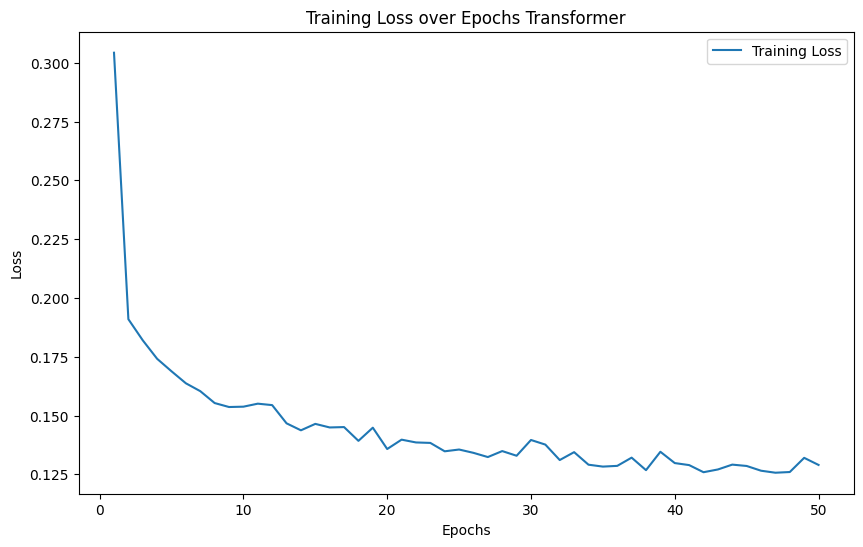

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3048
           1       0.67      0.96      0.79       443

    accuracy                           0.93      3491
   macro avg       0.83      0.94      0.87      3491
weighted avg       0.95      0.93      0.94      3491



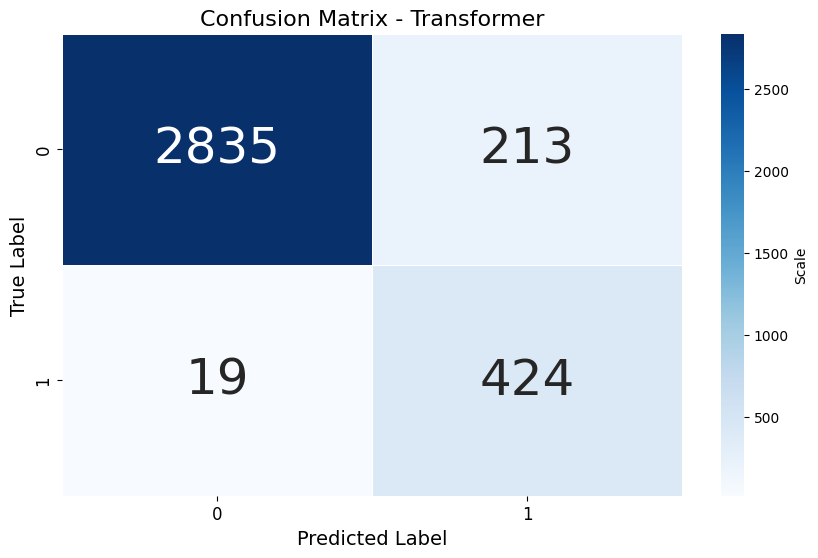

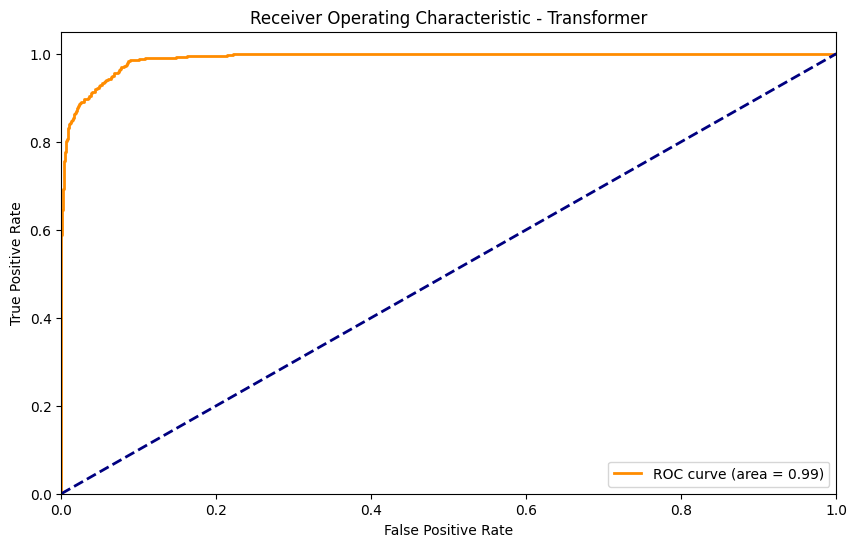

Inside train model with class weights
Epoch 1, Loss: 0.5853414373882746
Epoch 2, Loss: 0.4637735203161078
Epoch 3, Loss: 0.4095661195658021
Epoch 4, Loss: 0.36654852482221895
Epoch 5, Loss: 0.3359635949639951
Epoch 6, Loss: 0.3226272408234871
Epoch 7, Loss: 0.31594692726256485
Epoch 8, Loss: 0.30755816804150404
Epoch 9, Loss: 0.310384144217281
Epoch 10, Loss: 0.30937440996452914
Epoch 11, Loss: 0.30902724170078666
Epoch 12, Loss: 0.31310168767379504
Epoch 13, Loss: 0.29905171591346547
Epoch 14, Loss: 0.2963652146064629
Epoch 15, Loss: 0.2962713355230073
Epoch 16, Loss: 0.29712275428287055
Epoch 17, Loss: 0.3024949360701997
Epoch 18, Loss: 0.29778908546698296
Epoch 19, Loss: 0.300301390179133
Epoch 20, Loss: 0.29845400078821993
Epoch 21, Loss: 0.2957002131615655
Epoch 22, Loss: 0.2944420214931844
Epoch 23, Loss: 0.2906102591146857
Epoch 24, Loss: 0.2930028885602951
Epoch 25, Loss: 0.2975214878886433
Epoch 26, Loss: 0.28635312616825104
Epoch 27, Loss: 0.2954442038879556
Epoch 28, Loss: 0

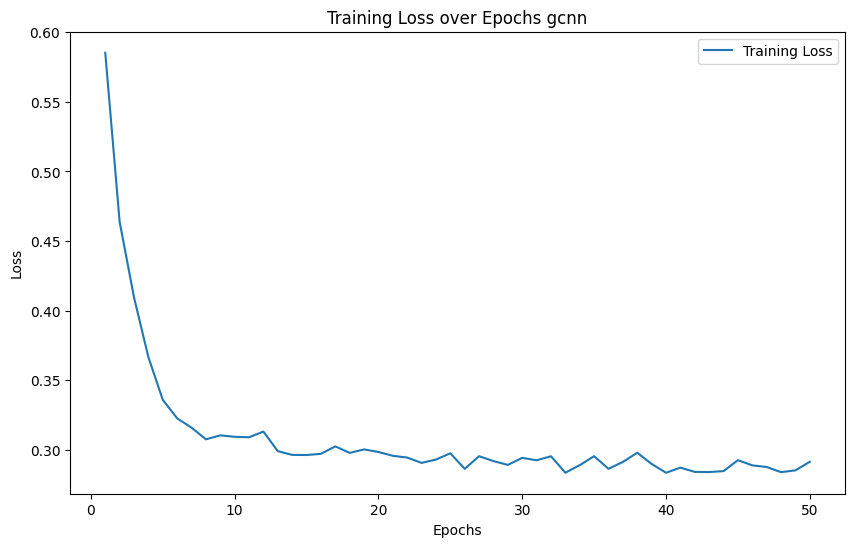

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3048
           1       0.57      0.86      0.69       443

    accuracy                           0.90      3491
   macro avg       0.78      0.88      0.81      3491
weighted avg       0.93      0.90      0.91      3491



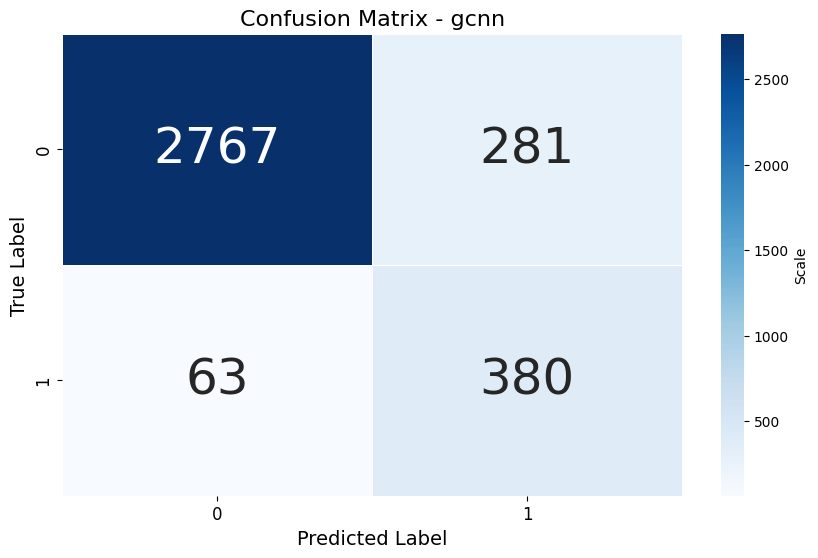

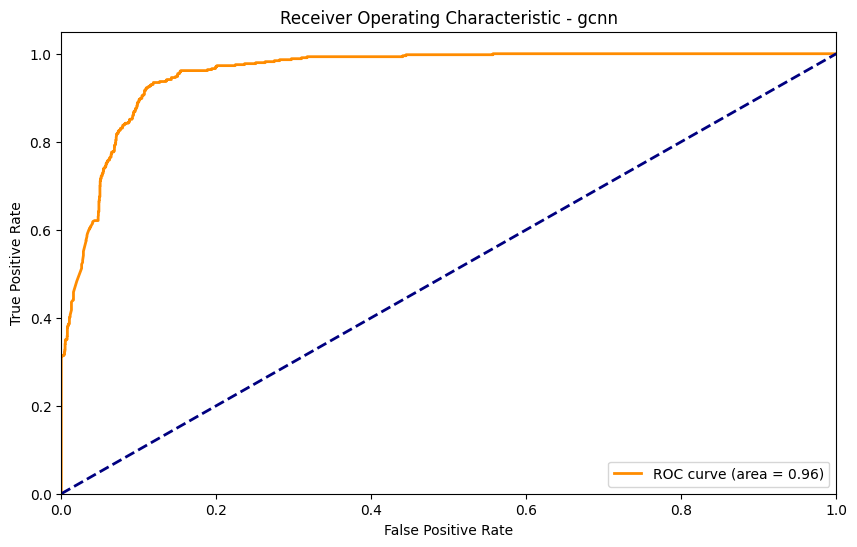

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}, 'type5_label_': {'GSageConv': 0.8361358391031981, 'GAT': 0.8437190900098912, 'GTransformer': 0.8430596768875701, 'GCNN': 0.7992087042532147}, 'type6_label_': {'GSageConv': 0.9294545454545454, 'GAT': 0.6972121212121212, 'GTransformer': 0.9447272727272727, 'GCNN': 0.8526060606060606}, 'type7_

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [03:40<00:00, 10.46it/s]
C:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1612
test_data: 692
train_data:1612
test_data:692
Inside train model with class weights
Epoch 1, Loss: 0.5144642649912367
Epoch 2, Loss: 0.42460135998679144
Epoch 3, Loss: 0.41205406305836695
Epoch 4, Loss: 0.421837618245798
Epoch 5, Loss: 0.4113558697349885
Epoch 6, Loss: 0.4183909343738182
Epoch 7, Loss: 0.3932974560588014
Epoch 8, Loss: 0.3979362757766948
Epoch 9, Loss: 0.3931480570166719
Epoch 10, Loss: 0.3878375277215359
Epoch 11, Loss: 0.3874392281560337
Epoch 12, Loss: 0.39546945545018886
Epoch 13, Loss: 0.3869761400947384
Epoch 14, Loss: 0.3976636432549533
Epoch 15, Loss: 0.38598674272789674
Epoch 16, Loss: 0.37821470405541213
Epoch 17, Loss: 0.37949519443745705
Epoch 18, Loss: 0.38832462944236457
Epoch 19, Loss: 0.37786540768894494
Epoch 20, Loss: 0.3785277029462889
Epoch 21, Loss: 0.37826192495869654
Epoch 22, Loss: 0.39344798612828347
Epoch 23, Loss: 0.379970451780394
Epoch 24, Loss: 0.38478904261308555
Epoch 25, Loss: 0.36906053505691827
Epoch 26, Loss: 0.360443

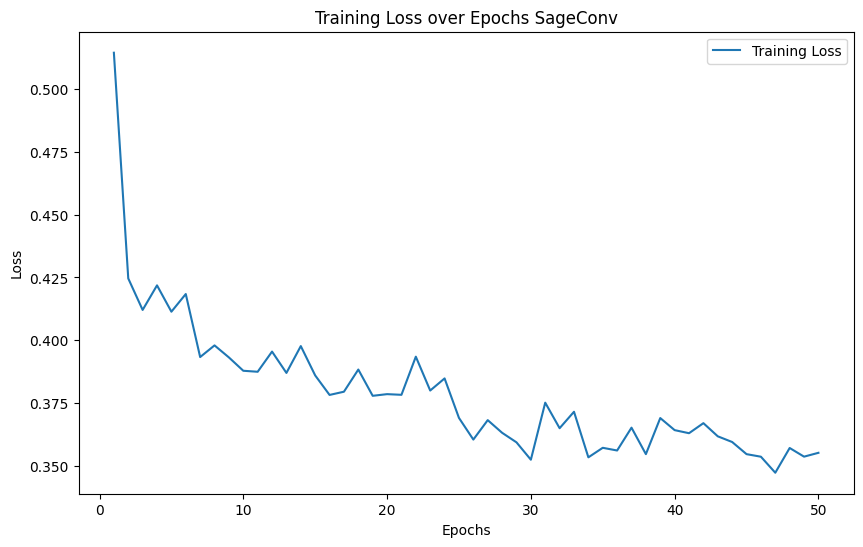

              precision    recall  f1-score   support

           0       1.00      0.81      0.89      3461
           1       0.06      0.90      0.12        51

    accuracy                           0.81      3512
   macro avg       0.53      0.86      0.51      3512
weighted avg       0.98      0.81      0.88      3512



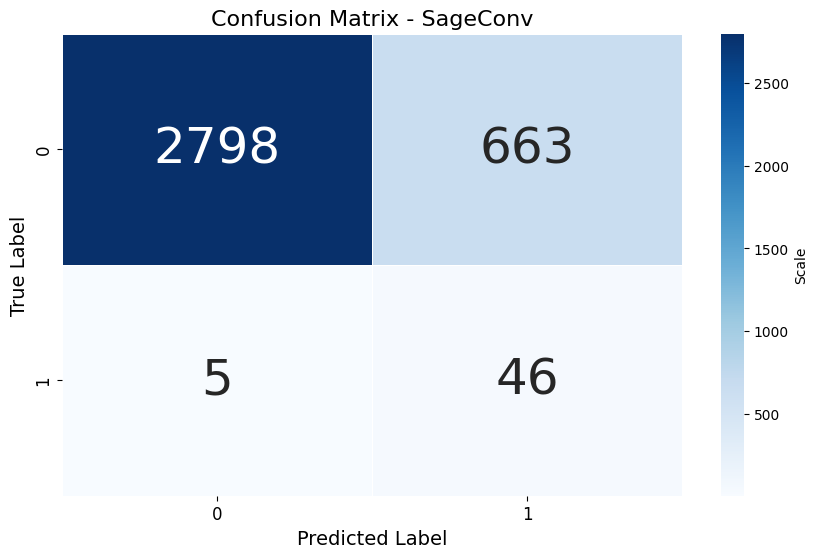

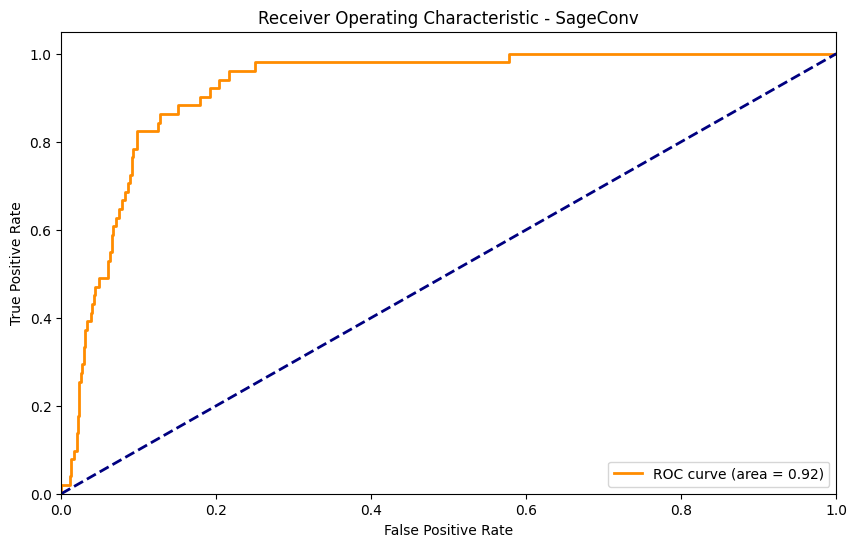

Inside train model with class weights
Epoch 1, Loss: 0.6902895932104073
Epoch 2, Loss: 0.6892797117139778
Epoch 3, Loss: 0.6886501288881489
Epoch 4, Loss: 0.6881634476138097
Epoch 5, Loss: 0.6863911993363324
Epoch 6, Loss: 0.6834883795065039
Epoch 7, Loss: 0.6728829051934037
Epoch 8, Loss: 0.636434980467254
Epoch 9, Loss: 0.6006025601835812
Epoch 10, Loss: 0.5967041943587509
Epoch 11, Loss: 0.59651539255591
Epoch 12, Loss: 0.5958112361384373
Epoch 13, Loss: 0.5889025599348778
Epoch 14, Loss: 0.5907841313119028
Epoch 15, Loss: 0.5872430211188746
Epoch 16, Loss: 0.5858856287657046
Epoch 17, Loss: 0.5926902650618086
Epoch 18, Loss: 0.5851492081202713
Epoch 19, Loss: 0.58146166509273
Epoch 20, Loss: 0.5842144103611216
Epoch 21, Loss: 0.5856784138025022
Epoch 22, Loss: 0.5849263060326669
Epoch 23, Loss: 0.5796471045297735
Epoch 24, Loss: 0.5804070725160486
Epoch 25, Loss: 0.5815679653018129
Epoch 26, Loss: 0.5799224727294024
Epoch 27, Loss: 0.5779036038062152
Epoch 28, Loss: 0.5752969927647

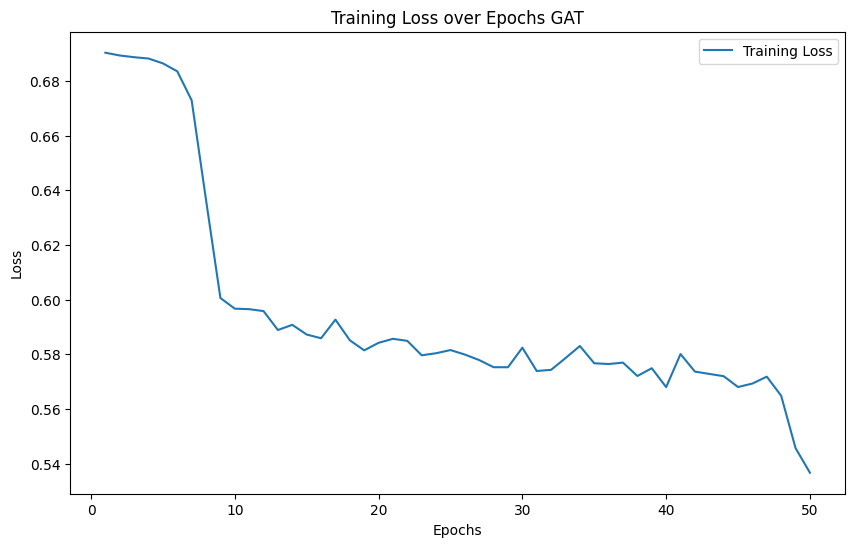

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      3461
           1       0.05      0.69      0.09        51

    accuracy                           0.79      3512
   macro avg       0.52      0.74      0.49      3512
weighted avg       0.98      0.79      0.87      3512



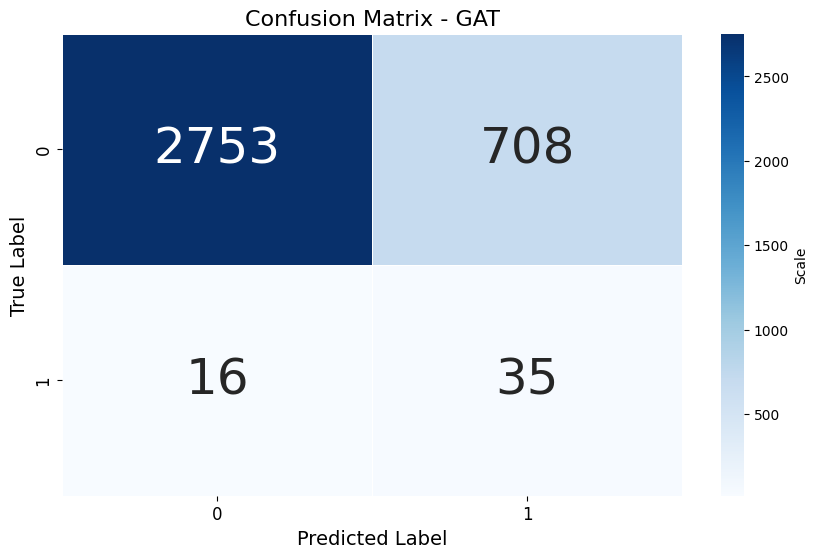

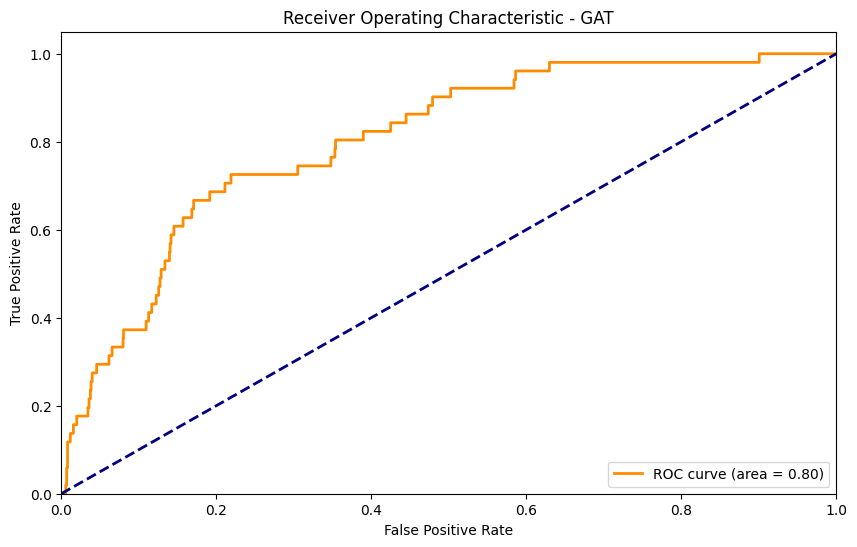

Inside train model with class weights
Epoch 1, Loss: 0.5253635317671532
Epoch 2, Loss: 0.44410698612531024
Epoch 3, Loss: 0.4216569948430155
Epoch 4, Loss: 0.38663770462952407
Epoch 5, Loss: 0.4188522497812907
Epoch 6, Loss: 0.41885227841489453
Epoch 7, Loss: 0.4007764867707795
Epoch 8, Loss: 0.4036974296265957
Epoch 9, Loss: 0.38876309932446945
Epoch 10, Loss: 0.3951924618552713
Epoch 11, Loss: 0.4000989955429937
Epoch 12, Loss: 0.3944651618892071
Epoch 13, Loss: 0.3901129566571292
Epoch 14, Loss: 0.37568888418814717
Epoch 15, Loss: 0.38659685119694354
Epoch 16, Loss: 0.3814252188392714
Epoch 17, Loss: 0.3789803321455039
Epoch 18, Loss: 0.38925448469087187
Epoch 19, Loss: 0.37291041308758305
Epoch 20, Loss: 0.3897978806612538
Epoch 21, Loss: 0.3866690914420521
Epoch 22, Loss: 0.36224109957031175
Epoch 23, Loss: 0.3795586251745037
Epoch 24, Loss: 0.38330385381100224
Epoch 25, Loss: 0.3842695738170661
Epoch 26, Loss: 0.36475440100127576
Epoch 27, Loss: 0.36318297479666917
Epoch 28, Loss

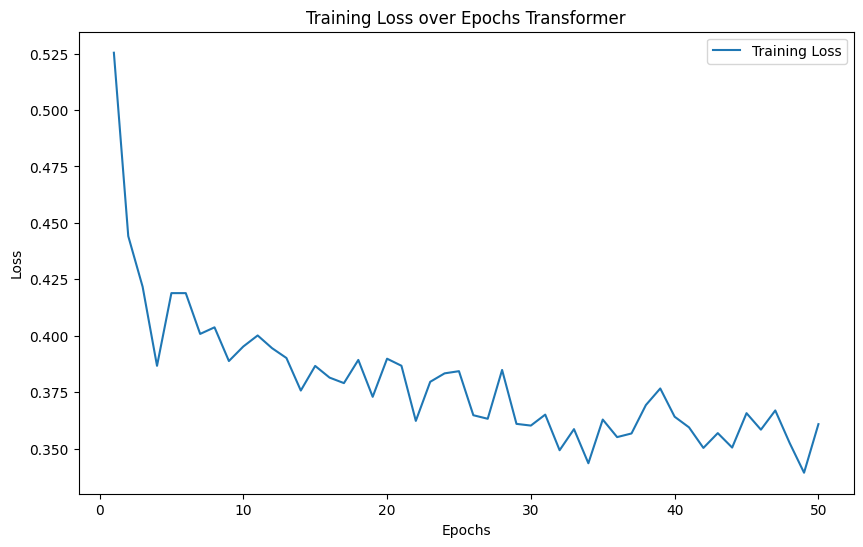

              precision    recall  f1-score   support

           0       1.00      0.81      0.90      3461
           1       0.07      0.90      0.12        51

    accuracy                           0.82      3512
   macro avg       0.53      0.86      0.51      3512
weighted avg       0.98      0.82      0.89      3512



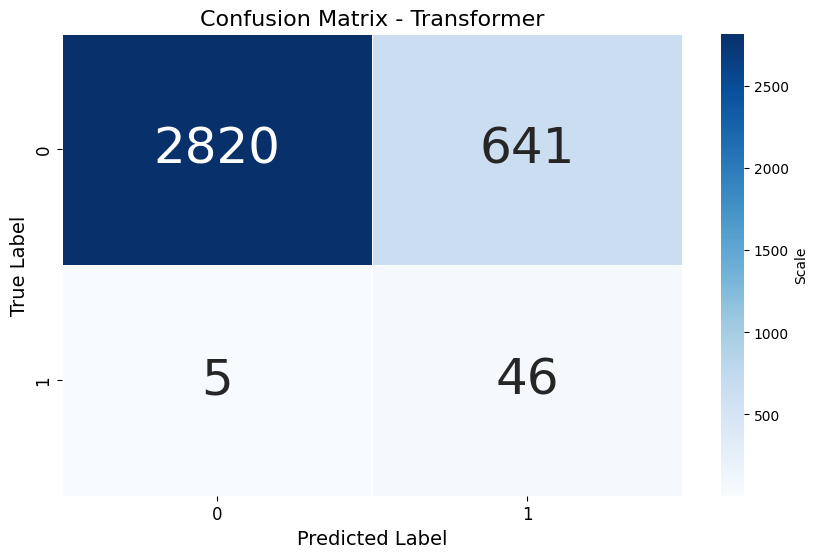

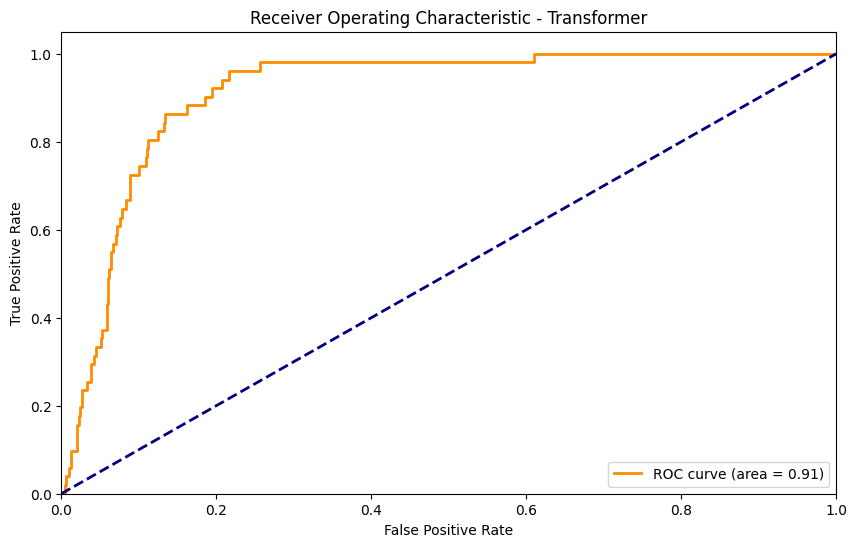

Inside train model with class weights
Epoch 1, Loss: 0.694498832319297
Epoch 2, Loss: 0.6808831820300981
Epoch 3, Loss: 0.6602656607534371
Epoch 4, Loss: 0.6326056116936254
Epoch 5, Loss: 0.5981466963010675
Epoch 6, Loss: 0.5765246655426773
Epoch 7, Loss: 0.5529115866212284
Epoch 8, Loss: 0.5518336044807061
Epoch 9, Loss: 0.5200676187580707
Epoch 10, Loss: 0.5282724552294787
Epoch 11, Loss: 0.52942040328886
Epoch 12, Loss: 0.507133927415399
Epoch 13, Loss: 0.5009809527911392
Epoch 14, Loss: 0.5027226729720247
Epoch 15, Loss: 0.5035137598421059
Epoch 16, Loss: 0.523248041377348
Epoch 17, Loss: 0.5011349086667977
Epoch 18, Loss: 0.503746522992265
Epoch 19, Loss: 0.5005973419722389
Epoch 20, Loss: 0.5137080778093899
Epoch 21, Loss: 0.4879113909076242
Epoch 22, Loss: 0.4936677755094042
Epoch 23, Loss: 0.505589391670975
Epoch 24, Loss: 0.5003953710490582
Epoch 25, Loss: 0.5082140588292888
Epoch 26, Loss: 0.4964192930389853
Epoch 27, Loss: 0.4980190600834641
Epoch 28, Loss: 0.515213286175447

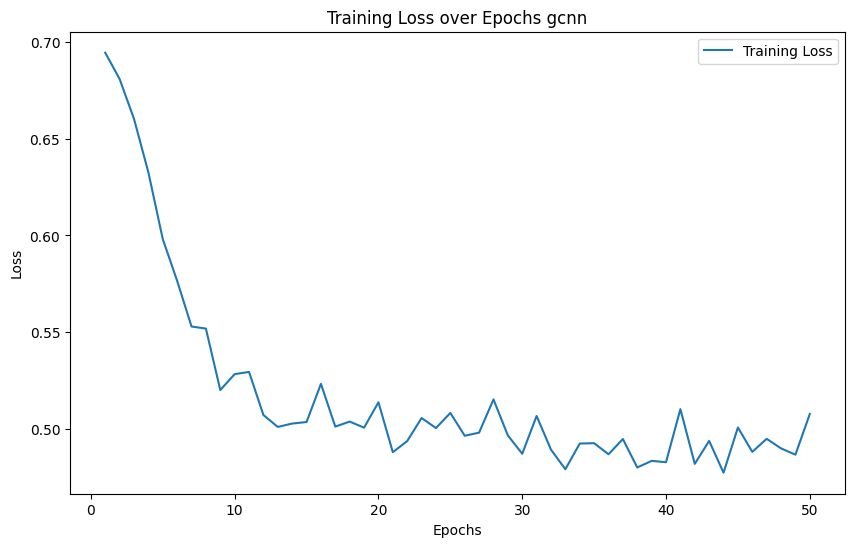

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      3461
           1       0.05      0.82      0.10        51

    accuracy                           0.78      3512
   macro avg       0.52      0.80      0.49      3512
weighted avg       0.98      0.78      0.87      3512



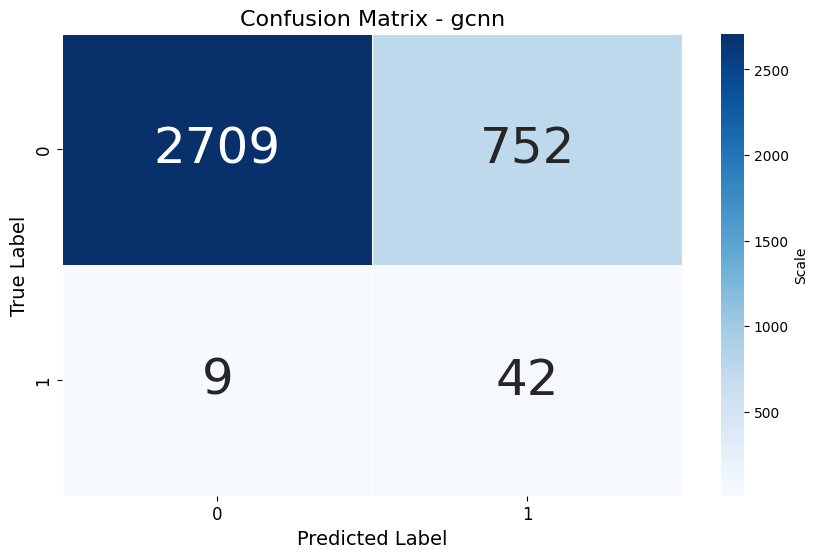

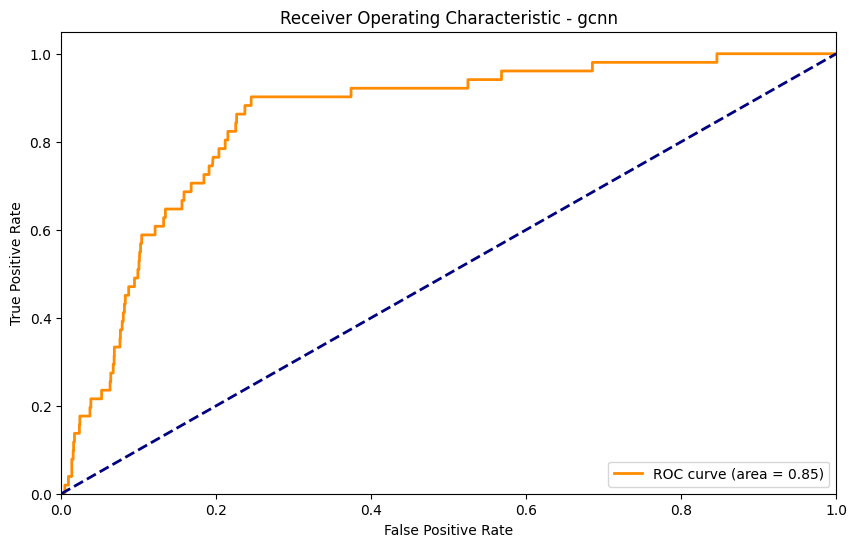

{'type10_label': {'GSageConv': 0.9094707520891365, 'GAT': 0.8924094707520891, 'GTransformer': 0.899025069637883, 'GCNN': 0.8596796657381616}, 'type1_label_': {'GSageConv': 0.9937853107344633, 'GAT': 0.8813559322033898, 'GTransformer': 0.9937853107344633, 'GCNN': 0.9101694915254237}, 'type2_label_': {'GSageConv': 0.979047619047619, 'GAT': 0.9757142857142858, 'GTransformer': 0.9666666666666667, 'GCNN': 0.9709523809523809}, 'type3_label_': {'GSageConv': 0.9880952380952381, 'GAT': 0.7895408163265306, 'GTransformer': 0.9851190476190477, 'GCNN': 0.8613945578231292}, 'type4_label_': {'GSageConv': 0.9974380871050385, 'GAT': 0.9982920580700256, 'GTransformer': 0.9991460290350128, 'GCNN': 0.9995730145175064}, 'type5_label_': {'GSageConv': 0.8361358391031981, 'GAT': 0.8437190900098912, 'GTransformer': 0.8430596768875701, 'GCNN': 0.7992087042532147}, 'type6_label_': {'GSageConv': 0.9294545454545454, 'GAT': 0.6972121212121212, 'GTransformer': 0.9447272727272727, 'GCNN': 0.8526060606060606}, 'type7_

In [49]:

new_execution_flag = 1
# assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")



result_dict = {}
for file_path in xlsx_files:
    print(file_path)

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data_density(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)

    train_size = int(0.7 * len(pyg_data_list))
    test_size = len(pyg_data_list) - train_size
    train_data, test_data = random_split(pyg_data_list, [train_size, test_size])

    print(f"train_data: {len(train_data)}\ntest_data: {len(test_data)}")


    # train_size = int(0.7 * len(pyg_data_list))
    # train_data = pyg_data_list[:train_size]
    # test_data = pyg_data_list[train_size:]

    # # Assuming pyg_graphs is your dataset and you have split it into train and test
    # train_size = int(0.8 * len(pyg_graphs))
    # test_size = len(pyg_graphs) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(pyg_graphs, [train_size, test_size])


    print(f"train_data:{len(train_data)}\ntest_data:{len(test_data)}")

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir,visualization_dir)
    _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir,visualization_dir)
    _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir,visualization_dir)
    # _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir,visualization_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn',result_dir,visualization_dir)

    result_dict[label_key] = {
        'GSageConv': acc,
        'GAT': gat_acc,
        'GTransformer': transformer_acc,
        # 'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    print(result_dict)



# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")



In [32]:
len(xlsx_files)

10